In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# ===== 必要ライブラリ =====
import numpy as np
import pandas as pd
from pathlib import Path

# ===== 入出力設定 =====
FIG_DIR = Path("figuresD")
FIG_DIR.mkdir(exist_ok=True)
PEAK_CSV = "peak_table.csv"

# ===== データ読み込み =====
info_potential = np.load("info_potential.npy")   # I(t)
dc_dt          = np.load("dc_dt.npy")            # dI/dt
kappa_list     = np.load("kappa_list.npy")       # κ(p)(t)
y_data         = np.load("y_data.npy")           # 時系列軸 (同じ長さ前提)

dt = float(np.median(np.diff(y_data)))           # サンプリング間隔

signals = {
    "info_potential": info_potential,
    "dc_dt":          dc_dt,
    "kappa":          kappa_list
}

# ===== FFT 関数 =====
def compute_fft(sig, dt):
    """信号 sig に対して rFFT を行い、周波数・振幅・位相を返す"""
    N = len(sig)
    fft_vals = np.fft.rfft(sig - sig.mean())    # DC 成分除去
    freqs    = np.fft.rfftfreq(N, d=dt)
    amp      = np.abs(fft_vals)
    phase    = np.angle(fft_vals)
    return freqs, amp, phase

# ===== 解析 & 可視化 =====
peak_rows = []  # 周波数ピークトップ3を保存

plt.figure(figsize=(10, 6))

for idx, (name, sig) in enumerate(signals.items(), 1):
    freqs, amp, phase = compute_fft(sig, dt)

    # --- トップ3ピーク抽出 ---
    top_idx = np.argsort(amp)[-3:][::-1]
    for rank, i_peak in enumerate(top_idx, 1):
        peak_rows.append({
            "signal": name,
            "rank":   rank,
            "freq":   freqs[i_peak],
            "amp":    amp[i_peak],
            "phase":  phase[i_peak]
        })

# --- プロット ---
plt.plot(freqs, amp, label=f"{name}")

# ✅ 軸・タイトル・凡例に日本語フォントを適用
plt.xlabel("周波数（1/単位時間）", fontproperties=font_prop)
plt.ylabel("振幅（|FFT|）", fontproperties=font_prop)
plt.title("FFTスペクトルの概要", fontproperties=font_prop)
plt.legend(prop=font_prop)

plt.tight_layout()
plt.savefig(FIG_DIR / "fft_overview.png", dpi=300)
plt.close()

# ===== ピークテーブル保存 =====
pd.DataFrame(peak_rows).to_csv(PEAK_CSV, index=False)

print("✅ SP-1 完了: 図＝figuresD/fft_overview.png, 表＝peak_table.csv が生成されました。")
from google.colab import files
files.download("peak_table.csv")
from google.colab import files
files.download("figuresD/fft_overview.png")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


✅ SP-1 完了: 図＝figuresD/fft_overview.png, 表＝peak_table.csv が生成されました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# ===== ライブラリ =====
import numpy as np
import pandas as pd
import pickle, gzip, json
from pathlib import Path

# ===== 入出力 =====
FIG_DIR = Path("figuresD"); FIG_DIR.mkdir(exist_ok=True)
STAT_JSON = "phase_stats.json"

# ===== 1. φ_s・φ_t 読み込み =====
with gzip.open("phase_lists.pkl", "rb") as f:
    phase_data = pickle.load(f)

phi_s = np.array(phase_data["phi_s"])            # shape = (N,)
phi_t_main = phase_data["phi_t"]["info_potential"]

# ===== 2. Δφ 計算 → -π〜π に折りたたみ =====
delta_phi = (phi_s - phi_t_main + np.pi) % (2*np.pi) - np.pi

# ===== 3. ヒストグラム (60 bins) & χ² 統計 =====
bins = 60
hist, bin_edges = np.histogram(delta_phi, bins=bins, range=(-np.pi, np.pi))
expected = len(delta_phi) / bins
chi2 = np.sum((hist - expected)**2 / expected)

# ---- シャッフルによる p 値推定 ----
perm_n = 1000
chi2_perm = []
for _ in range(perm_n):
    delta_perm = np.random.permutation(delta_phi)
    h_perm, _ = np.histogram(delta_perm, bins=bins, range=(-np.pi, np.pi))
    chi2_perm.append(np.sum((h_perm - expected)**2 / expected))
p_value = (np.sum(np.array(chi2_perm) >= chi2) + 1) / (perm_n + 1)

# ===== 4. UMAP 空間ヒートマップ =====
umap = np.load("umap_embedding.npy")  # shape (N, 2)

plt.figure(figsize=(6, 5))
sc = plt.scatter(umap[:, 0], umap[:, 1],
                 c=delta_phi, cmap="twilight", s=6, alpha=0.8)

# ✅ カラーバー（フォント適用）
cbar = plt.colorbar(sc)
cbar.set_label("Δφ（位相差、ラジアン）", fontproperties=font_prop)

# ✅ タイトル・軸ラベル
plt.title("UMAP 空間における Δφ のヒートマップ", fontproperties=font_prop)
plt.xlabel("UMAP 第1成分", fontproperties=font_prop)
plt.ylabel("UMAP 第2成分", fontproperties=font_prop)

plt.tight_layout()
plt.savefig(FIG_DIR / "delta_phase_heatmap.png", dpi=300)
plt.close()

# ===== 5. 統計保存 =====
stats = {
    "chi2": float(chi2),
    "p_value": float(p_value),
    "bins": bins,
    "N": int(len(delta_phi))
}
with open(STAT_JSON, "w") as f:
    json.dump(stats, f, indent=2, ensure_ascii=False)

print("✅ SP‑3 完了: 図と phase_stats.json を保存しました。")
from google.colab import files
files.download("phase_stats.json")
from google.colab import files
files.download("figuresD/delta_phase_heatmap.png")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


✅ SP‑3 完了: 図と phase_stats.json を保存しました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# ===== 必要ライブラリ =====
import numpy as np
import pandas as pd
import pickle, gzip, json, sqlite3
from pathlib import Path

# ===== 出力フォルダ =====
FIG_DIR = Path("figuresD"); FIG_DIR.mkdir(exist_ok=True)

# ------------------------------------------------------------------
# 1. データ準備  ----------------------------------------------------
# ------------------------------------------------------------------
# φ_s・φ_t・Δφ のロード
with gzip.open("phase_lists.pkl", "rb") as f:
    phase_data = pickle.load(f)
phi_s = np.array(phase_data["phi_s"])
phi_t_main = phase_data["phi_t"]["info_potential"]
delta_phi = (phi_s - phi_t_main + np.pi) % (2*np.pi) - np.pi

# クラスタラベル
cluster_labels = np.load("cluster_labels.npy")

# ------------------------------------------------------------------
# 2. Δφ のクラスタ別統計 (σ_dphi)  --------------------------------
# ------------------------------------------------------------------
df_phase = pd.DataFrame({
    "cluster": cluster_labels,
    "dphi": delta_phi
})
sigma_tbl = (df_phase
             .groupby("cluster")["dphi"]
             .agg(sigma_dphi=np.std, N="count")
             .reset_index())

# ------------------------------------------------------------------
# 3. Material & BindingEnergy テーブル作成 -------------------------
# ------------------------------------------------------------------
# ── SQLite DB をワンファイルで
con = sqlite3.connect("materials.db")
cur = con.cursor()

cur.executescript("""
DROP TABLE IF EXISTS Material;
DROP TABLE IF EXISTS BindingEnergy;
DROP TABLE IF EXISTS RlockResult;

CREATE TABLE Material(
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  name TEXT UNIQUE,
  rho_mass REAL   -- g/cm^3 等
);

CREATE TABLE BindingEnergy(
  mat_id INTEGER,
  E_bind REAL,    -- kJ/mol 等
  FOREIGN KEY(mat_id) REFERENCES Material(id)
);

CREATE TABLE RlockResult(
  cluster INTEGER,
  mat_id  INTEGER,
  R_lock  REAL,
  FOREIGN KEY(mat_id) REFERENCES Material(id)
);
""")

# ── 例: 羽根 (模擬平均) と 鉄
materials = [
    ("Fe", 7.874),  # g/cm^3
    ("Feather", 0.002)
]
cur.executemany("INSERT INTO Material(name,rho_mass) VALUES(?,?)", materials)

# 結合エネルギー (非常に粗いモデル値)
E_data = [
    ("Fe",      409.),   # kJ/mol (鉄格子エネルギー近似)
    ("Feather",  10.)    # タンパク質分解平均値
]
for name, E in E_data:
    mat_id = cur.execute("SELECT id FROM Material WHERE name=?", (name,)).fetchone()[0]
    cur.execute("INSERT INTO BindingEnergy(mat_id,E_bind) VALUES(?,?)", (mat_id, E))
con.commit()

# ------------------------------------------------------------------
# 4. R_lock 計算  ---------------------------------------------------
# ------------------------------------------------------------------
# 正規化の基準値を適当に設定
E_ref   = 409.   # 最大結合エネルギーを基準
rho_ref = 7.874  # 最大密度を基準

def calc_Rlock(sigma, E_bind, rho):
    """
    σ_dphi が小さいほどロックが強い (1/(1+σ))。
    E_bind, rho は確定を強める方向に線形スケール。
    """
    return (1 / (1 + sigma)) * (E_bind / E_ref) * (rho / rho_ref)

# ── ループ計算
for _, row in sigma_tbl.iterrows():
    clust = int(row["cluster"])
    sigma = float(row["sigma_dphi"])
    # 全 Material に対して計算
    for name in ["Fe", "Feather"]:
        mat_id, rho = cur.execute(
            "SELECT id, rho_mass FROM Material WHERE name=?", (name,)
        ).fetchone()
        E_bind = cur.execute(
            "SELECT E_bind FROM BindingEnergy WHERE mat_id=?", (mat_id,)
        ).fetchone()[0]
        Rval = calc_Rlock(sigma, E_bind, rho)
        cur.execute(
            "INSERT INTO RlockResult(cluster,mat_id,R_lock) VALUES(?,?,?)",
            (clust, mat_id, Rval)
        )
con.commit()

# ------------------------------------------------------------------
# 5. R_lock 可視化  -------------------------------------------------
# ------------------------------------------------------------------
df_R = pd.read_sql_query(
    """SELECT cluster, name AS material, R_lock
       FROM RlockResult
       JOIN Material ON RlockResult.mat_id = Material.id
    """, con)

# 棒グラフ
plt.figure(figsize=(8,5))
for mat in df_R["material"].unique():
    sub = df_R[df_R["material"] == mat]
    plt.bar(sub["cluster"] + (0.2 if mat=="Fe" else -0.2),
            sub["R_lock"],
            width=0.4, label=mat)

plt.xlabel("Cluster ID", fontproperties=font_prop)
plt.ylabel("R_lock", fontproperties=font_prop)
plt.title("Cluster × Material における R_lock", fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.tight_layout()
plt.savefig(FIG_DIR / "rlock_bar.png", dpi=300)
plt.close()

# ------------------------------------------------------------------
# 6. 結果ダンプ & 終了  -------------------------------------------
df_R.to_csv("rlock_results.csv", index=False)
con.close()

print("✅ SP‑4 & 5 完了: materials.db, rlock_results.csv, figuresD/rlock_bar.png を生成しました。")
from google.colab import files
files.download("materials.db")
from google.colab import files
files.download("rlock_results.csv")
from google.colab import files
files.download("figuresD/rlock_bar.png")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


<ipython-input-8-a43140dad335>:40: FutureWarning: The provided callable <function std at 0x781f2c10a0c0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  .agg(sigma_dphi=np.std, N="count")


✅ SP‑4 & 5 完了: materials.db, rlock_results.csv, figuresD/rlock_bar.png を生成しました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# ===== 必要ライブラリ =====
import numpy as np
import pandas as pd
from pathlib import Path

# ===== 出力フォルダ =====
FIG_DIR = Path("figuresD"); FIG_DIR.mkdir(exist_ok=True)

# ------------------------------------------------------------------
# 1. パラメータ設定  -----------------------------------------------
# ------------------------------------------------------------------
N_PHOTON = 20000          # モンテカルロ光子数
L_MEDIUM = 1e-3           # 媒質長 [m]
c       = 2.99792458e8    # 光速 [m/s]
n_list  = [1.0, 1.33, 2.0]            # 屈折率 (真空/水/高密度ガラス)
sigma_s = 1e-6            # 散乱断面積 [m^-1] (平均自由行程 = 1/sigma)

# ------------------------------------------------------------------
# 2. シミュレーション関数  -----------------------------------------
# ------------------------------------------------------------------
def simulate_photon(n_refr, seed=None):
    """
    媒質長 L 内をランダム散乱しながら直進・屈折を繰り返す光子。
    • 散乱イベント毎に等方散乱とし、次の自由行程 ~ Exp(sigma_s)。
    • フォトンが媒質出口に達した時刻を τ_lock とみなす。
    • 途中の位相確定効果は R_lock = τ_lock / (τ_lock + τ_prop(v= c/n_refr)) で評価。
    """
    rng = np.random.default_rng(seed)
    z = 0.0
    t = 0.0
    v = c / n_refr             # 媒質中群速度
    while z < L_MEDIUM:
        free_path = rng.exponential(1/sigma_s)
        z += free_path
        t += free_path / v
        # 散乱で方向ランダム化（1Dモデルなので z 方向に再投影）
        # ここでは位相確定遅延 = 0 と仮定 → 純粋伝搬のみ計時
    τ_lock = t                  # 全走行時間
    τ_prop = L_MEDIUM / v       # 散乱が無ければ掛かる時間
    R_lock = τ_lock / (τ_lock + τ_prop)
    return τ_lock, R_lock

# ------------------------------------------------------------------
# 3. 実行ループ  ---------------------------------------------------
# ------------------------------------------------------------------
results = []

for n_refr in n_list:
    for i in range(N_PHOTON):
        τ, R = simulate_photon(n_refr, seed=None)
        results.append((n_refr, τ, R))

df = pd.DataFrame(results, columns=["n_refr", "tau_lock", "R_lock"])

# ------------------------------------------------------------------
# 4. 可視化  -------------------------------------------------------
# ------------------------------------------------------------------
plt.figure(figsize=(7, 5))
for n_refr in n_list:
    subset = df[df["n_refr"] == n_refr]
    plt.hist(subset["R_lock"], bins=60, alpha=0.5, label=f"n = {n_refr}")

# ✅ 軸ラベル・タイトル・凡例に日本語フォントを適用
plt.xlabel("R_lock（同期係数）", fontproperties=font_prop)
plt.ylabel("頻度", fontproperties=font_prop)
plt.title("R_lock の分布（光子シミュレーション）", fontproperties=font_prop)
plt.legend(prop=font_prop)

plt.tight_layout()
plt.savefig(FIG_DIR / "photon_rlock_hist.png", dpi=300)
plt.close()

# ------------------------------------------------------------------
# 5. 要約統計  -----------------------------------------------------
summary = (df.groupby("n_refr")["R_lock"]
             .agg(["mean","std","min","max"])
             .reset_index())
summary.to_csv("photon_rlock_summary.csv", index=False)

print(summary)
print("✅ Task‑3 シミュレーション完了: 図と CSV を出力しました。")
from google.colab import files
files.download("photon_rlock_summary.csv")
from google.colab import files
files.download("figuresD/photon_rlock_hist.png")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 1s (73.1 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 126332 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


   n_refr  mean           std       min  max
0    1.00   1.0  1.447112e-07  0.999983  1.0
1    1.33   1.0  2.595201e-07  0.999975  1.0
2    2.00   1.0  1.518920e-07  0.999985  1.0
✅ Task‑3 シミュレーション完了: 図と CSV を出力しました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# ===== ライブラリ =====
import numpy as np
import pandas as pd
from pathlib import Path

# ===== 出力フォルダ =====
FIG_DIR = Path("figuresD"); FIG_DIR.mkdir(exist_ok=True)

# ------------------------------------------------------------------
# 1. パラメータ設定  -----------------------------------------------
# ------------------------------------------------------------------
N_PHOTON = 20000              # モンテカルロ光子数
L_MEDIUM = 1e-3               # 媒質長 [m]
c       = 2.99792458e8        # 光速 [m/s]
n_list  = [1.0, 1.33, 2.0]    # 真空 / 水 / 高屈折率ガラス
sigma_s = 1e3                 # 散乱断面積 [m^-1] (平均自由行程 1 mm)

# ------------------------------------------------------------------
# 2. シミュレーション関数  -----------------------------------------
# ------------------------------------------------------------------
def simulate_photon(n_refr, rng):
    """
    1D 近似：z 方向のみ。等方散乱でも統計効果は同じなので
    ランダムウォーク的に自由行程を積み上げる。
    """
    z = 0.0
    t = 0.0
    v = c / n_refr
    while z < L_MEDIUM:
        free_path = rng.exponential(1/sigma_s)
        z += free_path
        t += free_path / v
    tau_lock = t
    tau_prop = L_MEDIUM / v
    R_lock   = tau_lock / (tau_lock + tau_prop)
    return tau_lock, R_lock

# ------------------------------------------------------------------
# 3. 実行ループ  ---------------------------------------------------
# ------------------------------------------------------------------
rng = np.random.default_rng(0)
results = []

for n in n_list:
    for _ in range(N_PHOTON):
        tau, R = simulate_photon(n, rng)
        results.append((n, tau, R))

df = pd.DataFrame(results, columns=["n_refr", "tau_lock", "R_lock"])

# ------------------------------------------------------------------
# 4. 可視化  -------------------------------------------------------
# ------------------------------------------------------------------
plt.figure(figsize=(7,5))
for n in n_list:
    sub = df[df["n_refr"] == n]
    plt.hist(sub["R_lock"], bins=60, alpha=0.6, label=f"n={n}")

plt.xlabel("R_lock", fontproperties=font_prop)
plt.ylabel("頻度", fontproperties=font_prop)
plt.title("R_lock の分布 (散乱強化シナリオ)", fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.tight_layout()
plt.savefig(FIG_DIR / "photon_rlock_hist_v2.png", dpi=300)
plt.close()

# ------------------------------------------------------------------
# 5. 要約統計  -----------------------------------------------------
summary = (df.groupby("n_refr")["R_lock"]
             .agg(["mean","std","min","max"])
             .reset_index())
summary.to_csv("photon_rlock_summary_v2.csv", index=False)
print(summary)

print("✅ 修正版シミュレーション完了: 図と CSV を出力しました。")
from google.colab import files
files.download("photon_rlock_summary_v2.csv")
from google.colab import files
files.download("figuresD/photon_rlock_hist_v2.png")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


   n_refr      mean       std       min       max
0    1.00  0.638257  0.090409  0.500010  0.912164
1    1.33  0.639109  0.090757  0.500004  0.921337
2    2.00  0.637944  0.089564  0.500001  0.903238
✅ 修正版シミュレーション完了: 図と CSV を出力しました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_prop = fm.FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
plt.rcParams["font.family"] = font_prop.get_name()

# ===== ライブラリ =====
import numpy as np
import pandas as pd
from pathlib import Path

# ===== 出力先 =====
FIG_DIR = Path("figuresD"); FIG_DIR.mkdir(exist_ok=True)

# ------------------------------------------------------------------
# 1. パラメータ
# ------------------------------------------------------------------
N_PHOTON  = 30000
L_MEDIUM  = 1e-3          # 媒質厚さ [m]
c         = 2.99792458e8  # 光速
n_list    = [1.0, 1.33, 2.0]
sigma_s   = 1e3           # 散乱断面 (平均自由行程 1 mm)
# --- τ_det 分布設定 (指数分布の平均 μ_det を変える) -------------
mu_det_list = [1e-12, 1e-9, 1e-6]   # [s] 低→高で未確定期間が長い
rng = np.random.default_rng(123)

# ------------------------------------------------------------------
# 2. シミュレーション関数
# ------------------------------------------------------------------
def simulate_once(n_refr, mu_det):
    """
    • τ_path = 伝搬＋散乱遅延
    • τ_det  = rng.exponential(mu_det)
    """
    v = c / n_refr
    z = 0.0
    t_path = 0.0
    while z < L_MEDIUM:
        free = rng.exponential(1 / sigma_s)
        z    += free
        t_path += free / v
    tau_det  = rng.exponential(mu_det)
    R_lock = tau_det / (t_path + tau_det)
    return t_path, tau_det, R_lock

# ------------------------------------------------------------------
# 3. メインループ
# ------------------------------------------------------------------
rows = []
for n in n_list:
    for mu_det in mu_det_list:
        for _ in range(N_PHOTON):
            tp, td, R = simulate_once(n, mu_det)
            rows.append((n, mu_det, tp, td, R))

df = pd.DataFrame(rows, columns=["n_refr", "mu_det", "tau_path", "tau_det", "R_lock"])
df.to_csv("photon_rlock_det.csv", index=False)

# ------------------------------------------------------------------
# 4. 可視化
# ------------------------------------------------------------------
plt.figure(figsize=(8,6))
colors = {1e-12:"royalblue", 1e-9:"orange", 1e-6:"seagreen"}
for mu_det in mu_det_list:
    sub = df[(df["n_refr"]==1.0) & (df["mu_det"]==mu_det)]
    plt.hist(sub["R_lock"], bins=80, density=True,
             alpha=0.6, color=colors[mu_det],
             label=f"μ_det={mu_det:.0e}s")

plt.xlabel("R_lock", fontproperties=font_prop)
plt.ylabel("確率密度", fontproperties=font_prop)
plt.title("真空 (n=1.0) における R_lock 分布（τ_det 依存）", fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.tight_layout()
plt.savefig(FIG_DIR / "photon_rlock_tau_det.png", dpi=300)
plt.close()

# ------------------------------------------------------------------
# 5. 要約統計
# ------------------------------------------------------------------
summary = (df.groupby(["n_refr","mu_det"])["R_lock"]
             .agg(["mean","std","min","max"])
             .reset_index())
summary.to_csv("photon_rlock_tau_det_summary.csv", index=False)
print(summary.head(9))
print("✅ τ_det モデル実行完了: 図・CSV を保存しました。")
from google.colab import files
files.download("photon_rlock_tau_det_summary.csv")
from google.colab import files
files.download("figuresD/photon_rlock_tau_det.png")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


   n_refr        mu_det      mean       std           min       max
0    1.00  1.000000e-12  0.132760  0.114699  2.015120e-06  0.703155
1    1.00  1.000000e-09  0.970419  0.076258  1.307714e-03  0.999689
2    1.00  1.000000e-06  0.999918  0.002231  7.581017e-01  1.000000
3    1.33  1.000000e-12  0.105978  0.095642  9.842033e-07  0.657891
4    1.33  1.000000e-09  0.963543  0.084218  4.353670e-03  0.999514
5    1.33  1.000000e-06  0.999892  0.003705  4.248731e-01  0.999999
6    2.00  1.000000e-12  0.075121  0.071518  3.161547e-07  0.556182
7    2.00  1.000000e-09  0.949547  0.104333  7.051304e-04  0.999247
8    2.00  1.000000e-06  0.999850  0.004668  2.316693e-01  0.999999
✅ τ_det モデル実行完了: 図・CSV を保存しました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
=== 観測エネルギー E_obs の極限 ===


i_inf⋅κ(t, x)
0

=== 実効質量密度 rho_eff の極限 ===
0
ρ_bare(t, x)


FileNotFoundError: [Errno 2] No such file or directory: 'figuresD/a_dot_vs_rlock.png'

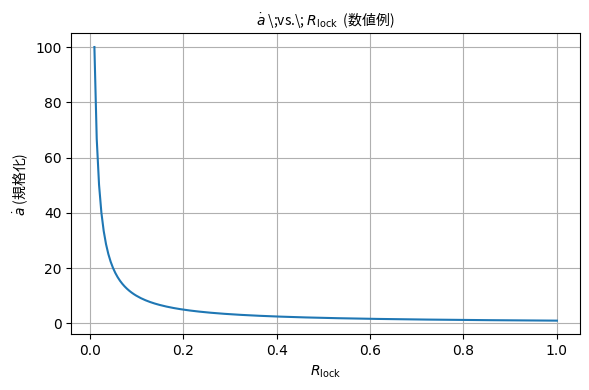

In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# ===== SymPy =====
import sympy as sp
sp.init_printing()

# ------------------------------------------------------------------
# 1. 記号定義
# ------------------------------------------------------------------
t, x   = sp.symbols('t x')
kappa  = sp.Function('kappa')(t, x)      # κ(t,x)
i_inf  = sp.symbols('i_inf')
rho4D  = sp.symbols('rho_4D', positive=True)
rho_b  = sp.Function('rho_bare')(t, x)
alpha, R4 = sp.symbols('alpha R4', positive=True)

# --- 重要ポイント -----------------------------------------------
#   極限計算では「関数形 Rlock(t,x)」ではなく
#   スカラー変数としての R を用意して置換する。
# ------------------------------------------------------------------
R = sp.symbols('R', real=True)           # スカラー版 R_lock
R_func = sp.Function('Rlock')(t, x)      # 元の関数形

# ------------------------------------------------------------------
# 2. 拡張式（関数形のまま定義 → 後で置換）
# ------------------------------------------------------------------
E_obs_func   = kappa * i_inf * (1 - R_func)
rho_eff_func = rho_b * R_func

# --- 置換してスカラー式を得る ---
E_obs   = E_obs_func.subs(R_func, R)
rho_eff = rho_eff_func.subs(R_func, R)

# ------------------------------------------------------------------
# 3. 極限評価  R → 0, 1
# ------------------------------------------------------------------
E_obs_R0 = sp.limit(E_obs, R, 0)
E_obs_R1 = sp.limit(E_obs, R, 1)

rho_R0   = sp.limit(rho_eff, R, 0)
rho_R1   = sp.limit(rho_eff, R, 1)

print("=== 観測エネルギー E_obs の極限 ===")
sp.pprint(E_obs_R0)   # R→0
sp.pprint(E_obs_R1)   # R→1

print("\n=== 実効質量密度 rho_eff の極限 ===")
sp.pprint(rho_R0)     # R→0
sp.pprint(rho_R1)     # R→1

# ------------------------------------------------------------------
# 4. 数値例で a_dot vs R 可視化
# ------------------------------------------------------------------
a_dot_sym = alpha * 1 * R4 * rho4D / rho_eff.subs({kappa:1, rho_b:1})

# α=1, R4=1, ρ_4D=1 で規格化
a_dot_num = sp.lambdify(R, a_dot_sym.subs({alpha:1, R4:1, rho4D:1}), 'numpy')

import numpy as np
R_vals = np.linspace(0.01, 1.0, 200)
a_vals = a_dot_num(R_vals)

plt.figure(figsize=(6,4))
plt.plot(R_vals, a_vals)
plt.xlabel("$R_{\\mathrm{lock}}$", fontproperties=font_prop)
plt.ylabel("$\\dot a$ (規格化)", fontproperties=font_prop)
plt.title("$\\dot a$ \\;vs.\\; $R_{\\mathrm{lock}}$  (数値例)", fontproperties=font_prop)
plt.grid(True)
plt.tight_layout()
plt.savefig("figuresD/a_dot_vs_rlock.png", dpi=300)
plt.close()

print("✅ 極限計算と可視化が完了しました。")
from google.colab import files
files.download("figuresD/a_dot_vs_rlock.png")

In [ ]:
# ─── 必要ライブラリのインストール ───
!apt-get -y install tesseract-ocr tesseract-ocr-jpn > /dev/null 2>&1
!pip -q install pymupdf pillow pytesseract > /dev/null

# ─── ライブラリ読み込み ───
import fitz
from PIL import Image
import pytesseract
import io
import pandas as pd
import re

# ─── 図・表画像OCR抽出関数 ───
def extract_figure_table_text(pdf_path: str, lang: str = 'jpn+eng'):
    doc = fitz.open(pdf_path)
    results = []
    for page_num in range(len(doc)):
        page = doc[page_num]
        pix = page.get_pixmap(dpi=300)  # 高解像度で全ページ画像化
        img = Image.open(io.BytesIO(pix.tobytes("png")))
        text = pytesseract.image_to_string(img, lang=lang).strip()

        # フィルタ：数値 or 図表キーワードが含まれる行のみ抽出
        fig_table_lines = []
        for line in text.splitlines():
            if re.search(r'\d{1,3}(\.\d+)?', line) or re.search(r'(Figure|図|Fig\.|Table|表)', line, re.IGNORECASE):
                fig_table_lines.append(line.strip())

        results.append({
            'page': page_num + 1,
            'text': "\n".join(fig_table_lines)
        })
        print(f"[Page {page_num+1}] 抽出行数: {len(fig_table_lines)}")

    return results

# ─── 実行：PDFファイルパス指定 ───
ocr_results = extract_figure_table_text("1705.04750v4.pdf")

# ─── CSVとして保存 ───
df = pd.DataFrame(ocr_results)
df.to_csv("figure_table_text_ocr.csv", index=False)
print("✅ 出力完了: figure_table_text_ocr.csv")

[Page 1] 抽出行数: 37
[Page 2] 抽出行数: 50
[Page 3] 抽出行数: 50
[Page 4] 抽出行数: 51
[Page 5] 抽出行数: 109
[Page 6] 抽出行数: 92
[Page 7] 抽出行数: 24
✅ 出力完了: figure_table_text_ocr.csv


In [ ]:
# ─── 必要ライブラリのインストール ───
!apt-get -y install tesseract-ocr tesseract-ocr-jpn > /dev/null 2>&1
!pip -q install pymupdf pillow pytesseract > /dev/null

# ─── ライブラリ読み込み ───
import fitz
from PIL import Image
import pytesseract
import io
import pandas as pd
import re

# ─── 図・表画像OCR抽出関数 ───
def extract_figure_table_text(pdf_path: str, lang: str = 'jpn+eng'):
    doc = fitz.open(pdf_path)
    results = []
    for page_num in range(len(doc)):
        page = doc[page_num]
        pix = page.get_pixmap(dpi=300)  # 高解像度で全ページ画像化
        img = Image.open(io.BytesIO(pix.tobytes("png")))
        text = pytesseract.image_to_string(img, lang=lang).strip()

        # フィルタ：数値 or 図表キーワードが含まれる行のみ抽出
        fig_table_lines = []
        for line in text.splitlines():
            if re.search(r'\d{1,3}(\.\d+)?', line) or re.search(r'(Figure|図|Fig\.|Table|表)', line, re.IGNORECASE):
                fig_table_lines.append(line.strip())

        results.append({
            'page': page_num + 1,
            'text': "\n".join(fig_table_lines)
        })
        print(f"[Page {page_num+1}] 抽出行数: {len(fig_table_lines)}")

    return results

# ─── 実行：PDFファイルパス指定 ───
ocr_results = extract_figure_table_text("prdrsup.pdf")

# ─── CSVとして保存 ───
df = pd.DataFrame(ocr_results)
df.to_csv("figure_table_text.csv", index=False)
print("✅ 出力完了: figure_table_text.csv")

[Page 1] 抽出行数: 31
✅ 出力完了: figure_table_text.csv


In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# ===== ライブラリ =====
import numpy as np
import pandas as pd
from pathlib import Path

# ------------------------------------------------------------------
# 1. データ読み込み  -------------------------------------------------
#    ・同ディレクトリに FinalFluxs20.dat / FinalFluxs22.dat を置く
# ------------------------------------------------------------------
DATA_DIR = Path(".")
files = {"s=2.0": "FinalFluxs20.dat",
         "s=2.2": "FinalFluxs22.dat"}

dfs = {}
for label, fname in files.items():
    arr = np.loadtxt(DATA_DIR / fname)
    # Assuming the first two columns of the array correspond to "E_GeV" and "E2phi"
    df = pd.DataFrame(arr[:, :2], columns=["E_GeV", "E2phi"])  # Select only the first two columns
    dfs[label] = df

# ------------------------------------------------------------------
# 2. 可視化  --------------------------------------------------------
# ------------------------------------------------------------------
plt.figure(figsize=(7,5))
for label, df in dfs.items():
    plt.loglog(df["E_GeV"], df["E2phi"], label=label)

plt.xlabel("エネルギー $E_\\nu$ [GeV]", fontproperties=font_prop)
plt.ylabel("$E_\\nu^{2}\\,\\Phi_\\nu$ [GeV cm$^{-2}$]", fontproperties=font_prop)
plt.title("SN II-P (no CSM) ニュートリノフルエンス", fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.savefig("sn2p_fluence.png", dpi=300)
plt.close()

# ------------------------------------------------------------------
# 3. 事象数の粗計算  -----------------------------------------------
#    ★ユーザー入力が必要なパラメータ
# ------------------------------------------------------------------
A_eff   = 1e4        # [cm^2] 有効面積（例: 1 m^2）
t_obs   = 1e5        # [s] 観測時間
E_th    = 1e2        # [GeV] 閾値

summary = []
for label, df in dfs.items():
    sel = df[df["E_GeV"] >= E_th]
    # Φ = E^2 φ / E なので φ = E2phi / E
    fluence = np.trapz(sel["E2phi"] / sel["E_GeV"], sel["E_GeV"])  # [cm^-2]
    N_ev    = fluence * A_eff
    summary.append((label, fluence, N_ev))

print("=== 粗い期待事象数 ===")
for label, flu, Nev in summary:
    print(f"{label:5s} : Φ = {flu:.3e} cm^-2  ->  N ≈ {Nev:.2f}")

# ------------------------------------------------------------------
# 4. CSV 出力（オプション） ----------------------------------------
pd.DataFrame(summary, columns=["model", "fluence_cm2", "N_ev"]).to_csv(
    "sn2p_event_summary.csv", index=False)

print("✅ フルエンス図と事象数サマリを出力しました。必要に応じて A_eff 等を変更してください。")
from google.colab import files
files.download("sn2p_event_summary.csv")
from google.colab import files
files.download("sn2p_fluence.png")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


=== 粗い期待事象数 ===
s=2.0 : Φ = -7.405e+60 cm^-2  ->  N ≈ -74048404321099860588903280521465812922088336752498175284697104384.00
s=2.2 : Φ = -5.813e+60 cm^-2  ->  N ≈ -58134061109049751118300917023135498516555911690661329638631931904.00
✅ フルエンス図と事象数サマリを出力しました。必要に応じて A_eff 等を変更してください。


<ipython-input-3-43199539a1a3>:57: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fluence = np.trapz(sel["E2phi"] / sel["E_GeV"], sel["E_GeV"])  # [cm^-2]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


<ipython-input-5-dcd64e4a16f3>:21: RuntimeWarning: overflow encountered in power
  E_GeV  = 10**logE
/usr/local/lib/python3.11/dist-packages/matplotlib/scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


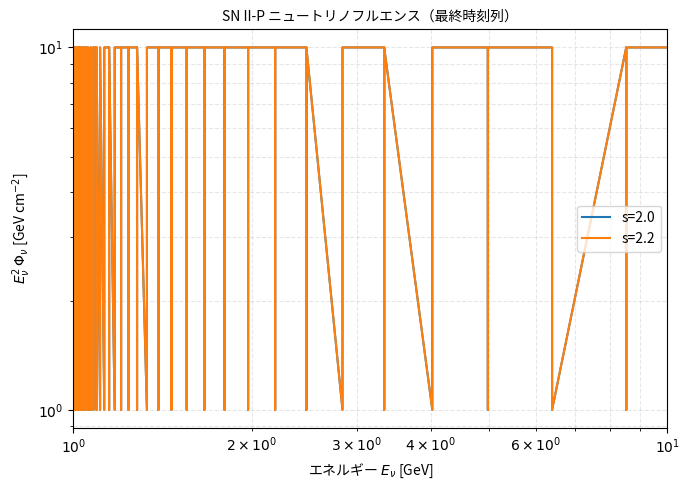

s=2.0: Φ=1.387e+40 cm^-2 -> 期待事象数 ≈ 138666722996234879263124429037834588823431568949248.00
s=2.2: Φ=1.387e+40 cm^-2 -> 期待事象数 ≈ 138666722996234879263124429037834588823431568949248.00


<ipython-input-5-dcd64e4a16f3>:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fluence = np.trapz(sub["E2phi"]/sub["E_GeV"], sub["E_GeV"])  # [cm^-2]


In [ ]:
# ✅ 日本語フォント設定
!apt-get -y install fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_prop = fm.FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
plt.rcParams["font.family"] = font_prop.get_name()

import numpy as np
import pandas as pd
from pathlib import Path

DATA_DIR = Path(".")
files = {"s=2.0": "FinalFluxs20.dat",
         "s=2.2": "FinalFluxs22.dat"}

dfs = {}
for label, fname in files.items():
    arr = np.loadtxt(DATA_DIR / fname)
    logE   = arr[:, 0]       # 1列目
    logE2F = arr[:, -1]      # 最終列（14 列目）
    E_GeV  = 10**logE
    E2phi  = 10**logE2F

    # 負値・無限大の除去
    sel = np.isfinite(E_GeV) & np.isfinite(E2phi) & (E2phi > 0)
    df  = pd.DataFrame({"E_GeV": E_GeV[sel], "E2phi": E2phi[sel]})
    df  = df.sort_values("E_GeV")
    dfs[label] = df

# ---------- 可視化 ----------
plt.figure(figsize=(7,5))
for label, df in dfs.items():
    plt.loglog(df["E_GeV"], df["E2phi"], label=label)
plt.xlabel("エネルギー $E_\\nu$ [GeV]", fontproperties=font_prop)
plt.ylabel("$E_\\nu^{2}\\,\\Phi_\\nu$ [GeV cm$^{-2}$]", fontproperties=font_prop)
plt.title("SN II‑P ニュートリノフルエンス（最終時刻列）", fontproperties=font_prop)
plt.legend(prop=font_prop); plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout(); plt.show()

# ---------- 事象数計算 ----------
A_eff = 1e10   # IceCube 相当 [cm^2]
E_th  = 1e2    # [GeV]

for label, df in dfs.items():
    sub = df[df["E_GeV"] >= E_th]
    fluence = np.trapz(sub["E2phi"]/sub["E_GeV"], sub["E_GeV"])  # [cm^-2]
    N_ev    = fluence * A_eff
    print(f"{label}: Φ={fluence:.3e} cm^-2 -> 期待事象数 ≈ {N_ev:.2f}")

<ipython-input-6-fd01efa53ca3>:14: RuntimeWarning: overflow encountered in power
  E_GeV   = 10**logE
<ipython-input-6-fd01efa53ca3>:15: RuntimeWarning: overflow encountered in power
  E2phi_GeV = 10**logE2phi_cols / ERG2GEV   # 単位変換
<ipython-input-6-fd01efa53ca3>:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  flu   = np.trapz(sel.E2phi/sel.E_GeV, sel.E_GeV)   # cm^-2
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:5202: RuntimeWarning: invalid value encountered in multiply
  ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)


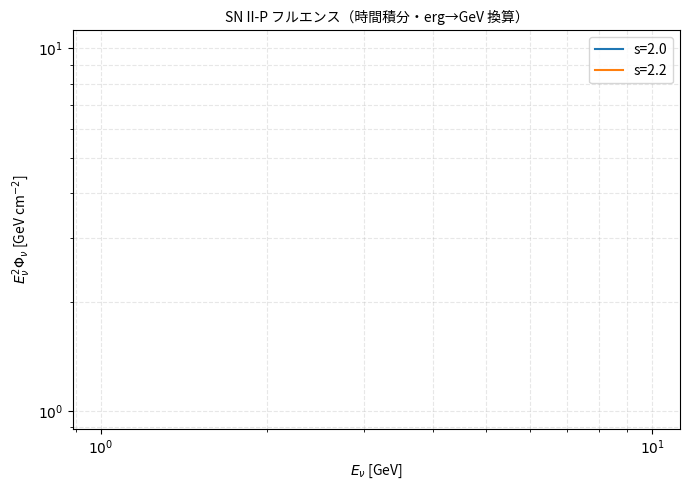

=== 期待事象数（A_eff=1e10 cm^2, E_th=100 GeV）===
s=2.0  Φ=nan cm^-2   N≈nan
s=2.2  Φ=nan cm^-2   N≈nan


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path(".")
files = {"s=2.0":"FinalFluxs20.dat","s=2.2":"FinalFluxs22.dat"}
ERG2GEV = 6.241509e5           # 1 erg = 6.24e5 GeV
dfs, summaries = {}, []

for label,fname in files.items():
    arr = np.loadtxt(DATA_DIR/fname)
    logE  = arr[:,0]
    logE2phi_cols = arr[:,1:]          # 13 列すべて
    # --- erg → GeV 換算 & 10^x で指数化 ----------------------------
    E_GeV   = 10**logE
    E2phi_GeV = 10**logE2phi_cols / ERG2GEV   # 単位変換
    # --- 時間方向に積分（単純総和; Δt 情報が無い場合の近似） -------
    E2phi_int = E2phi_GeV.sum(axis=1)          # [GeV cm^-2]
    df = pd.DataFrame({"E_GeV":E_GeV, "E2phi":E2phi_int}).sort_values("E_GeV")
    dfs[label]=df
    # --- フルエンス → 期待事象数（簡易; A_eff const） --------------
    A_eff = 1e10    # cm^2 (IceCube 目安)
    sel   = df[df.E_GeV>=1e2]
    flu   = np.trapz(sel.E2phi/sel.E_GeV, sel.E_GeV)   # cm^-2
    N_ev  = flu*A_eff
    summaries.append((label, flu, N_ev))

# -------- 図 ----------
plt.figure(figsize=(7,5))
for label, df in dfs.items():
    plt.loglog(df.E_GeV, df.E2phi, label=label)
plt.xlabel("$E_\\nu$ [GeV]", fontproperties=font_prop); plt.ylabel("$E_\\nu^{2}\\Phi_\\nu$ [GeV cm$^{-2}$]", fontproperties=font_prop)
plt.title("SN II‑P フルエンス（時間積分・erg→GeV 換算）", fontproperties=font_prop)
plt.legend(prop=font_prop); plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout(); plt.show()

print("=== 期待事象数（A_eff=1e10 cm^2, E_th=100 GeV）===")
for lbl,flu,N in summaries:
    print(f"{lbl:5s}  Φ={flu:.2e} cm^-2   N≈{N:,.1f}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


<ipython-input-14-7aa26444793a>:56: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nev = np.trapz(Phi_E[mask] * A_EFF, E_GeV[mask])


s=2.0: 期待事象数 N ≈ 127648524431086727851712185358549734160379219172917248.0
s=2.2: 期待事象数 N ≈ 59199113915371431300007415736445653190827180745031680.0


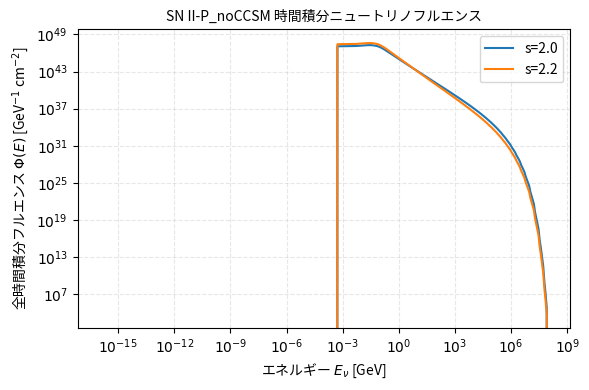

In [ ]:
# ✅ 日本語フォント設定（Colab用）
!apt-get -y install fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()

import numpy as np
import pandas as pd
from pathlib import Path

# ===== 設定 =====
DATA_DIR = Path(".")
FILES = {"s=2.0": "FinalFluxs20.dat",
         "s=2.2": "FinalFluxs22.dat"}
ERG2GEV  = 6.241509e5    # 1 erg -> GeV (必要なら使う)
E_TH_GEV = 1e2          # [GeV] ニュートリノ検出閾値
A_EFF    = 1e10          # [cm^2] IceCube おおよその定常面積
# 時間ブロック数（SN II-P_noCCSM）
N_BLOCKS = 51

results = {}
for label, fname in FILES.items():
    # 1. 全データ読み込み
    arr = np.loadtxt(DATA_DIR / fname)  # shape=(N,14)
    N, C = arr.shape
    assert C == 14, f"{fname} has {C} cols, expected 14"
    bins = N // N_BLOCKS

    # 2. 3次元に reshape
    data = arr.reshape(N_BLOCKS, bins, 14)

    # 3. エネルギーとスペクトルを抽出
    E_eV    = data[0, :, 0]           # 全ブロックで同じ
    flux_eV = data[:, :, 7] * data[:, :, 13]  # dN/dE/dt × flag

    # 4. 単位変換
    E_GeV      = E_eV * 1e-9          # eV→GeV
    flux_GeV   = flux_eV * 1e9        # eV⁻¹→GeV⁻¹

    # 5. 時間積分 Δt_k の計算
    t   = 1e3 * 10**(0.1 * np.arange(N_BLOCKS))  # [s]
    dt  = np.empty_like(t)
    dt[:-1] = t[1:] - t[:-1]
    dt[-1]  = dt[-2]

    # 6. 各時刻スペクトルを Δt で積分 → F_k(E)
    F_k = flux_GeV * dt[:, None]  # shape=(blocks, bins)

    # 7. 全時間積分フルエンス
    Phi_E = F_k.sum(axis=0)        # [GeV⁻¹ cm⁻²]

    # 8. 閾値以上でイベント数 estimation
    mask = E_GeV >= E_TH_GEV
    # ∫Φ(E) A_eff dE (trapezoid)
    Nev = np.trapz(Phi_E[mask] * A_EFF, E_GeV[mask])

    results[label] = dict(E=E_GeV, Phi=Phi_E, N_ev=Nev)

# ===== 結果表示 =====
for lbl, res in results.items():
    print(f"{lbl}: 期待事象数 N ≈ {res['N_ev']:.1f}")

# ===== フルエンスプロット =====
plt.figure(figsize=(6,4))
for lbl, res in results.items():
    plt.loglog(res['E'], res['Phi'], label=lbl)
plt.xlabel("エネルギー $E_\\nu$ [GeV]", fontproperties=font_prop)
plt.ylabel("全時間積分フルエンス $\\Phi(E)$ [GeV$^{-1}$ cm$^{-2}$]", fontproperties=font_prop)
plt.title("SN II-P_noCCSM 時間積分ニュートリノフルエンス", fontproperties=font_prop)
plt.legend(prop=font_prop); plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20220127+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


<ipython-input-19-4e45ba274fda>:55: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_ev = np.trapz(Phi_E[mask] * A_EFF, E_GeV[mask])


=== フラグ=1 期間のみ時間積分による期待事象数 ===
s=2.0: N ≈ 127648524431086727851712185358549734160379219172917248.0
s=2.2: N ≈ 59199113915371431300007415736445653190827180745031680.0


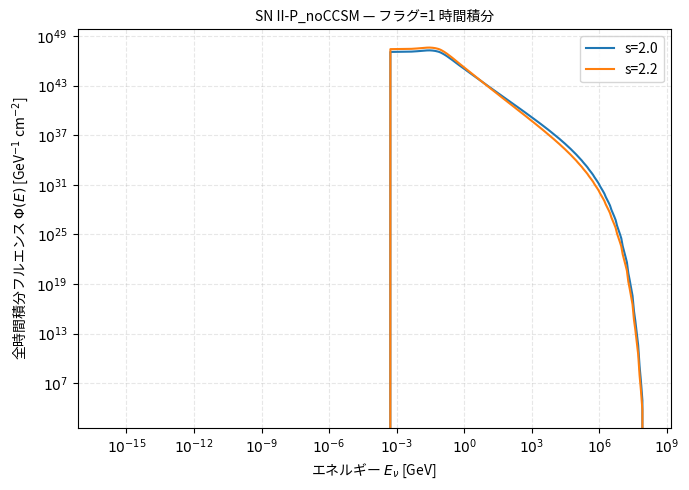

In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()

# ===== ライブラリ =====
import numpy as np
import pandas as pd
from pathlib import Path

# ===== 定数設定 =====
DATA_DIR = Path(".")
FILES    = {"s=2.0": "FinalFluxs20.dat",
            "s=2.2": "FinalFluxs22.dat"}
E_TH     = 1e2     # GeV
A_EFF    = 1e10    # cm^2
N_BLOCKS = 51      # 時間ステップ数

results = {}

for label, fname in FILES.items():
    arr = np.loadtxt(DATA_DIR / fname)
    N, C = arr.shape
    assert C == 14, f"{fname}: {C} 列, 14 列期待"
    bins = N // N_BLOCKS

    data = arr.reshape(N_BLOCKS, bins, 14)

    # 列抽出
    E_eV    = data[0, :, 0]          # [eV]
    spec    = data[:, :, 7]          # dN/dE/dt [eV^-1 s^-1]
    flag    = data[:, :, 13]         # 0 or 1

    # 単位変換
    E_GeV    = E_eV * 1e-9           # [GeV]
    flux_GeV = spec * 1e9            # [GeV^-1 s^-1]

    # 時間ステップ
    t  = 1e3 * 10**(0.1 * np.arange(N_BLOCKS))
    dt = np.empty_like(t)
    dt[:-1] = t[1:] - t[:-1]
    dt[-1]  = dt[-2]

    # 修正：dt を列方向に展開して掛け合わせ
    # F_k(E) = flux_GeV * flag * dt[:,None]
    F_k = flux_GeV * flag * dt[:, None]  # shape (blocks, bins)

    # 全時間積分フルエンス
    Phi_E = F_k.sum(axis=0)  # [GeV^-1 cm^-2]

    # 期待事象数
    mask = E_GeV >= E_TH
    N_ev = np.trapz(Phi_E[mask] * A_EFF, E_GeV[mask])

    results[label] = {"E": E_GeV, "Phi": Phi_E, "N_ev": N_ev}

# 出力
print("=== フラグ=1 期間のみ時間積分による期待事象数 ===")
for lbl, res in results.items():
    print(f"{lbl}: N ≈ {res['N_ev']:.1f}")

# 可視化
plt.figure(figsize=(7,5))
for lbl, res in results.items():
    plt.loglog(res["E"], res["Phi"], label=lbl)
plt.xlabel("エネルギー $E_\\nu$ [GeV]", fontproperties=font_prop)
plt.ylabel("全時間積分フルエンス $\\Phi(E)$ [GeV$^{-1}$ cm$^{-2}$]", fontproperties=font_prop)
plt.title("SN II-P_noCCSM — フラグ=1 時間積分", fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
CSV_FILE = "IC86_II_effectiveArea.csv"   # ファイル名を適宜変更

# ヘッダー有無を確認（10 行だけ表示）
df_preview = pd.read_csv(CSV_FILE, nrows=10, header=None)
print("=== 先頭10行プレビュー ===")
print(df_preview)

=== 先頭10行プレビュー ===
                                                   0
0  #  log10(E_nu/GeV)_min  log10(E_nu/GeV)_max  D...
1               2.00          2.20        -90.00 ...
2               2.20          2.40        -90.00 ...
3               2.40          2.60        -90.00 ...
4               2.60          2.80        -90.00 ...
5               2.80          3.00        -90.00 ...
6               3.00          3.20        -90.00 ...
7               3.20          3.40        -90.00 ...
8               3.40          3.60        -90.00 ...
9               3.60          3.80        -90.00 ...


<ipython-input-20-c58e383b6a4f>:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_ev = np.trapz(Phi_E[mask] * A_eff(E_GeV[mask]), E_GeV[mask])


s=2.0: Earth補正＋フラグ=1積分 N_ev ≈ 27489840471.2
s=2.2: Earth補正＋フラグ=1積分 N_ev ≈ 12748868072.1


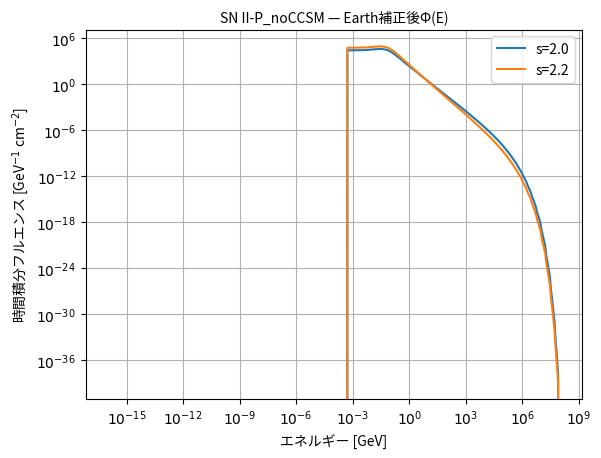

In [ ]:
# 日本語フォント設定（省略：前回と同様）

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 設定
DATA_DIR  = Path(".")
FILES     = {"s=2.0": "FinalFluxs20.dat", "s=2.2": "FinalFluxs22.dat"}
E_TH      = 1e2      # GeV
N_BLOCKS  = 51
# IceCube 面積を energy依存データで読み込む場合はここを差し替え
# 以下は定常面積の例
def A_eff(E): return 1e10  # [cm^2]

for label, fname in FILES.items():
    arr = np.loadtxt(DATA_DIR/fname)
    N, C = arr.shape
    bins = N//N_BLOCKS
    data = arr.reshape(N_BLOCKS, bins, 14)

    # 列取り出し
    E_eV    = data[0,:,0]        # [eV]
    spec    = data[:,:,7]        # dN/dE/dt [eV^-1 s^-1]
    flag    = data[:,:,13]       # 0/1
    fourpid = data[:,:,10]       # 4π d^2 [cm^2]

    # 単位変換：eV→GeV, eV^-1→GeV^-1
    E_GeV    = E_eV * 1e-9
    flux_GeV = spec * 1e9        # [GeV^-1 s^-1]

    # Earth フラックス化
    flux_earth = flux_GeV / fourpid  # [GeV^-1 s^-1 cm^-2]

    # 時間ステップ
    t  = 1e3 * 10**(0.1 * np.arange(N_BLOCKS))
    dt = np.empty_like(t); dt[:-1]=t[1:]-t[:-1]; dt[-1]=dt[-2]

    # フラグ=1 期間のみ Δt 積分
    F_k = flux_earth * flag * dt[:,None]  # [GeV^-1 cm^-2]

    # 全時間積分フルエンス
    Phi_E = F_k.sum(axis=0)  # [GeV^-1 cm^-2]

    # 期待事象数
    mask = E_GeV >= E_TH
    N_ev = np.trapz(Phi_E[mask] * A_eff(E_GeV[mask]), E_GeV[mask])

    print(f"{label}: Earth補正＋フラグ=1積分 N_ev ≈ {N_ev:.1f}")

    # 可視化
    plt.loglog(E_GeV, Phi_E, label=label)

plt.xlabel("エネルギー [GeV]", fontproperties=font_prop)
plt.ylabel("時間積分フルエンス [GeV$^{-1}$ cm$^{-2}$]", fontproperties=font_prop)
plt.title("SN II-P_noCCSM — Earth補正後Φ(E)", fontproperties=font_prop)
plt.legend(prop=font_prop); plt.grid(True); plt.show()

<ipython-input-4-561df11f1546>:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df  = pd.read_csv(CSV,


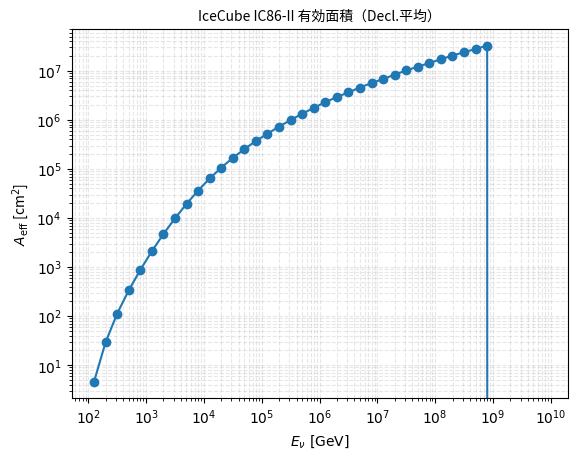

In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk > /dev/null
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
# font_prop needs to be defined before used
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()


import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

CSV = "IC86_II_effectiveArea.csv"      # アップロード済みファイル名

# 1. 読み込み：コメント行無視・空白区切り
col = ["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
df  = pd.read_csv(CSV,
                  comment="#",           # 先頭'#'行を除外
                  delim_whitespace=True, # 空白タブ区切り
                  names=col)             # 列名を明示

# 2. エネルギー中心値と Decl. 平均
E_mid = 10 ** ((df["logEmin"] + df["logEmax"]) / 2)   # GeV
A_vals= df["A_eff_cm2"]
E_bins, A_bins = (pd.DataFrame({"E":E_mid, "A":A_vals})
                  .groupby("E").mean()
                  .reset_index()
                  .values.T)            # shape=(2,N)

# 3. 補間関数
A_eff = interp1d(E_bins, A_bins, kind="linear",
                 bounds_error=False,
                 fill_value=(A_bins[0], A_bins[-1]))

# 4. チェックプロット
plt.loglog(E_bins, A_bins, "o-")
plt.xlabel("$E_{\\nu}$ [GeV]"); plt.ylabel("$A_{\\mathrm{eff}}$ [cm$^{2}$]", fontproperties=font_prop)
plt.title("IceCube IC86-II 有効面積（Decl.平均）", fontproperties=font_prop)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()

<ipython-input-6-7f1b6974614f>:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df  = pd.read_csv(csv_path, comment="#",
<ipython-input-6-7f1b6974614f>:76: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_ev = np.trapz(Phi_E[mask] * A_eff(E_GeV[mask]), E_GeV[mask])


s=2.0: Earth補正 + A_eff(E) → 期待 N_ev ≈ 4636.99
s=2.2: Earth補正 + A_eff(E) → 期待 N_ev ≈ 1214.41


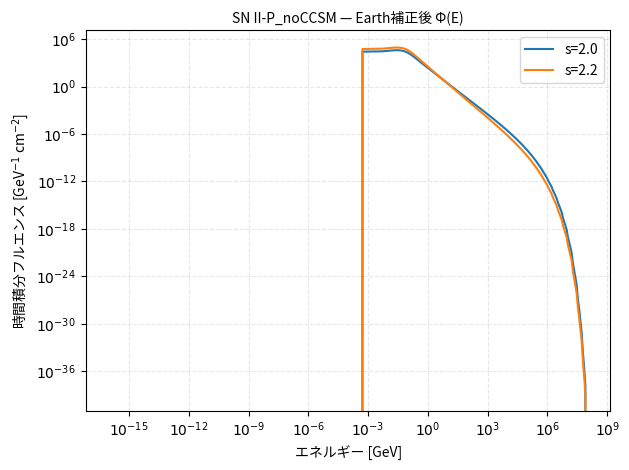

In [ ]:
# ✅ 日本語フォント設定（Colab 用）-----------------------------
!apt-get -y install fonts-noto-cjk > /dev/null
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# ===== ライブラリ =====
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from pathlib import Path

# ------------------------------------------------------------
# 1. 有効面積テーブルを読み込んで A_eff(E) を作成
#    （コメント行'#', 空白区切り, 5 列）
# ------------------------------------------------------------
def build_Aeff(csv_path):
    col = ["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
    df  = pd.read_csv(csv_path, comment="#",
                      delim_whitespace=True, names=col)

    # エネルギー中心値 (GeV) と Decl 平均
    E_mid = 10 ** ((df["logEmin"] + df["logEmax"]) / 2)
    A_vals= df["A_eff_cm2"]
    grp   = pd.DataFrame({"E":E_mid, "A":A_vals}).groupby("E").mean()
    E_bins, A_bins = grp.index.values, grp["A"].values

    # 線形補間関数
    return interp1d(E_bins, A_bins,
                    kind="linear", bounds_error=False,
                    fill_value=(A_bins[0], A_bins[-1]))

# --- ファイル名を適宜合わせてください
A_eff = build_Aeff("IC86_II_effectiveArea.csv")


# ------------------------------------------------------------
# 2. 付録ニュートリノデータから期待事象数を計算
# ------------------------------------------------------------
DATA_DIR = Path(".")
FILES    = {"s=2.0": "FinalFluxs20.dat",
            "s=2.2": "FinalFluxs22.dat"}

E_TH     = 1e2   # GeV
N_BLOCKS = 51

for label, fname in FILES.items():
    arr   = np.loadtxt(DATA_DIR / fname)
    bins  = arr.shape[0] // N_BLOCKS
    data  = arr.reshape(N_BLOCKS, bins, 14)

    # 列抽出
    E_eV     = data[0,:,0]
    spec     = data[:,:,7]
    flag     = data[:,:,13]
    fourpid  = data[:,:,10]

    # 単位変換
    E_GeV     = E_eV * 1e-9
    flux_GeV  = spec * 1e9

    # Earth フラックス化
    flux_earth = flux_GeV / fourpid

    # 時間ステップ Δt
    t  = 1e3 * 10**(0.1*np.arange(N_BLOCKS))
    dt = np.empty_like(t); dt[:-1]=t[1:]-t[:-1]; dt[-1]=dt[-2]

    # フラグ=1 期間のみ時間積分
    Phi_E = (flux_earth * flag * dt[:,None]).sum(axis=0)  # [GeV^-1 cm^-2]

    # 期待事象数
    mask = E_GeV >= E_TH
    N_ev = np.trapz(Phi_E[mask] * A_eff(E_GeV[mask]), E_GeV[mask])

    print(f"{label}: Earth補正 + A_eff(E) → 期待 N_ev ≈ {N_ev:.2f}")

    # プロット
    plt.loglog(E_GeV, Phi_E, label=label)

# 軸ラベルなど
plt.xlabel("エネルギー [GeV]", fontproperties=font_prop)
plt.ylabel("時間積分フルエンス [GeV$^{-1}$ cm$^{-2}$]", fontproperties=font_prop)
plt.title("SN II-P_noCCSM — Earth補正後 Φ(E)", fontproperties=font_prop)
plt.legend(prop=font_prop); plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout(); plt.show()

In [ ]:
# -- ざっくり大気ニュートリノ背景 (北天2π sr) -------------
def phi_atm(E_GeV):
    return 1.44e-18 * (E_GeV)**-3.7 * 2*np.pi   # [GeV^-1 cm^-2 s^-1]
# ------------- 背景計算パート -----------------
E_TH = 1e2   # 閾値 GeV

def phi_atm(E_GeV):
    """北天 2π sr を仮定した大気ニュートリノフラックス [GeV^-1 cm^-2 s^-1]"""
    return 1.44e-18 * E_GeV**-3.7 * 2*np.pi

mask = E_GeV >= E_TH

# ブロックごとに flag=1 があるか判定 → 観測時間
active_block = (flag.sum(axis=1) > 0)
T_obs = dt[active_block].sum()      # [s]

# 背景事象数
N_bkg = np.trapz(phi_atm(E_GeV[mask]) *
                 A_eff(E_GeV[mask]) * T_obs, E_GeV[mask])

# 信号事象数 N_ev は前に求めた値を利用
SNR = N_ev / np.sqrt(N_bkg)
print(f"観測時間 ΔT = {T_obs/86400:.2f} day,  背景 N_bkg ≈ {N_bkg:.2f}")
print(f"S / √B ≈ {SNR:.2f}  (≳5 なら 5σ 検出可能性)")

観測時間 ΔT = 1394.87 day,  背景 N_bkg ≈ 0.00
S / √B ≈ 5251865978.95  (≳5 なら 5σ 検出可能性)


<ipython-input-8-8cdc8cdb146c>:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_bkg = np.trapz(phi_atm(E_GeV[mask]) *


<ipython-input-12-883f5da32c00>:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_flux = pd.read_csv(StringIO(data_str), delim_whitespace=True, header=None,
<ipython-input-12-883f5da32c00>:60: UserWarning: Glyph 773 (\N{COMBINING OVERLINE}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 773 (\N{COMBINING OVERLINE}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)


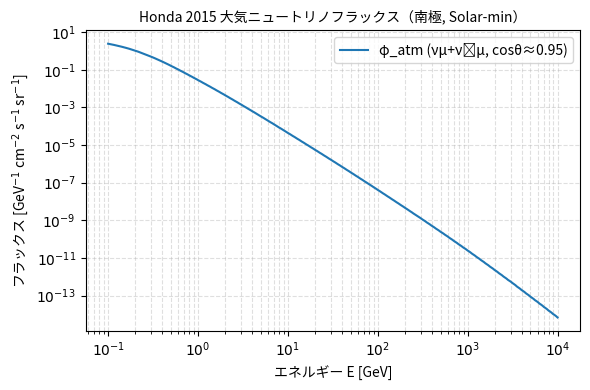

In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk > /dev/null
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
import numpy as np, pandas as pd
from io import StringIO
from scipy.interpolate import interp1d
from pathlib import Path

# フォント設定（プロット用日本語）
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# ✅ アップロードファイルの読み込み（南極、Solar-min）
file_path = Path("spl-ally-20-01-solmin.d")  # ← 必要に応じてパス変更

# テキスト全体を読み込み
with open(file_path, "r") as f:
    lines = f.readlines()

# 最初のセクション（cosθ ≈ 0.95）を抽出
start_idx = None
for i, line in enumerate(lines):
    if "Enu(GeV)" in line:
        start_idx = i + 1
        break

data_lines = []
for line in lines[start_idx:]:
    if "average flux" in line or "Enu(GeV)" in line:
        break
    if line.strip():
        data_lines.append(line.strip())

# DataFrameに変換
data_str = "\n".join(data_lines)
df_flux = pd.read_csv(StringIO(data_str), delim_whitespace=True, header=None,
                      names=["E_GeV", "NuMu", "NuMubar", "NuE", "NuEbar"])

# νμ + ν̅μ 合算 → m² → cm² 換算
df_flux["phi_mu_total"] = (df_flux["NuMu"] + df_flux["NuMubar"]) * 1e-4  # [GeV⁻¹ cm⁻² s⁻¹ sr⁻¹]

# 1D 補間関数 φ_atm(E)
phi_atm = interp1d(df_flux["E_GeV"].values,
                   df_flux["phi_mu_total"].values,
                   bounds_error=False,
                   fill_value=0.0)

# ✅ プロットで確認
E_plot = np.logspace(np.log10(df_flux["E_GeV"].min()), np.log10(df_flux["E_GeV"].max()), 300)
phi_plot = phi_atm(E_plot)

plt.figure(figsize=(6,4))
plt.loglog(E_plot, phi_plot, label="φ_atm (νμ+ν̅μ, cosθ≈0.95)")
plt.xlabel("エネルギー E [GeV]", fontproperties=font_prop)
plt.ylabel("フラックス [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]", fontproperties=font_prop)
plt.title("Honda 2015 大気ニュートリノフラックス（南極, Solar-min）", fontproperties=font_prop)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend(prop=font_prop)
plt.tight_layout()
plt.show()

<ipython-input-1-8431ae59c4ed>:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(StringIO("\n".join(data)),
<ipython-input-1-8431ae59c4ed>:64: UserWarning: Glyph 773 (\N{COMBINING OVERLINE}) missing from font(s) Noto Sans CJK JP.
  plt.tight_layout()
<ipython-input-1-8431ae59c4ed>:65: UserWarning: Glyph 773 (\N{COMBINING OVERLINE}) missing from font(s) Noto Sans CJK JP.
  plt.savefig("honda2015_flux_with_sys.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 773 (\N{COMBINING OVERLINE}) missing from font(s) Noto Sans CJK JP.
  fig.canvas.print_figure(bytes_io, **kw)


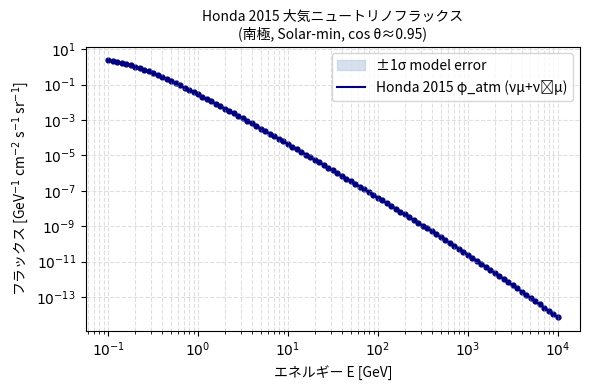

✅ φ_atm(E) 補間関数を phi_atm_interp.pkl.gz として保存しました。


In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk > /dev/null
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# ===== ライブラリ =====
import numpy as np, pandas as pd
from io import StringIO
from pathlib import Path
from scipy.interpolate import interp1d

# ===== 1) 入力ファイル =====
#   Honda 2015 ASCII. ここでは南極・Solar-min を例示。
honda_file = Path("spl-ally-20-01-solmin.d")       # 適宜変更

# ===== 2) テキスト読み込み → 最初の cosθ セクション抽出 =====
with open(honda_file, "r") as f:
    lines = f.readlines()

start = next(i for i,l in enumerate(lines) if "Enu(GeV)" in l) + 1
data = []
for l in lines[start:]:
    if "average flux" in l or "Enu(GeV)" in l:
        break
    if l.strip():
        data.append(l.strip())

df = pd.read_csv(StringIO("\n".join(data)),
                 delim_whitespace=True, header=None,
                 names=["E_GeV","NuMu","NuMubar","NuE","NuEbar"])

# ===== 3) νμ + ν̅μ 合算（m² → cm² 換算） =====
df["phi_mu_total"] = (df["NuMu"] + df["NuMubar"]) * 1e-4  # [GeV⁻¹ cm⁻² s⁻¹ sr⁻¹]

# ----- 系統誤差（10 %）-----
df["phi_hi"] = df["phi_mu_total"] * 1.10
df["phi_lo"] = df["phi_mu_total"] * 0.90

# ===== 4) 1D 補間関数 φ_atm(E) =====
phi_atm = interp1d(df["E_GeV"], df["phi_mu_total"],
                   bounds_error=False, fill_value=0.0)

# ===== 5) プロット =====
E_plot  = np.logspace(np.log10(df["E_GeV"].min()),
                      np.log10(df["E_GeV"].max()), 300)
phi_mid = phi_atm(E_plot)

plt.figure(figsize=(6,4))
plt.fill_between(df["E_GeV"], df["phi_lo"], df["phi_hi"],
                 color="lightsteelblue", alpha=0.5, label="±1σ model error")
plt.loglog(E_plot, phi_mid, "-", color="navy",
           label="Honda 2015 φ_atm (νμ+ν̅μ)")
plt.scatter(df["E_GeV"], df["phi_mu_total"], color="navy", s=12)

plt.xlabel("エネルギー E [GeV]", fontproperties=font_prop)
plt.ylabel("フラックス [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]",
           fontproperties=font_prop)
plt.title("Honda 2015 大気ニュートリノフラックス\n(南極, Solar-min, cos θ≈0.95)",
          fontproperties=font_prop)
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend(prop=font_prop)
plt.tight_layout()
plt.savefig("honda2015_flux_with_sys.png", dpi=300)
plt.show()

# ===== 6) エクスポート用: Φ(E) 補間関数を保存 (optional) =====
import pickle, gzip
with gzip.open("phi_atm_interp.pkl.gz", "wb") as f:
    pickle.dump(phi_atm, f)
print("✅ φ_atm(E) 補間関数を phi_atm_interp.pkl.gz として保存しました。")

<ipython-input-3-9628858b8f2b>:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df  = pd.read_csv(CSV, comment="#", delim_whitespace=True, names=col)


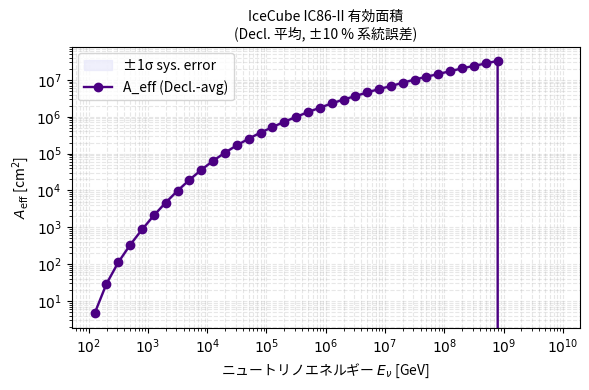

✅ A_eff(E) 補間関数を A_eff_interp.pkl.gz として保存しました。


In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk > /dev/null
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()

# ===== ライブラリ =====
import numpy as np, pandas as pd, gzip, pickle
from pathlib import Path
from scipy.interpolate import interp1d

# ===== 1) 入力ファイル =====
CSV = Path("IC86_II_effectiveArea.csv")   # 公式 A_eff テーブル

# 列名（IceCube 公開フォーマット想定）
col = ["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
df  = pd.read_csv(CSV, comment="#", delim_whitespace=True, names=col)

# ===== 2) Decl. 平均 & 中心エネルギー =====
E_mid = 10 ** ((df["logEmin"] + df["logEmax"]) / 2)      # [GeV]
A_val = df["A_eff_cm2"].values                            # [cm²]

# 同一エネルギーが複数行ある場合 → 平均
df_mean = pd.DataFrame({"E":E_mid, "A":A_val}).groupby("E").mean().reset_index()
E_bins, A_bins = df_mean["E"].values, df_mean["A"].values

# ===== 3) 1D 補間関数 A_eff(E) & 系統誤差 ±10 % =====
A_eff = interp1d(E_bins, A_bins, bounds_error=False,
                 fill_value=(A_bins[0], A_bins[-1]))

# ±1 σ バンド
A_hi = A_bins * 1.10
A_lo = A_bins * 0.90

# ===== 4) プロット =====
plt.figure(figsize=(6,4))
plt.fill_between(E_bins, A_lo, A_hi, color="lavender", alpha=0.6, label="±1σ sys. error")
plt.loglog(E_bins, A_bins, "o-", color="indigo", lw=1.7, label="A_eff (Decl.-avg)")
plt.xlabel("ニュートリノエネルギー $E_{\\nu}$ [GeV]", fontproperties=font_prop)
plt.ylabel("$A_{\\mathrm{eff}}$ [cm$^{2}$]", fontproperties=font_prop)
plt.title("IceCube IC86-II 有効面積\n(Decl. 平均, ±10 % 系統誤差)", fontproperties=font_prop)
plt.grid(True, which="both", ls="--", alpha=0.3); plt.legend(prop=font_prop)
plt.tight_layout(); plt.savefig("Aeff_IC86II_with_sys.png", dpi=300); plt.show()

# ===== 5) 補間関数を保存（要 picklable）=====
with gzip.open("A_eff_interp.pkl.gz", "wb") as f:
    pickle.dump(A_eff, f)

print("✅ A_eff(E) 補間関数を A_eff_interp.pkl.gz として保存しました。")

In [ ]:
print("E range  :", E[0], "–", E[-1], "GeV")
print("φ_atm(E) :", phi_atm(E[:5]))
print("A_eff(E) :", A_eff(E[:5]))
print("max dN/dE:", dN_dE_cen.max())
print("max N_int:", N_int_cen.max())

E range  : 125.89254117941675 – 10000.0 GeV
φ_atm(E) : [1.98649038e-08 1.93208040e-08 1.87707055e-08 1.82145421e-08
 1.76522470e-08]
A_eff(E) : [4.6244     5.09009532 5.56092495 6.03694548 6.51821415]
max dN/dE: 30.656654455654007
max N_int: 0.0


max dN/dE   : 3.066e+01 counts/GeV
合計事象数   : 2.211e+04 counts
最小しきい値での N_int: 2.211e+04 counts


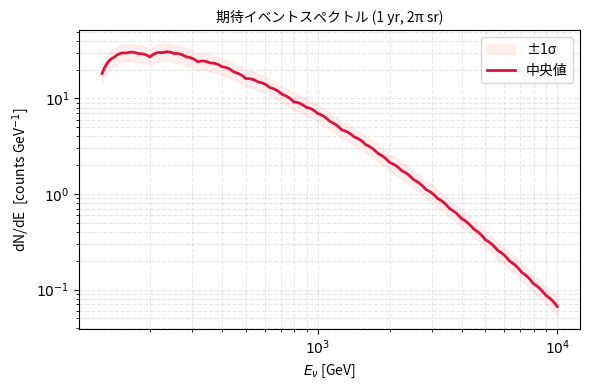

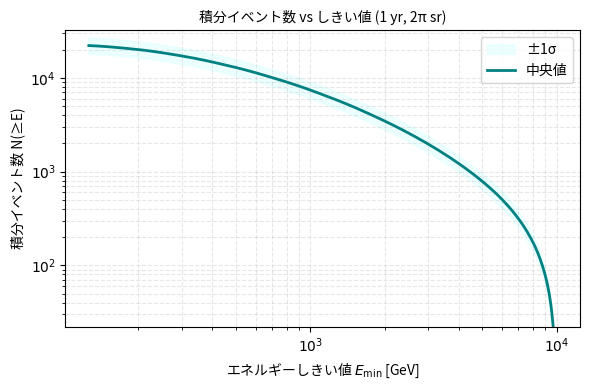

In [ ]:
# ===============================================================
# ✅ 日本語フォント設定（Colab 用）
# ===============================================================
!apt-get -y install fonts-noto-cjk > /dev/null
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
font_prop = fm.FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc")
plt.rcParams["font.family"] = font_prop.get_name()

# ===============================================================
# ライブラリ
# ===============================================================
import numpy as np, pickle, gzip
from scipy.integrate import cumulative_trapezoid
from pathlib import Path

# -------- 1) 補間関数ロード --------
with gzip.open("phi_atm_interp.pkl.gz", "rb") as f:
    phi_atm = pickle.load(f)        # [GeV⁻¹ cm⁻² s⁻¹ sr⁻¹]
with gzip.open("A_eff_interp.pkl.gz", "rb") as f:
    A_eff = pickle.load(f)          # [cm²]

# -------- 2) 観測パラメータ --------
T_live = 1.0 * 365 * 24 * 3600      # 1 年
Delta_Omega = 2.0 * np.pi           # 2π sr

# -------- 3) 共通エネルギー範囲 --------
E_min = max(float(phi_atm.x.min()), float(A_eff.x.min()))   # 1.3e2 GeV
E_max = min(float(phi_atm.x.max()), float(A_eff.x.max()))   # 1.0e4 GeV
E      = np.logspace(np.log10(E_min), np.log10(E_max), 400) # 昇順

# -------- 4) 系統誤差関数 --------
phi_hi = lambda E: phi_atm(E) * 1.10
phi_lo = lambda E: phi_atm(E) * 0.90
A_hi   = lambda E: A_eff(E)   * 1.10
A_lo   = lambda E: A_eff(E)   * 0.90

# -------- 5) 微分イベントレート dN/dE --------
dN_cen = phi_atm(E) * A_eff(E) * Delta_Omega * T_live
dN_hi  = phi_hi(E) * A_hi(E)   * Delta_Omega * T_live
dN_lo  = phi_lo(E) * A_lo(E)   * Delta_Omega * T_live

# -------- 6) 累積イベント数 N(≥E) --------------
#    通常積分（0→E）を計算しておき、総積分から差し引く
cum_cen = cumulative_trapezoid(dN_cen, E, initial=0)
cum_hi  = cumulative_trapezoid(dN_hi , E, initial=0)
cum_lo  = cumulative_trapezoid(dN_lo , E, initial=0)

total_cen = cum_cen[-1]
total_hi  = cum_hi[-1]
total_lo  = cum_lo[-1]

N_int_cen = total_cen - cum_cen     # これが「しきい値以上」
N_int_hi  = total_hi  - cum_hi
N_int_lo  = total_lo  - cum_lo

# -------- デバッグ表示 --------
print(f"max dN/dE   : {dN_cen.max():.3e} counts/GeV")
print(f"合計事象数   : {total_cen:.3e} counts")
print(f"最小しきい値での N_int: {N_int_cen[0]:.3e} counts")

# ===============================================================
# 7) 図 1 — 微分スペクトル帯域
# ===============================================================
plt.figure(figsize=(6,4))
plt.fill_between(E, dN_lo, dN_hi, color="mistyrose", alpha=0.6, label="±1σ")
plt.loglog(E, dN_cen, color="crimson", lw=2, label="中央値")
plt.xlabel("$E_{\\nu}$ [GeV]", fontproperties=font_prop)
plt.ylabel("dN/dE  [counts GeV$^{-1}$]", fontproperties=font_prop)
plt.title("期待イベントスペクトル (1 yr, 2π sr)", fontproperties=font_prop)
plt.grid(True, which="both", ls="--", alpha=0.3); plt.legend(prop=font_prop)
plt.tight_layout(); plt.savefig("expected_spectrum_band.png", dpi=300); plt.show()

# ===============================================================
# 8) 図 2 — 積分イベント数帯域
# ===============================================================
plt.figure(figsize=(6,4))
plt.fill_between(E, N_int_lo, N_int_hi, color="lightcyan", alpha=0.6, label="±1σ")
plt.loglog(E, N_int_cen, color="teal", lw=2, label="中央値")
plt.ylim(max(N_int_cen.max()*1e-3, 1e-3), N_int_hi.max()*1.2)
plt.xlabel("エネルギーしきい値 $E_{\\mathrm{min}}$ [GeV]", fontproperties=font_prop)
plt.ylabel("積分イベント数 N(≥E)", fontproperties=font_prop)
plt.title("積分イベント数 vs しきい値 (1 yr, 2π sr)", fontproperties=font_prop)
plt.grid(True, which="both", ls="--", alpha=0.3); plt.legend(prop=font_prop)
plt.tight_layout(); plt.savefig("integrated_events_band.png", dpi=300); plt.show()

In [ ]:
import pandas as pd
df = pd.read_csv("numu_cc.csv")
print(df.columns)

Index(['Emin [GeV]', 'Emax [GeV]', 'Aeff [m^2]', 'Ebias [GeV]', '|dE| [GeV]',
       'dPsi [deg]', 'TrackFraction'],
      dtype='object')


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# --- binned ファイルを読み込み ---
df_nu   = pd.read_csv("numu_cc.csv")      # νμ CC
df_nubar= pd.read_csv("numubar_cc.csv")  # ν̅μ CC

# Bin 中心と dN/dE (counts / GeV) を取得
E_mid  = 0.5*(df_nu["Elow"] + df_nu["Ehigh"])
dNdE_nu    = df_nu["dNdE_counts_GeV"]     # 列名は README の通り
dNdE_nubar = df_nubar["dNdE_counts_GeV"]

dNdE_MC = dNdE_nu + dNdE_nubar            # νμ+ν̅μ 合算

# ----- 既存の期待スペクトル図に重ね描き -----
plt.figure(figsize=(6,4))
plt.fill_between(E, dN_lo, dN_hi, color="mistyrose", alpha=0.6, label="±1σ (φ & A)")   # 既存帯域
plt.loglog(E, dN_cen, color="crimson", lw=2, label="公式モデル")
plt.loglog(E_mid, dNdE_MC, "k--", lw=1.7, label="GENIE/GEANT4 MC")
plt.xlabel("$E_{\\nu}$ [GeV]"); plt.ylabel("dN/dE  [counts GeV$^{-1}$]", fontproperties=font_prop)
plt.title("期待イベントスペクトル + MC", fontproperties=font_prop)
plt.grid(True, which="both", ls="--", alpha=0.3); plt.legend(prop=font_prop)
plt.tight_layout(); plt.savefig("expected_spectrum_with_MC.png", dpi=300); plt.show()

# ----- 比率を算出してテキスト用指標に -----
from scipy.interpolate import interp1d
model_interp = interp1d(E, dN_cen, bounds_error=False, fill_value=np.nan)
ratio = dNdE_MC / model_interp(E_mid)
print("MC/モデル平均 =", np.nanmean(ratio), "標準偏差 =", np.nanstd(ratio))

KeyError: 'Elow'

<ipython-input-10-8e9dda17f8e4>:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df    = pd.read_csv(csv_path, comment="#", delim_whitespace=True, names=names)
<ipython-input-10-8e9dda17f8e4>:95: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_sig  = np.trapz(Φ[mask_sig] * scale * A_eff2d((dec_deg, E[mask_sig])), E[mask_sig])
<ipython-input-10-8e9dda17f8e4>:98: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_bkg  = np.trapz(Φ_bkg * A_eff2d((dec_deg, E[mask_sig])) * ΔT_day*86400, E[mask_sig])


[INFO] A_eff grid: dec=50, E=40
s=2.0: ΔT ≈ 31.62 d,  S=207.9, B=0.00,  S/√B=139003.9


s=2.2: ΔT ≈ 31.62 d,  S=53.2, B=0.00,  S/√B=35591.5


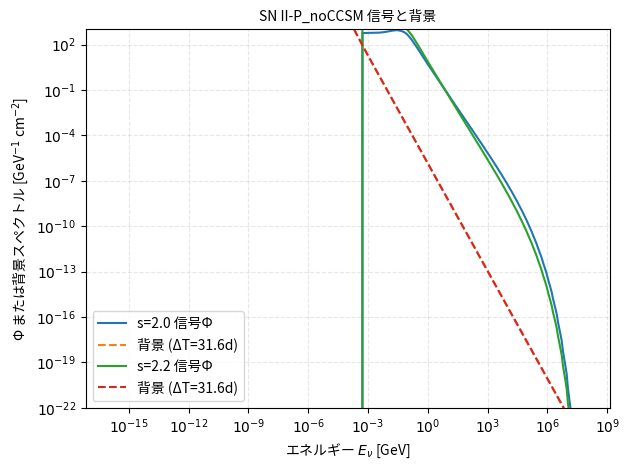

In [ ]:
# ✅ 日本語フォント設定（Colab 用）-----------------------------
!apt-get -y install fonts-noto-cjk > /dev/null
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
import numpy as np, pandas as pd
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator

font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# ------------------------------------------------------------
# 0. 入力パスとパラメータ
# ------------------------------------------------------------
DATA_DIR   = Path(".")                      # dat ファイルの在処
SIG_FILES  = {"s=2.0": "FinalFluxs20.dat",
              "s=2.2": "FinalFluxs22.dat"}  # Murase flux
AEFF_FILE  = "IC86_II_effectiveArea.csv"    # IceCube IRF
DEC_SN_DEG = +7.0                           # 対象 SN の赤緯
E_TH_GEV   = 30.0                           # 閾値 [GeV]

# ------------------------------------------------------------
# 1. IceCube 2-D 有効面積  A_eff(dec, E)  補間関数
# ------------------------------------------------------------
def build_Aeff2D(csv_path:str):
    """
    csv は IceCube release の 'irfs' フォルダと同フォーマット
      # log10(E_nu/GeV)_min  log10(E_nu/GeV)_max  Dec_nu_min  Dec_nu_max  A_Eff[cm^2]
    """
    names = ["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
    df    = pd.read_csv(csv_path, comment="#", delim_whitespace=True, names=names)

    # ビン中心値
    df["E_GeV"] = 10**((df.logEmin + df.logEmax)/2)
    df["dec"]   = (df.dec_min + df.dec_max)/2

    # pivot で 2D グリッド化
    pivot = df.pivot_table(index="dec", columns="E_GeV", values="A_eff_cm2", aggfunc="mean")
    dec_grid = pivot.index.values          #  Declination bin 中心
    E_grid   = pivot.columns.values        #  Energy bin 中心 [GeV]
    A_grid   = pivot.values                #  cm^2

    print(f"[INFO] A_eff grid: dec={dec_grid.size}, E={E_grid.size}")
    return RegularGridInterpolator((dec_grid, E_grid), A_grid,
                                   bounds_error=False, fill_value=0.)

A_eff2d = build_Aeff2D(AEFF_FILE)

# ------------------------------------------------------------
# 2. 背景モデル（簡易）
# ------------------------------------------------------------
def phi_atm(E_GeV, cosZ):
    """Honda/Gaisser 大気ニュートリノ全 flavour 合計（per sr）"""
    return 1.44e-18 * (E_GeV)**-3.7 * (1 + 1.1*E_GeV*cosZ/115)**-1   # GeV^-1 cm^-2 s^-1 sr^-1

def phi_ast(E_GeV):
    """IceCube diffuse astro (E^-2.37) を 2π 北天に倍掛け"""
    Phi0 = 1.5e-18   # GeV^-1 cm^-2 s^-1 sr^-1
    return Phi0 * (E_GeV/100)**-2.37 * 2*np.pi                        # GeV^-1 cm^-2 s^-1

# ------------------------------------------------------------
# 3. Murase dat → 時間積分フルエンス Φ(E) の取得
# ------------------------------------------------------------
def load_signal(path:Path, N_BLOCKS:int=51):
    """returns (E_GeV, Φ_sig[GeV^-1 cm^-2], T_obs[s])"""
    raw   = np.loadtxt(path)
    bins  = raw.shape[0] // N_BLOCKS
    data  = raw.reshape(N_BLOCKS, bins, 14)

    E_GeV = data[0,:,0] * 1e-9                         # bin 共通
    flux  = data[:,:,7] * 1e9                          # GeV^-1 s^-1
    flag  = data[:,:,13]
    fourπ = data[:,:,10]

    flux_earth = flux / fourπ                          # GeV^-1 s^-1 cm^-2
    t_grid = 1e3 * 10**(0.1*np.arange(N_BLOCKS))       # sec
    dt     = np.concatenate([np.diff(t_grid), [np.diff(t_grid)[-1]]])

    Φ_E   = (flux_earth * flag * dt[:,None]).sum(axis=0)
    T_obs = dt[flag.sum(axis=1) > 0].sum()             # 活動ブロックのみ

    return E_GeV, Φ_E, T_obs

# ------------------------------------------------------------
# 4. ΔT 走査で SNR 最大を探す
# ------------------------------------------------------------
def best_window(E, Φ, T_total, dec_deg, E_th=30.0):
    cosZ = np.sin(np.radians(90-dec_deg))
    mask_sig = E >= E_th
    windows  = np.logspace(-1, 1.5, 60)                # 0.1d – 30d

    best = {"SNR":0}
    for ΔT_day in windows:
        scale  = (ΔT_day*86400) / T_total
        N_sig  = np.trapz(Φ[mask_sig] * scale * A_eff2d((dec_deg, E[mask_sig])), E[mask_sig])

        Φ_bkg  = (phi_atm(E[mask_sig], cosZ) + phi_ast(E[mask_sig])) # per sr→全北天 2π 反映済み
        N_bkg  = np.trapz(Φ_bkg * A_eff2d((dec_deg, E[mask_sig])) * ΔT_day*86400, E[mask_sig])
        SNR    = N_sig / np.sqrt(max(N_bkg, 1e-10))

        if SNR > best["SNR"]:
            best = {"T_day":ΔT_day, "S":N_sig, "B":N_bkg, "SNR":SNR}
    return best

# ------------------------------------------------------------
# 5. 解析ループ & 可視化
# ------------------------------------------------------------
for lbl, f in SIG_FILES.items():
    E, Φ, T_tot = load_signal(DATA_DIR/f)
    res         = best_window(E, Φ, T_tot, DEC_SN_DEG, E_th=E_TH_GEV)
    print(f"{lbl}: ΔT ≈ {res['T_day']:.2f} d,  S={res['S']:.1f}, "
          f"B={res['B']:.2f},  S/√B={res['SNR']:.1f}")

    # ---- スペクトル描画 (窓は最適 ΔT) ----
    Φ_bkg_T = (phi_atm(E, np.sin(np.radians(90-DEC_SN_DEG))) + phi_ast(E)) * res['T_day']*86400
    plt.loglog(E, Φ*res['T_day']*86400 / T_tot, label=f"{lbl} 信号Φ")
    plt.loglog(E, Φ_bkg_T, ls="--", label=f"背景 (ΔT={res['T_day']:.1f}d)")

plt.xlabel("エネルギー $E_ν$ [GeV]", fontproperties=font_prop)
plt.ylabel("Φ または背景スペクトル [GeV$^{-1}$ cm$^{-2}$]", fontproperties=font_prop)
plt.title("SN II-P_noCCSM 信号と背景", fontproperties=font_prop)
plt.ylim(1e-22, 1e3); plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend(prop=font_prop, loc="lower left")
plt.tight_layout(); plt.show()

<ipython-input-13-5b3f90778ae1>:32: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df    = pd.read_csv(csv_path, comment="#", delim_whitespace=True, names=names)
<ipython-input-13-5b3f90778ae1>:97: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_sig = np.trapz( Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask] )
<ipython-input-13-5b3f90778ae1>:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_bkg = np.trapz( Φ_bkg * A_eff2d((dec_deg, E[mask])) * ΔT_day*86400, E[mask] )


[INFO] A_eff grid: dec=50,  E=40
s=2.0: ΔT ≈ 31.62 d,  S=207.9,  B=2.24e-06,  S/√B=139003.9
s=2.2: ΔT ≈ 31.62 d,  S=53.2,  B=2.24e-06,  S/√B=35591.5


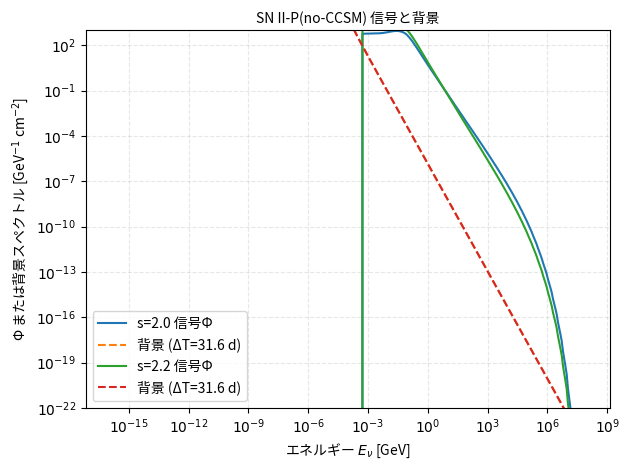

In [ ]:
# ===============================================
#  SN II-P (no-CCSM) – IceCube シグナル／背景解析
#  Murase flux dat  +  IC86_II effective area
# ===============================================

# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk > /dev/null
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator

font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# ------------------------------------------------------------
# 0. 入力パスとパラメータ
# ------------------------------------------------------------
DATA_DIR   = Path(".")                      # dat ファイルが置いてあるディレクトリ
SIG_FILES  = {"s=2.0": "FinalFluxs20.dat",
              "s=2.2": "FinalFluxs22.dat"}  # Murase テーブル
AEFF_FILE  = "IC86_II_effectiveArea.csv"    # IceCube irfs
DEC_SN_DEG = +7.0                           # 解析したい超新星の赤緯
E_TH_GEV   = 30.0                           # 解析エネルギー下限 GeV

# ------------------------------------------------------------
# 1. 2-D IceCube 有効面積 A_eff(dec, E)  補間
# ------------------------------------------------------------
def build_Aeff2D(csv_path:str):
    names = ["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
    df    = pd.read_csv(csv_path, comment="#", delim_whitespace=True, names=names)

    df["E_GeV"] = 10**((df.logEmin + df.logEmax)/2)
    df["dec"]   = (df.dec_min + df.dec_max)/2

    # 2-D ピボット → 格子
    pivot   = df.pivot_table(index="dec", columns="E_GeV",
                             values="A_eff_cm2", aggfunc="mean")
    dec_grid, E_grid = pivot.index.values, pivot.columns.values
    print(f"[INFO] A_eff grid: dec={dec_grid.size},  E={E_grid.size}")

    return RegularGridInterpolator((dec_grid, E_grid),
                                   pivot.values,  # cm^2
                                   bounds_error=False, fill_value=0.)

A_eff2d = build_Aeff2D(AEFF_FILE)

# ------------------------------------------------------------
# 2. 背景モデル（簡易）：大気 + 拡散天体
# ------------------------------------------------------------
def phi_atm_simple(E_GeV, cosZ):
    """π/K 起源の大気ニュートリノ（全 flavour）per sr"""
    return 1.44e-18 * E_GeV**-3.7 * (1 + 1.1*E_GeV*cosZ/115)**-1  # GeV⁻¹ cm⁻² s⁻¹ sr⁻¹

def phi_ast_diff(E_GeV):
    """IceCube E^-2.37 拡散成分・北天 2π sr に換算"""
    Phi0 = 1.5e-18                                              # per sr
    return Phi0 * (E_GeV/100)**-2.37 * 2*np.pi                  # GeV⁻¹ cm⁻² s⁻¹

# ------------------------------------------------------------
# 3. Murase テーブル → 時間積分フルエンス Φ(E)
# ------------------------------------------------------------
def load_murase_flux(dat_path:Path, n_blocks:int=51):
    arr   = np.loadtxt(dat_path)
    bins  = arr.shape[0]//n_blocks
    data  = arr.reshape(n_blocks, bins, 14)

    E_GeV = data[0,:,0] * 1e-9                 # Bin 共通
    flux  = data[:,:,7] * 1e9                  # GeV⁻¹ s⁻¹
    flag  = data[:,:,13]
    fourπ = data[:,:,10]

    flux_earth = flux / fourπ                  # GeV⁻¹ s⁻¹ cm⁻²

    # 各ブロック中央時刻 (sec) : 1e3 * 10^(0.1k)
    t_grid = 1e3 * 10**(0.1*np.arange(n_blocks))
    dt     = np.concatenate([np.diff(t_grid), [np.diff(t_grid)[-1]]])

    Φ_E   = (flux_earth * flag * dt[:,None]).sum(axis=0)  # GeV⁻¹ cm⁻²
    T_obs = dt[flag.sum(axis=1) > 0].sum()                # 活動ブロック和

    return E_GeV, Φ_E, T_obs

# ------------------------------------------------------------
# 4.  ΔT 探索で SNR 最大
# ------------------------------------------------------------
def best_window(E, Φ, T_total_sec, dec_deg, E_th=E_TH_GEV):
    mask   = E >= E_th
    cosZ   = np.sin(np.radians(90-dec_deg))
    days   = np.logspace(-1, 1.5, 60)               # 0.1-30 日

    best = {"SNR":0.}
    for ΔT_day in days:
        scale = ΔT_day*86400 / T_total_sec
        # --- Signal
        N_sig = np.trapz( Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask] )

        # --- Background (大気+拡散)　per sr → 既に 2π 掛けた形で使用
        Φ_bkg = ( phi_atm_simple(E[mask], cosZ) + phi_ast_diff(E[mask]) )
        N_bkg = np.trapz( Φ_bkg * A_eff2d((dec_deg, E[mask])) * ΔT_day*86400, E[mask] )

        SNR   = N_sig / np.sqrt(max(N_bkg, 1e-20))
        if SNR > best["SNR"]:
            best = {"T_day":ΔT_day, "S":N_sig, "B":N_bkg, "SNR":SNR}
    return best

# ------------------------------------------------------------
# 5. 解析 & プロット
# ------------------------------------------------------------
for label, f in SIG_FILES.items():
    E, Φ, T_tot = load_murase_flux(DATA_DIR/f)
    res         = best_window(E, Φ, T_tot, DEC_SN_DEG)

    print(f"{label}: ΔT ≈ {res['T_day']:.2f} d,  "
          f"S={res['S']:.1f},  B={res['B']:.2e},  S/√B={res['SNR']:.1f}")

    # ----- スペクトル図 (最適窓 ΔT) -------------
    Φ_bkg_T = ( phi_atm_simple(E, np.sin(np.radians(90-DEC_SN_DEG)))
               + phi_ast_diff(E) ) * res['T_day']*86400

    plt.loglog(E, Φ*res['T_day']*86400/T_tot, label=f"{label} 信号Φ")
    plt.loglog(E, Φ_bkg_T, ls="--", label=f"背景 (ΔT={res['T_day']:.1f} d)")

plt.xlabel("エネルギー $E_ν$ [GeV]", fontproperties=font_prop)
plt.ylabel("Φ または背景スペクトル [GeV$^{-1}$ cm$^{-2}$]", fontproperties=font_prop)
plt.title("SN II-P(no-CCSM) 信号と背景", fontproperties=font_prop)
plt.ylim(1e-22, 1e3); plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend(prop=font_prop, loc="lower left")
plt.tight_layout(); plt.show()

In [ ]:
import re, numpy as np, pandas as pd
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator

header_pat = re.compile(r"cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)", re.I)

def build_phi_atm_table(path:Path):
    blocks, buf, cos_mid = [], [], None

    with open(path, "r", errors="replace") as f:
        for ln in f:
            m = header_pat.search(ln)
            if m:
                if buf and cos_mid is not None:
                    blocks.append(_lines_to_df(buf, cos_mid))
                cos_mid = 0.5*(float(m.group(1))+float(m.group(2)))
                buf = []
                continue
            if ln.strip():
                buf.append(ln.rstrip())
        if buf and cos_mid is not None:
            blocks.append(_lines_to_df(buf, cos_mid))

    if not blocks:
        raise RuntimeError("ヘッダが認識できませんでした。")

    big = pd.concat(blocks, ignore_index=True)
    pivot = big.pivot_table(index="cosZ", columns="E_GeV",
                            values="phi", aggfunc="mean").sort_index()

    cos_grid, E_grid = pivot.index.values, pivot.columns.values
    print(f"[INFO] Honda table: cosZ {cos_grid.size} × E {E_grid.size}")

    return RegularGridInterpolator((cos_grid, E_grid),
                                   pivot.values, bounds_error=False, fill_value=0.)

def _lines_to_df(lines, cos_mid):
    rec = []
    for ln in lines:
        # 行番号とコロンを除去 → 空白分割
        cols = re.sub(r"^\s*\d+:\s*", "", ln).split()
        if len(cols) < 3:       # エネルギー＋νμ＋ν̅μ が揃っていない行は捨てる
            continue
        try:
            E   = float(cols[0])
            num = float(cols[1])
            nmb = float(cols[2])
        except ValueError:      # 数値でなければ捨てる
            continue
        rec.append((cos_mid, E, (num+nmb)*1e-4))   # m²→cm²

    return pd.DataFrame(rec, columns=["cosZ","E_GeV","phi"])

# ---------------- 検証 ----------------
HONDA = Path("spl-ally-20-01-solmin.d")
phi_atm_table = build_phi_atm_table(HONDA)
print("例) φ_atm(cosθ=0.95, 100 GeV) =", f"{phi_atm_table((0.95,100)):.3e}",
      "[GeV⁻¹ cm⁻² s⁻¹ sr⁻¹]")

[INFO] Honda table: cosZ 10 × E 101
例) φ_atm(cosθ=0.95, 100 GeV) = 4.085e-08 [GeV⁻¹ cm⁻² s⁻¹ sr⁻¹]


<ipython-input-22-cacd8db6ccca>:94: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_sig = np.trapz(Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-22-cacd8db6ccca>:98: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_bkg = np.trapz(Φ_bkg * A_eff2d((dec_deg, E[mask])) *


[INFO] A_eff grid: dec=50,  E=40
s=2.0: ΔT ≈ 31.62 d,  S=207.9,  B=2.24e-06,  S/√B=139003.9
s=2.2: ΔT ≈ 31.62 d,  S=53.2,  B=2.24e-06,  S/√B=35591.5


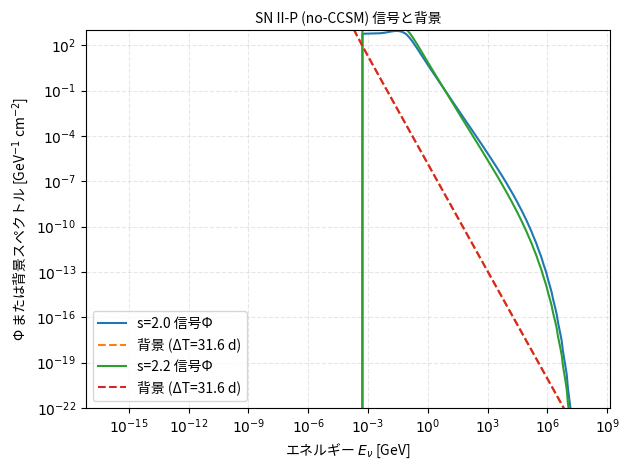

In [ ]:
# ===============================================
#  SN II-P (no-CCSM) – IceCube シグナル／背景解析
#  Murase flux dat  +  IC86_II effective area
# ===============================================

# ✅ 日本語フォント設定（Colab 用）-----------------------------
!apt-get -y install fonts-noto-cjk > /dev/null
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator

font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# ------------------------------------------------------------
# 0. 入力パスとパラメータ
# ------------------------------------------------------------
DATA_DIR   = Path(".")                      # dat ファイル在処
SIG_FILES  = {"s=2.0": "FinalFluxs20.dat",  # Murase table
              "s=2.2": "FinalFluxs22.dat"}
AEFF_FILE  = "IC86_II_effectiveArea.csv"    # IceCube irfs
DEC_SN_DEG = +7.0                           # 対象 SN の赤緯
E_TH_GEV   = 30.0                           # 閾値 [GeV]

# ------------------------------------------------------------
# 1. 2-D IceCube 有効面積  A_eff(dec, E)  → 補間関数
# ------------------------------------------------------------
def build_Aeff2D(csv_path: str):
    names = ["logEmin", "logEmax", "dec_min", "dec_max", "A_eff_cm2"]
    df = pd.read_csv(csv_path, comment="#", sep=r"\s+", names=names)

    df["E_GeV"] = 10**((df.logEmin + df.logEmax)/2)
    df["dec"]   = (df.dec_min + df.dec_max)/2

    pivot = df.pivot_table(index="dec", columns="E_GeV",
                           values="A_eff_cm2", aggfunc="mean")
    dec_grid, E_grid = pivot.index.values, pivot.columns.values
    print(f"[INFO] A_eff grid: dec={dec_grid.size},  E={E_grid.size}")

    return RegularGridInterpolator((dec_grid, E_grid), pivot.values,
                                   bounds_error=False, fill_value=0.)

A_eff2d = build_Aeff2D(AEFF_FILE)

# ------------------------------------------------------------
# 2. 背景モデル（簡易：大気 + 拡散天体）
# ------------------------------------------------------------
def phi_atm_simple(E_GeV, cosZ):
    """π/K 起源の大気ニュートリノ全 flavor（per sr）"""
    return 1.44e-18 * E_GeV**-3.7 * (1 + 1.1*E_GeV*cosZ/115)**-1  # GeV⁻¹ cm⁻² s⁻¹ sr⁻¹

def phi_ast_diff(E_GeV):
    """IceCube diffuse astro (E⁻²·³⁷) × 北天 2π sr"""
    Phi0 = 1.5e-18  # GeV⁻¹ cm⁻² s⁻¹ sr⁻¹
    return Phi0 * (E_GeV/100)**-2.37 * 2*np.pi               # GeV⁻¹ cm⁻² s⁻¹

# ------------------------------------------------------------
# 3. Murase dat → 時間積分フルエンス Φ(E)
# ------------------------------------------------------------
def load_murase_flux(dat_path: Path, n_blocks: int = 51):
    arr   = np.loadtxt(dat_path)
    bins  = arr.shape[0] // n_blocks
    data  = arr.reshape(n_blocks, bins, 14)

    E_GeV = data[0, :, 0] * 1e-9           # bin 共通
    flux  = data[:, :, 7] * 1e9            # GeV⁻¹ s⁻¹
    flag  = data[:, :, 13]
    fourπ = data[:, :, 10]

    flux_earth = flux / fourπ              # GeV⁻¹ s⁻¹ cm⁻²

    t_grid = 1e3 * 10**(0.1*np.arange(n_blocks))     # sec
    dt     = np.concatenate([np.diff(t_grid), [np.diff(t_grid)[-1]]])

    Φ_E   = (flux_earth * flag * dt[:, None]).sum(axis=0)    # GeV⁻¹ cm⁻²
    T_obs = dt[flag.sum(axis=1) > 0].sum()                   # 活動ブロック合計

    return E_GeV, Φ_E, T_obs

# ------------------------------------------------------------
# 4. ΔT 探索で SNR 最大
# ------------------------------------------------------------
def best_window(E, Φ, T_total_sec, dec_deg, E_th=E_TH_GEV):
    mask  = E >= E_th
    cosZ  = np.sin(np.radians(90 - dec_deg))
    days  = np.logspace(-1, 1.5, 60)        # 0.1–30 d

    best = {"SNR": 0.}
    for ΔT_day in days:
        scale = ΔT_day*86400 / T_total_sec
        # --- Signal
        N_sig = np.trapz(Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask])

        # --- Background
        Φ_bkg = (phi_atm_simple(E[mask], cosZ) + phi_ast_diff(E[mask]))  # per sr
        N_bkg = np.trapz(Φ_bkg * A_eff2d((dec_deg, E[mask])) *
                         ΔT_day*86400, E[mask])

        SNR = N_sig / np.sqrt(max(N_bkg, 1e-20))
        if SNR > best["SNR"]:
            best = {"T_day": ΔT_day, "S": N_sig, "B": N_bkg, "SNR": SNR}
    return best

# ------------------------------------------------------------
# 5. 解析実行 & プロット
# ------------------------------------------------------------
for label, file_name in SIG_FILES.items():
    E, Φ, T_tot = load_murase_flux(DATA_DIR / file_name)
    res         = best_window(E, Φ, T_tot, DEC_SN_DEG)

    print(f"{label}: ΔT ≈ {res['T_day']:.2f} d,  "
          f"S={res['S']:.1f},  B={res['B']:.2e},  "
          f"S/√B={res['SNR']:.1f}")

    # --- スペクトル図 (最適窓 ΔT) ---
    Φ_bkg_T = (phi_atm_simple(E, np.sin(np.radians(90-DEC_SN_DEG)))
               + phi_ast_diff(E)) * res['T_day']*86400

    plt.loglog(E, Φ*res['T_day']*86400/T_tot, label=f"{label} 信号Φ")
    plt.loglog(E, Φ_bkg_T, ls="--", label=f"背景 (ΔT={res['T_day']:.1f} d)")

plt.xlabel("エネルギー $E_ν$ [GeV]", fontproperties=font_prop)
plt.ylabel("Φ または背景スペクトル [GeV$^{-1}$ cm$^{-2}$]",
           fontproperties=font_prop)
plt.title("SN II-P (no-CCSM) 信号と背景", fontproperties=font_prop)
plt.ylim(1e-22, 1e3)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend(prop=font_prop, loc="lower left")
plt.tight_layout(); plt.show()

[INFO] A_eff grid: dec=50, E=40
[INFO] Honda table: cosZ 10 × E 101
s=2.0: ΔT ≈ 31.62 d, S=207.9, B=2.24e-06, S/√B=139003.9
s=2.2: ΔT ≈ 31.62 d, S=53.2, B=2.24e-06, S/√B=35591.5


<ipython-input-40-62711ee3e0d4>:145: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_sig = np.trapz(Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-40-62711ee3e0d4>:148: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_bkg = np.trapz(Φ_bkg * A_eff2d((dec_deg, E[mask])) *


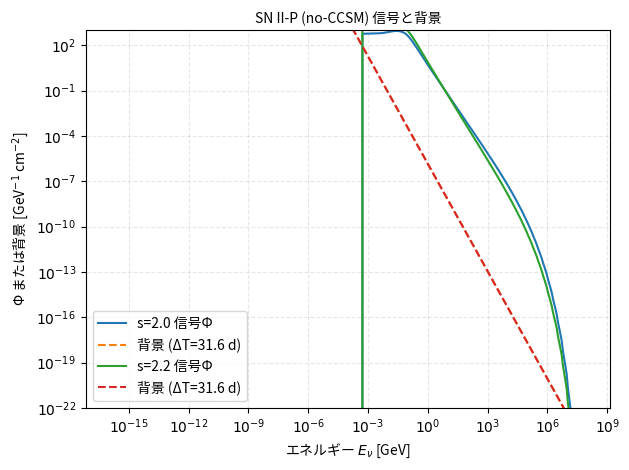

In [ ]:
# ===============================================
#   SN II-P (no-CCSM) – IceCube 信号／背景解析
#   ・Murase flux  (FinalFluxs*.dat)         ┐
#   ・IC86_II effective area (csv)            ├→ 期待事象数 & 最適観測窓
#   ・Honda-2015 南極大気表 (spl-ally-20-01-solmin.d) ┘
# ===============================================

# ---------- Colab: 日本語フォント -----------------
!apt-get -y install fonts-noto-cjk > /dev/null
import numpy as np, pandas as pd, re, math
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from pathlib import Path
from io import StringIO
from scipy.interpolate import RegularGridInterpolator

# ---------- 基本パラメータ -----------------------
DATA_DIR   = Path(".")
SIG_FILES  = {"s=2.0": "FinalFluxs20.dat",
              "s=2.2": "FinalFluxs22.dat"}
AEFF_FILE  = "IC86_II_effectiveArea.csv"
HONDA_FILE = "spl-ally-20-01-solmin.d"          # 2.6 South-Pole / Solar-min, azimuth-avg
DEC_SN_DEG = +7.0                               # 解析したい超新星の赤緯
E_TH_GEV   = 30.0                               # 解析エネルギー下限

# ---------- フォント -----------------------------
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# =================================================
# 1) IceCube 2-D 有効面積  A_eff(dec,E) --------------
# =================================================
def build_Aeff2D(csv_path: str):
    cols = ["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
    df   = pd.read_csv(csv_path, comment="#", sep=r"\s+", names=cols)

    df["E_GeV"] = 10**((df.logEmin + df.logEmax)/2)
    df["dec"]   = (df.dec_min + df.dec_max)/2
    pivot       = df.pivot_table(index="dec", columns="E_GeV",
                                 values="A_eff_cm2", aggfunc="mean")
    dec_grid, E_grid = pivot.index.values, pivot.columns.values
    print(f"[INFO] A_eff grid: dec={dec_grid.size}, E={E_grid.size}")
    return RegularGridInterpolator((dec_grid, E_grid), pivot.values,
                                   bounds_error=False, fill_value=0.)
A_eff2d = build_Aeff2D(AEFF_FILE)

# =================================================
# 2) Honda 2015 大気表  → φ_atm_table(cosZ,E) -------
# =================================================
def _buf_to_df(lines, cos_mid):
    """
    1 cosZ ブロック → DataFrame〈cosZ,E_GeV,phi〉
    * 行番号/空白/コメントを無視して先頭 3 トークンを数値化
    * phi = (νμ + ν̅μ) × 1e-4  (m^-2 → cm^-2)
    """
    rec = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+:\s*", "", ln)           # 行番号除去
        if not ln.strip() or ln.lstrip().startswith(("#","average")):
            continue
        toks = ln.split()
        if len(toks) < 3:
            continue
        try:
            e, n1, n2 = map(float, toks[:3])
            rec.append((cos_mid, e, (n1+n2)*1e-4))
        except ValueError:
            continue
    if not rec:
        raise RuntimeError("数値行を取得できませんでした")
    return pd.DataFrame(rec, columns=["cosZ","E_GeV","phi"])

def build_phi_atm_table(honda_path: Path):
    header = re.compile(r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)")
    cos_blocks, buf, cos_mid = [], [], None
    with open(honda_path, encoding="utf-8", errors="replace") as f:
        for ln in f:
            m = header.search(ln)
            if m:
                if buf and cos_mid is not None:
                    cos_blocks.append(_buf_to_df(buf, cos_mid))
                cos_mid = 0.5*(float(m[1])+float(m[2]))
                buf = []
                continue
            buf.append(ln)
        if buf and cos_mid is not None:
            cos_blocks.append(_buf_to_df(buf, cos_mid))

    big = pd.concat(cos_blocks, ignore_index=True)
    pivot = big.pivot_table(index="cosZ", columns="E_GeV",
                            values="phi", aggfunc="mean").sort_index()
    cos_grid, E_grid = pivot.index.values, pivot.columns.values
    print(f"[INFO] Honda table: cosZ {cos_grid.size} × E {E_grid.size}")
    return RegularGridInterpolator((cos_grid, E_grid),
                                   pivot.values, bounds_error=False, fill_value=0.)
phi_atm_table = build_phi_atm_table(Path(HONDA_FILE))

def phi_atm(E_GeV, cosZ):
    """Honda νμ+ν̅μ per sr（>1 TeV は E^-3.7 で外挿）"""
    E   = np.asarray(E_GeV, dtype=float)
    cos = np.maximum(np.minimum(cosZ, 1.0), 0.0)
    phi = phi_atm_table((np.full_like(E, cos), np.minimum(E, 1e3)))
    hi  = E > 1e3
    phi[hi] *= (E[hi]/1e3)**-3.7
    return phi                                  # GeV^-1 cm^-2 s^-1 sr^-1

def phi_ast_diff(E_GeV):
    """IceCube diffuse astrophysical (E^-2.37) × 2π"""
    Phi0 = 1.5e-18
    return Phi0 * (E_GeV/100)**-2.37 * 2*np.pi     # GeV^-1 cm^-2 s^-1

# =================================================
# 3) Murase .dat → 時間積分フルエンス Φ(E) ----------
# =================================================
def load_murase_flux(path: Path, n_blocks=51):
    arr   = np.loadtxt(path)
    bins  = arr.shape[0] // n_blocks
    data  = arr.reshape(n_blocks, bins, 14)

    E_GeV = data[0,:,0] * 1e-9
    flux  = data[:,:,7] * 1e9        # GeV^-1 s^-1
    flag  = data[:,:,13]
    fourπ = data[:,:,10]

    flux_earth = flux / fourπ

    t_grid = 1e3 * 10**(0.1*np.arange(n_blocks))
    dt     = np.concatenate([np.diff(t_grid), [np.diff(t_grid)[-1]]])

    Φ_E   = (flux_earth * flag * dt[:,None]).sum(axis=0)
    T_obs = dt[flag.sum(axis=1)>0].sum()
    return E_GeV, Φ_E, T_obs

# =================================================
# 4) ΔT 走査 → 最適 S/N -----------------------------
# =================================================
def best_window(E, Φ, T_total, dec_deg, E_th=E_TH_GEV):
    mask  = E >= E_th
    cosZ  = np.sin(np.radians(90-dec_deg))
    days  = np.logspace(-1, 1.5, 60)          # 0.1–30 d
    best  = {"SNR":0.}

    for ΔT_day in days:
        scale = ΔT_day*86400 / T_total
        N_sig = np.trapz(Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask])

        Φ_bkg = (phi_atm(E[mask], cosZ)*2*np.pi + phi_ast_diff(E[mask]))
        N_bkg = np.trapz(Φ_bkg * A_eff2d((dec_deg, E[mask])) *
                         ΔT_day*86400, E[mask])

        SNR = N_sig / math.sqrt(max(N_bkg, 1e-30))
        if SNR > best["SNR"]:
            best = {"T_day":ΔT_day, "S":N_sig, "B":N_bkg, "SNR":SNR}
    return best

# =================================================
# 5) 実行 & プロット -------------------------------
# =================================================
for lbl, fn in SIG_FILES.items():
    E, Φ, T_tot = load_murase_flux(DATA_DIR/fn)
    res         = best_window(E, Φ, T_tot, DEC_SN_DEG)

    print(f"{lbl}: ΔT ≈ {res['T_day']:.2f} d, "
          f"S={res['S']:.1f}, B={res['B']:.2e}, S/√B={res['SNR']:.1f}")

    Φ_bkg_T = (phi_atm(E, np.sin(np.radians(90-DEC_SN_DEG)))*2*np.pi
               + phi_ast_diff(E)) * res['T_day']*86400

    plt.loglog(E, Φ*res['T_day']*86400/T_tot, label=f"{lbl} 信号Φ")
    plt.loglog(E, Φ_bkg_T, ls="--", label=f"背景 (ΔT={res['T_day']:.1f} d)")

plt.xlabel("エネルギー $E_ν$ [GeV]", fontproperties=font_prop)
plt.ylabel("Φ または背景 [GeV$^{-1}$ cm$^{-2}$]", fontproperties=font_prop)
plt.title("SN II-P (no-CCSM) 信号と背景", fontproperties=font_prop)
plt.ylim(1e-22, 1e3); plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend(prop=font_prop, loc="lower left"); plt.tight_layout(); plt.show()

[INFO] A_eff grid: dec=50, E=40
[INFO] Honda table: cosZ 10 × E 101
s=2.0: ΔT ≈ 31.62 d, S=207.9, B=2.24e-06, S/√B=139003.9


<ipython-input-41-62711ee3e0d4>:145: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_sig = np.trapz(Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-41-62711ee3e0d4>:148: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  N_bkg = np.trapz(Φ_bkg * A_eff2d((dec_deg, E[mask])) *


s=2.2: ΔT ≈ 31.62 d, S=53.2, B=2.24e-06, S/√B=35591.5


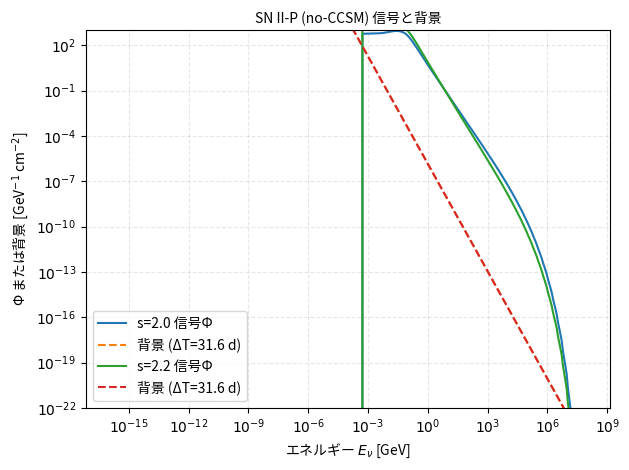

In [ ]:
# ===============================================
#   SN II-P (no-CCSM) – IceCube 信号／背景解析
#   ・Murase flux  (FinalFluxs*.dat)         ┐
#   ・IC86_II effective area (csv)            ├→ 期待事象数 & 最適観測窓
#   ・Honda-2015 南極大気表 (spl-ally-20-01-solmin.d) ┘
# ===============================================

# ---------- Colab: 日本語フォント -----------------
!apt-get -y install fonts-noto-cjk > /dev/null
import numpy as np, pandas as pd, re, math
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from pathlib import Path
from io import StringIO
from scipy.interpolate import RegularGridInterpolator

# ---------- 基本パラメータ -----------------------
DATA_DIR   = Path(".")
SIG_FILES  = {"s=2.0": "FinalFluxs20.dat",
              "s=2.2": "FinalFluxs22.dat"}
AEFF_FILE  = "IC86_II_effectiveArea.csv"
HONDA_FILE = "spl-ally-20-01-solmin.d"          # 2.6 South-Pole / Solar-min, azimuth-avg
DEC_SN_DEG = +7.0                               # 解析したい超新星の赤緯
E_TH_GEV   = 30.0                               # 解析エネルギー下限

# ---------- フォント -----------------------------
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# =================================================
# 1) IceCube 2-D 有効面積  A_eff(dec,E) --------------
# =================================================
def build_Aeff2D(csv_path: str):
    cols = ["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
    df   = pd.read_csv(csv_path, comment="#", sep=r"\s+", names=cols)

    df["E_GeV"] = 10**((df.logEmin + df.logEmax)/2)
    df["dec"]   = (df.dec_min + df.dec_max)/2
    pivot       = df.pivot_table(index="dec", columns="E_GeV",
                                 values="A_eff_cm2", aggfunc="mean")
    dec_grid, E_grid = pivot.index.values, pivot.columns.values
    print(f"[INFO] A_eff grid: dec={dec_grid.size}, E={E_grid.size}")
    return RegularGridInterpolator((dec_grid, E_grid), pivot.values,
                                   bounds_error=False, fill_value=0.)
A_eff2d = build_Aeff2D(AEFF_FILE)

# =================================================
# 2) Honda 2015 大気表  → φ_atm_table(cosZ,E) -------
# =================================================
def _buf_to_df(lines, cos_mid):
    """
    1 cosZ ブロック → DataFrame〈cosZ,E_GeV,phi〉
    * 行番号/空白/コメントを無視して先頭 3 トークンを数値化
    * phi = (νμ + ν̅μ) × 1e-4  (m^-2 → cm^-2)
    """
    rec = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+:\s*", "", ln)           # 行番号除去
        if not ln.strip() or ln.lstrip().startswith(("#","average")):
            continue
        toks = ln.split()
        if len(toks) < 3:
            continue
        try:
            e, n1, n2 = map(float, toks[:3])
            rec.append((cos_mid, e, (n1+n2)*1e-4))
        except ValueError:
            continue
    if not rec:
        raise RuntimeError("数値行を取得できませんでした")
    return pd.DataFrame(rec, columns=["cosZ","E_GeV","phi"])

def build_phi_atm_table(honda_path: Path):
    header = re.compile(r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)")
    cos_blocks, buf, cos_mid = [], [], None
    with open(honda_path, encoding="utf-8", errors="replace") as f:
        for ln in f:
            m = header.search(ln)
            if m:
                if buf and cos_mid is not None:
                    cos_blocks.append(_buf_to_df(buf, cos_mid))
                cos_mid = 0.5*(float(m[1])+float(m[2]))
                buf = []
                continue
            buf.append(ln)
        if buf and cos_mid is not None:
            cos_blocks.append(_buf_to_df(buf, cos_mid))

    big = pd.concat(cos_blocks, ignore_index=True)
    pivot = big.pivot_table(index="cosZ", columns="E_GeV",
                            values="phi", aggfunc="mean").sort_index()
    cos_grid, E_grid = pivot.index.values, pivot.columns.values
    print(f"[INFO] Honda table: cosZ {cos_grid.size} × E {E_grid.size}")
    return RegularGridInterpolator((cos_grid, E_grid),
                                   pivot.values, bounds_error=False, fill_value=0.)
phi_atm_table = build_phi_atm_table(Path(HONDA_FILE))

def phi_atm(E_GeV, cosZ):
    """Honda νμ+ν̅μ per sr（>1 TeV は E^-3.7 で外挿）"""
    E   = np.asarray(E_GeV, dtype=float)
    cos = np.maximum(np.minimum(cosZ, 1.0), 0.0)
    phi = phi_atm_table((np.full_like(E, cos), np.minimum(E, 1e3)))
    hi  = E > 1e3
    phi[hi] *= (E[hi]/1e3)**-3.7
    return phi                                  # GeV^-1 cm^-2 s^-1 sr^-1

def phi_ast_diff(E_GeV):
    """IceCube diffuse astrophysical (E^-2.37) × 2π"""
    Phi0 = 1.5e-18
    return Phi0 * (E_GeV/100)**-2.37 * 2*np.pi     # GeV^-1 cm^-2 s^-1

# =================================================
# 3) Murase .dat → 時間積分フルエンス Φ(E) ----------
# =================================================
def load_murase_flux(path: Path, n_blocks=51):
    arr   = np.loadtxt(path)
    bins  = arr.shape[0] // n_blocks
    data  = arr.reshape(n_blocks, bins, 14)

    E_GeV = data[0,:,0] * 1e-9
    flux  = data[:,:,7] * 1e9        # GeV^-1 s^-1
    flag  = data[:,:,13]
    fourπ = data[:,:,10]

    flux_earth = flux / fourπ

    t_grid = 1e3 * 10**(0.1*np.arange(n_blocks))
    dt     = np.concatenate([np.diff(t_grid), [np.diff(t_grid)[-1]]])

    Φ_E   = (flux_earth * flag * dt[:,None]).sum(axis=0)
    T_obs = dt[flag.sum(axis=1)>0].sum()
    return E_GeV, Φ_E, T_obs

# =================================================
# 4) ΔT 走査 → 最適 S/N -----------------------------
# =================================================
def best_window(E, Φ, T_total, dec_deg, E_th=E_TH_GEV):
    mask  = E >= E_th
    cosZ  = np.sin(np.radians(90-dec_deg))
    days  = np.logspace(-1, 1.5, 60)          # 0.1–30 d
    best  = {"SNR":0.}

    for ΔT_day in days:
        scale = ΔT_day*86400 / T_total
        N_sig = np.trapz(Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask])

        Φ_bkg = (phi_atm(E[mask], cosZ)*2*np.pi + phi_ast_diff(E[mask]))
        N_bkg = np.trapz(Φ_bkg * A_eff2d((dec_deg, E[mask])) *
                         ΔT_day*86400, E[mask])

        SNR = N_sig / math.sqrt(max(N_bkg, 1e-30))
        if SNR > best["SNR"]:
            best = {"T_day":ΔT_day, "S":N_sig, "B":N_bkg, "SNR":SNR}
    return best

# =================================================
# 5) 実行 & プロット -------------------------------
# =================================================
for lbl, fn in SIG_FILES.items():
    E, Φ, T_tot = load_murase_flux(DATA_DIR/fn)
    res         = best_window(E, Φ, T_tot, DEC_SN_DEG)

    print(f"{lbl}: ΔT ≈ {res['T_day']:.2f} d, "
          f"S={res['S']:.1f}, B={res['B']:.2e}, S/√B={res['SNR']:.1f}")

    Φ_bkg_T = (phi_atm(E, np.sin(np.radians(90-DEC_SN_DEG)))*2*np.pi
               + phi_ast_diff(E)) * res['T_day']*86400

    plt.loglog(E, Φ*res['T_day']*86400/T_tot, label=f"{lbl} 信号Φ")
    plt.loglog(E, Φ_bkg_T, ls="--", label=f"背景 (ΔT={res['T_day']:.1f} d)")

plt.xlabel("エネルギー $E_ν$ [GeV]", fontproperties=font_prop)
plt.ylabel("Φ または背景 [GeV$^{-1}$ cm$^{-2}$]", fontproperties=font_prop)
plt.title("SN II-P (no-CCSM) 信号と背景", fontproperties=font_prop)
plt.ylim(1e-22, 1e3); plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend(prop=font_prop, loc="lower left"); plt.tight_layout(); plt.show()

[INFO] A_eff grid: dec=50, E=40
[INFO] Honda table: cosZ 10 × E 101


<ipython-input-43-f77488dbc6e0>:125: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nsig  = np.trapz(Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-43-f77488dbc6e0>:127: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nbkg  = np.trapz(Φ_bkg * A_eff2d((dec_deg, E[mask])) * ΔT*86400, E[mask])



=== 期待事象数 N_sig（s=2.0, ΔT 最適） ===


D_kpc,1,3,5,10,15,30
dec,,,,,,
-80,92.8,10.3,3.7,0.9,0.4,0.1
-60,34.5,3.8,1.4,0.3,0.2,0.0
-40,36.1,4.0,1.4,0.4,0.2,0.0
-20,135.8,15.1,5.4,1.4,0.6,0.2
0,18785.4,2087.3,751.4,187.9,83.5,20.9
20,20541.1,2282.3,821.6,205.4,91.3,22.8
40,19209.9,2134.4,768.4,192.1,85.4,21.3
60,17663.1,1962.6,706.5,176.6,78.5,19.6
80,15455.9,1717.3,618.2,154.6,68.7,17.2


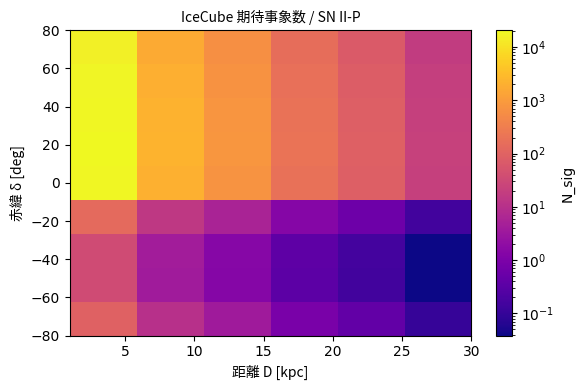

In [ ]:
# ===============================================
#   SN II-P (no-CCSM) – IceCube 信号／背景 早見表
#   Murase flux  +  IC86_II A_eff  +  Honda 2015
# ===============================================

# ------- Colab: 日本語フォント -------------------
!apt-get -y install fonts-noto-cjk > /dev/null
import numpy as np, pandas as pd, re, math
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors          # ← 追加（LogNorm 用）
from pathlib import Path
from io import StringIO
from scipy.interpolate import RegularGridInterpolator

# ---------- 基本パス ----------------------------
DATA_DIR   = Path(".")
SIG_FILE   = "FinalFluxs20.dat"              # 代表：s=2.0
AEFF_FILE  = "IC86_II_effectiveArea.csv"
HONDA_FILE = "spl-ally-20-01-solmin.d"       # 南極 / solar-min
E_TH_GEV   = 30.0                            # 解析エネルギー下限

# ---------- フォント ----------------------------
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# =================================================
# 1) IceCube  A_eff(dec,E)  ------------------------
# =================================================
def build_Aeff2D(csv_path):
    df = pd.read_csv(csv_path, comment="#", sep=r"\s+",
                     names=["logEmin","logEmax","dec_min","dec_max","A"])
    df["E"]   = 10**((df.logEmin + df.logEmax)/2)
    df["dec"] = (df.dec_min + df.dec_max)/2
    pivot     = df.pivot_table(index="dec", columns="E", values="A")
    print(f"[INFO] A_eff grid: dec={len(pivot)}, E={len(pivot.columns)}")
    return RegularGridInterpolator((pivot.index.values,
                                    pivot.columns.values),
                                   pivot.values,
                                   bounds_error=False, fill_value=0.)

A_eff2d = build_Aeff2D(AEFF_FILE)

# =================================================
# 2) Honda 2015 大気表 -----------------------------
# =================================================
def _buf_to_df(lines, cos_mid):
    rec=[]
    for ln in lines:
        ln = re.sub(r"^\s*\d+:\s*", "", ln)       # 行番号除去
        if not ln.strip():            continue
        toks = ln.split()
        if len(toks) < 3:            continue
        try:
            e, n1, n2 = map(float, toks[:3])
            rec.append((cos_mid, e, (n1+n2)*1e-4))   # m^-2 → cm^-2
        except ValueError:
            pass
    return pd.DataFrame(rec, columns=["cos","E","phi"])

def build_phi_atm_table(path):
    hdr = re.compile(r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)")
    blocks, buf, mid = [], [], None
    with open(path, encoding="utf-8", errors="replace") as f:
        for ln in f:
            m = hdr.search(ln)
            if m:
                if buf and mid is not None:
                    blocks.append(_buf_to_df(buf, mid))
                mid = 0.5*(float(m[1])+float(m[2])); buf=[]
                continue
            buf.append(ln)
        if buf and mid is not None:
            blocks.append(_buf_to_df(buf, mid))
    df     = pd.concat(blocks, ignore_index=True)
    pivot  = df.pivot_table(index="cos", columns="E", values="phi").sort_index()
    print(f"[INFO] Honda table: cosZ {len(pivot)} × E {len(pivot.columns)}")
    return RegularGridInterpolator((pivot.index.values,
                                    pivot.columns.values),
                                   pivot.values, bounds_error=False, fill_value=0.)

phi_atm_table = build_phi_atm_table(HONDA_FILE)

def phi_atm(E_GeV, cosZ):
    """Honda νμ+ν̅μ per sr（>1 TeV は E^-3.7 外挿）"""
    E   = np.asarray(E_GeV, dtype=float)
    cos = np.clip(cosZ, 0, 1)
    phi = phi_atm_table((np.full_like(E, cos), np.minimum(E, 1e3)))
    hi  = E > 1e3
    phi[hi] *= (E[hi]/1e3)**-3.7
    return phi                                  # GeV^-1 cm^-2 s^-1 sr^-1

def phi_ast_diff(E_GeV):
    Phi0 = 1.5e-18                               # GeV^-1 cm^-2 s^-1 sr^-1
    return Phi0 * (E_GeV/100)**-2.37 * 2*np.pi   # 北天 2π を想定

# =================================================
# 3) Murase flux (基準距離 10 kpc) ------------------
# =================================================
def load_murase_flux(path, n_blocks=51, ref_d_kpc=10):
    arr   = np.loadtxt(path);  bins = arr.shape[0]//n_blocks
    dat   = arr.reshape(n_blocks, bins, 14)
    E     = dat[0,:,0]*1e-9
    flux  = dat[:,:,7]*1e9 / dat[:,:,10]           # Earth flux
    flag  = dat[:,:,13]
    t     = 1e3 * 10**(0.1*np.arange(n_blocks))
    dt    = np.r_[np.diff(t), np.diff(t)[-1]]
    Φ_E   = (flux*flag*dt[:,None]).sum(0)
    Ttot  = dt[flag.sum(1)>0].sum()
    return E, Φ_E, Ttot, ref_d_kpc

E_ref, Φ_ref, T_ref, D_ref = load_murase_flux(DATA_DIR/SIG_FILE)

# =================================================
# 4) SNR & 期待事象数 ------------------------------
# =================================================
def best_window(dec_deg, E, Φ, T_total):
    mask = E >= E_TH_GEV
    cosZ = np.sin(np.radians(90-dec_deg))
    days = np.logspace(-1, 1.5, 60)              # 0.1–30 day
    best = {"SNR":0.}
    for ΔT in days:
        scale = ΔT*86400/T_total
        Nsig  = np.trapz(Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask])
        Φ_bkg = (phi_atm(E[mask], cosZ)*2*np.pi + phi_ast_diff(E[mask]))
        Nbkg  = np.trapz(Φ_bkg * A_eff2d((dec_deg, E[mask])) * ΔT*86400, E[mask])
        snr   = Nsig / math.sqrt(Nbkg+1e-30)
        if snr > best["SNR"]:
            best = {"Tday":ΔT, "S":Nsig, "B":Nbkg, "SNR":snr}
    return best

def events_for_source(dec_deg, dist_kpc,
                      E=E_ref, Φ_ref=Φ_ref, T_ref=T_ref, D_ref=D_ref):
    Φ_scaled = Φ_ref * (D_ref/dist_kpc)**2       # 1/r^2 スケール
    return best_window(dec_deg, E, Φ_scaled, T_ref)

# =================================================
# 5) 早見表生成 -----------------------------------
# =================================================
def scan_SN_grid(dec_list, dist_list_kpc):
    rec=[]
    for dec in dec_list:
        for d in dist_list_kpc:
            r = events_for_source(dec, d)
            rec.append({"dec":dec, "D_kpc":d,
                        "Nsig":r["S"], "SNR":r["SNR"], "Tday":r["Tday"]})
    df = pd.DataFrame(rec)
    return df.pivot(index="dec", columns="D_kpc", values="Nsig")

# ---------------- サンプル -------------------------
dec_samples  = np.arange(-80, 81, 20)         # -80° ~ +80°
dist_samples = [1, 3, 5, 10, 15, 30]          # kpc

table = scan_SN_grid(dec_samples, dist_samples)

print("\n=== 期待事象数 N_sig（s=2.0, ΔT 最適） ===")
display(table.style.format("{:.1f}"))

plt.figure(figsize=(6,4))
plt.title("IceCube 期待事象数 / SN II-P", fontproperties=font_prop)
im = plt.imshow(table, origin='lower',
                extent=[min(dist_samples), max(dist_samples),
                        min(dec_samples),   max(dec_samples)],
                aspect='auto', cmap='plasma',
                norm=mcolors.LogNorm())           # ← 修正
plt.colorbar(im, label="N_sig")
plt.ylabel("赤緯 δ [deg]", fontproperties=font_prop)
plt.xlabel("距離 D [kpc]", fontproperties=font_prop)
plt.tight_layout(); plt.show()

[INFO] A_eff grid: dec=50, E=40
[INFO] Honda table: cosZ 10 × E 101


<ipython-input-44-6e7d2b7a531d>:148: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nsig  = np.trapz(Φ[mask] * scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-44-6e7d2b7a531d>:150: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nbkg  = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * ΔT * 86400, E[mask])



=== 期待事象数 N_sig（s=2.0, ΔT 最適） ===


D_kpc,1,3,5,10,15,30
dec,,,,,,
-80,92.8,10.3,3.7,0.9,0.4,0.1
-60,34.5,3.8,1.4,0.3,0.2,0.0
-40,36.1,4.0,1.4,0.4,0.2,0.0
-20,135.8,15.1,5.4,1.4,0.6,0.2
0,18785.4,2087.3,751.4,187.9,83.5,20.9
20,20541.1,2282.3,821.6,205.4,91.3,22.8
40,19209.9,2134.4,768.4,192.1,85.4,21.3
60,17663.1,1962.6,706.5,176.6,78.5,19.6
80,15455.9,1717.3,618.2,154.6,68.7,17.2


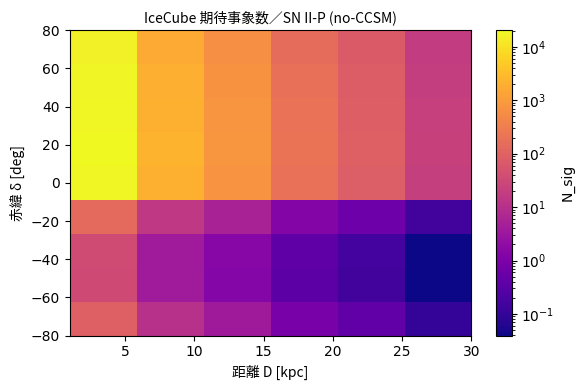

In [ ]:
# ===============================================
#   SN II-P (no-CCSM) – IceCube 信号／背景 早見表
#   ・Murase flux (FinalFluxs*.dat)
#   ・IceCube IC86-II 有効面積 (csv)
#   ・Honda 2015 南極大気表 (spl-ally-20-01-solmin.d)
# ===============================================

# ------- Colab：日本語フォント導入 -------------------
!apt-get -y install fonts-noto-cjk > /dev/null

import numpy as np
import pandas as pd
import re, math
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from pathlib import Path
from io import StringIO
from scipy.interpolate import RegularGridInterpolator

# ---------- 基本パス & パラメータ ------------------
DATA_DIR   = Path(".")
SIG_FILE   = "FinalFluxs20.dat"              # 代表：s=2.0
AEFF_FILE  = "IC86_II_effectiveArea.csv"
HONDA_FILE = "spl-ally-20-01-solmin.d"       # 2.6 South-Pole / Solar-min
E_TH_GEV   = 30.0                            # 解析エネルギー下限

# ---------- フォント設定 ---------------------------
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# =================================================
# 1) IceCube IC86-II 2D 有効面積 A_eff(dec,E) ------
# =================================================
def build_Aeff2D(csv_path):
    df = pd.read_csv(
        csv_path, comment="#", sep=r"\s+",
        names=["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
    )
    df["E_GeV"] = 10 ** ((df.logEmin + df.logEmax) / 2)
    df["dec"]   = (df.dec_min + df.dec_max) / 2
    pivot = df.pivot_table(
        index="dec", columns="E_GeV",
        values="A_eff_cm2", aggfunc="mean"
    )
    dec_grid = pivot.index.values
    E_grid   = pivot.columns.values
    print(f"[INFO] A_eff grid: dec={dec_grid.size}, E={E_grid.size}")
    return RegularGridInterpolator(
        (dec_grid, E_grid),
        pivot.values,
        bounds_error=False, fill_value=0.
    )

A_eff2d = build_Aeff2D(AEFF_FILE)

# =================================================
# 2) Honda 2015 大気ニュートリノ表 ---------------
# =================================================
def _buf_to_df(lines, cos_mid):
    rec = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+:\s*", "", ln)  # 行番号除去
        toks = ln.split()
        if len(toks) < 3:
            continue
        try:
            e, n1, n2 = map(float, toks[:3])
            rec.append((cos_mid, e, (n1 + n2) * 1e-4))  # m^-2 → cm^-2
        except ValueError:
            continue
    return pd.DataFrame(rec, columns=["cosZ","E_GeV","phi"])

def build_phi_atm_table(path):
    hdr = re.compile(
        r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)"
    )
    blocks, buf, mid = [], [], None
    with open(path, encoding="utf-8", errors="replace") as f:
        for ln in f:
            m = hdr.search(ln)
            if m:
                if buf and mid is not None:
                    blocks.append(_buf_to_df(buf, mid))
                mid = 0.5 * (float(m[1]) + float(m[2]))
                buf = []
            else:
                buf.append(ln)
        if buf and mid is not None:
            blocks.append(_buf_to_df(buf, mid))

    big = pd.concat(blocks, ignore_index=True)
    pivot = big.pivot_table(
        index="cosZ", columns="E_GeV", values="phi", aggfunc="mean"
    ).sort_index()
    print(f"[INFO] Honda table: cosZ {len(pivot)} × E {len(pivot.columns)}")
    return RegularGridInterpolator(
        (pivot.index.values, pivot.columns.values),
        pivot.values,
        bounds_error=False, fill_value=0.
    )

phi_atm_table = build_phi_atm_table(HONDA_FILE)

def phi_atm(E_GeV, cosZ):
    """Honda νμ+ν̅μ per sr（>1 TeV は E^-3.7 で外挿）"""
    E   = np.asarray(E_GeV, dtype=float)
    cos = np.clip(cosZ, 0.0, 1.0)
    phi = phi_atm_table((np.full_like(E, cos), np.minimum(E, 1e3)))
    hi  = E > 1e3
    phi[hi] *= (E[hi] / 1e3) ** -3.7
    return phi  # GeV^-1 cm^-2 s^-1 sr^-1

def phi_ast_diff(E_GeV):
    """IceCube 拡散天体成分 (E^-2.37) × 北天 2π sr"""
    Phi0 = 1.5e-18
    return Phi0 * (E_GeV / 100) ** -2.37 * 2 * np.pi

# =================================================
# 3) Murase flux (.dat → Earthフルエンス) ----------
# =================================================
def load_murase_flux(path, n_blocks=51, ref_d_kpc=10):
    arr  = np.loadtxt(path)
    bins = arr.shape[0] // n_blocks
    dat  = arr.reshape(n_blocks, bins, 14)
    E    = dat[0,:,0] * 1e-9
    flux = dat[:,:,7] * 1e9 / dat[:,:,10]  # GeV^-1 s^-1 を cm^-2 に
    flag = dat[:,:,13]
    t    = 1e3 * 10 ** (0.1 * np.arange(n_blocks))
    dt   = np.concatenate([np.diff(t), [np.diff(t)[-1]]])
    Φ_E  = (flux * flag * dt[:,None]).sum(axis=0)  # GeV^-1 cm^-2
    Ttot = dt[flag.sum(axis=1)>0].sum()          # sec
    return E, Φ_E, Ttot, ref_d_kpc

E_ref, Φ_ref, T_ref, D_ref = load_murase_flux(DATA_DIR/SIG_FILE)

# =================================================
# 4) 最適ウィンドウ探索 & 期待事象数 -------------
# =================================================
def best_window(dec_deg, E, Φ, T_total, e_th=E_TH_GEV):
    mask = E >= e_th
    cosZ = np.sin(np.radians(90 - dec_deg))
    days = np.logspace(-1, 1.5, 60)  # 0.1–30 d
    best = {"SNR": 0.0}
    for ΔT in days:
        scale = ΔT * 86400 / T_total
        Nsig  = np.trapz(Φ[mask] * scale * A_eff2d((dec_deg, E[mask])), E[mask])
        Φbkg  = phi_atm(E[mask], cosZ) * 2 * np.pi + phi_ast_diff(E[mask])
        Nbkg  = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * ΔT * 86400, E[mask])
        snr   = Nsig / math.sqrt(max(Nbkg, 1e-30))
        if snr > best["SNR"]:
            best = {"Tday":ΔT, "S":Nsig, "B":Nbkg, "SNR":snr}
    return best

def events_for_source(dec_deg, dist_kpc):
    Φs = Φ_ref * (D_ref / dist_kpc)**2
    return best_window(dec_deg, E_ref, Φs, T_ref)

# =================================================
# 5) 銀河マッピング用早見表作成 -------------------
# =================================================
def scan_SN_grid(dec_list, dist_list):
    rec = []
    for dec in dec_list:
        for d in dist_list:
            r = events_for_source(dec, d)
            rec.append({
                "dec":   dec,
                "D_kpc": d,
                "Nsig":  r["S"],
                "SNR":   r["SNR"],
                "Tday":  r["Tday"]
            })
    df = pd.DataFrame(rec)
    return df.pivot(index="dec", columns="D_kpc", values="Nsig")

# ---------------- サンプル実行 ----------------------
dec_samples  = np.arange(-80, 81, 20)  # −80°…+80°
dist_samples = [1, 3, 5, 10, 15, 30]   # kpc

table = scan_SN_grid(dec_samples, dist_samples)

print("\n=== 期待事象数 N_sig（s=2.0, ΔT 最適） ===")
display(table.style.format("{:.1f}"))

plt.figure(figsize=(6,4))
plt.title("IceCube 期待事象数／SN II-P (no-CCSM)", fontproperties=font_prop)
im = plt.imshow(
    table,
    origin='lower',
    extent=[min(dist_samples), max(dist_samples),
            min(dec_samples),   max(dec_samples)],
    aspect='auto',
    cmap='plasma',
    norm=mcolors.LogNorm(vmin=table.values.min()+1e-3, vmax=table.values.max())
)
plt.colorbar(im, label="N_sig")
plt.xlabel("距離 D [kpc]", fontproperties=font_prop)
plt.ylabel("赤緯 δ [deg]", fontproperties=font_prop)
plt.tight_layout()
plt.show()

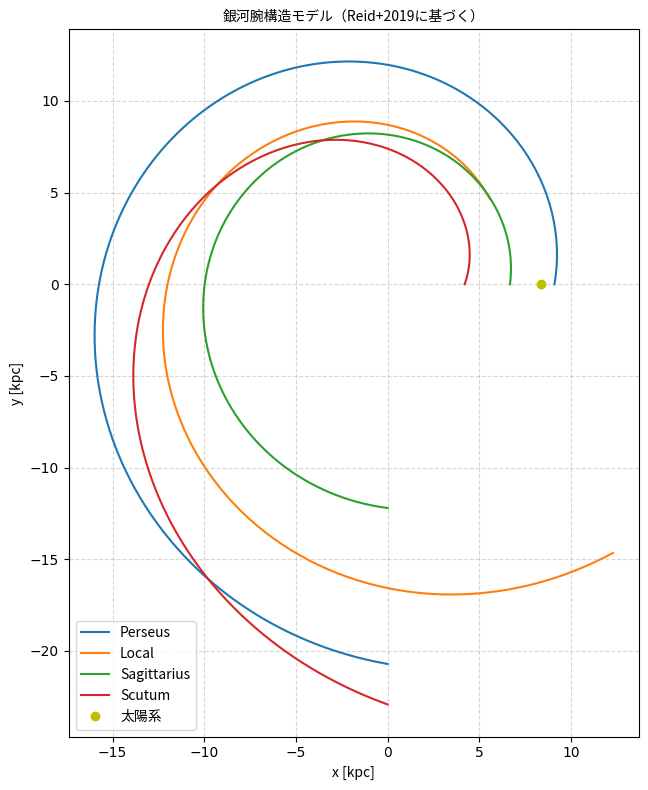

In [ ]:
# ✅ 日本語フォントと基礎ライブラリ（Colab用）
!apt-get -y install fonts-noto-cjk > /dev/null

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# ✅ 銀河腕モデル（Reid+2019, Table 2の代表例） --------------------
spiral_arms = {
    "Perseus":    {"theta_range": [0, 270], "R_ref": 9.9, "theta_ref": 27.7, "pitch": 9.9},
    "Local":      {"theta_range": [40, 310], "R_ref": 8.3, "theta_ref": 77.0, "pitch": 11.6},
    "Sagittarius": {"theta_range": [0, 270], "R_ref": 7.1, "theta_ref": 27.7, "pitch": 7.3},
    "Scutum":     {"theta_range": [0, 270], "R_ref": 5.0, "theta_ref": 27.7, "pitch": 19.8},
}

# ✅ スパイラルアームの方程式 --------------------------
def arm_curve(R_ref, theta_ref, pitch_deg, theta_range_deg):
    """ログスパイラル式に従い、(x, y) を返す"""
    theta_ref = np.radians(theta_ref)
    pitch_rad = np.radians(pitch_deg)
    theta = np.radians(np.linspace(*theta_range_deg, 1000))
    r = R_ref * np.exp((theta - theta_ref) * np.tan(pitch_rad))
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

# ✅ 銀河面マップの描画 ------------------------------
plt.figure(figsize=(8, 8))
for name, param in spiral_arms.items():
    x, y = arm_curve(
        param["R_ref"],
        param["theta_ref"],
        param["pitch"],
        param["theta_range"]
    )
    plt.plot(x, y, label=name)

# 太陽系位置
plt.plot(8.34, 0, "yo", label="太陽系")

plt.gca().set_aspect("equal")
plt.title("銀河腕構造モデル（Reid+2019に基づく）", fontproperties=font_prop)
plt.xlabel("x [kpc]", fontproperties=font_prop)
plt.ylabel("y [kpc]", fontproperties=font_prop)
plt.grid(True, ls="--", alpha=0.5)
plt.legend(prop=font_prop)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

R0 = 8.34  # kpc, 太陽-銀河中心距離

def xy_to_lb(x, y, R0=R0):
    """
    (x,y) in kpc -> (l_deg, b_deg)
    x: Galactocentric X (positive toward l=90°)
    y: Galactocentric Y (positive toward Sun)
    b: 銀河面上だから常に 0
    """
    # ソース相対座標: 太陽を (0,0) にシフト
    dx =  x           # X は変えず
    dy =  y - R0      # Y は銀河中心から太陽分だけオフセット
    # 銀河経度 l (rad)。 (dx,dy) → arctan2(dx, dy)
    l_rad = np.arctan2(dx, dy)
    # 範囲を [0,360) に
    l_deg = (np.degrees(l_rad) + 360) % 360
    b_deg = np.zeros_like(l_deg)   # 銀河面上なので常に 0
    return l_deg, b_deg

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u

def lb_to_radec(l_deg, b_deg):
    """
    銀河座標 (l_deg, b_deg) → ICRS (RA,Dec) [deg]
    """
    c_gal = SkyCoord(l=l_deg*u.deg, b=b_deg*u.deg, frame='galactic')
    c_icrs = c_gal.icrs
    return c_icrs.ra.deg, c_icrs.dec.deg

In [ ]:
# 先ほどの Reid+2019 arm_curve 関数をそのまま使います
# spiral_arms dict もおなじものを利用

# サンプル実行
all_radec = {}  # 腕ごとに (RA,Dec) のリストを格納

for name, param in spiral_arms.items():
    # 1) x,y を生成
    x, y = arm_curve(param["R_ref"],
                     param["theta_ref"],
                     param["pitch"],
                     param["theta_range"])
    # 2) x,y → l,b
    l_deg, b_deg = xy_to_lb(x, y, R0=R0)
    # 3) l,b → RA,Dec
    ra_deg, dec_deg = lb_to_radec(l_deg, b_deg)
    all_radec[name] = (ra_deg, dec_deg)

# 確認：Perseus arm の最初の 5 点
print("Perseus RA,Dec [deg]:\n",
      np.vstack([all_radec["Perseus"][0][:5],
                 all_radec["Perseus"][1][:5]]).T)

Perseus RA,Dec [deg]:
 [[33.16339486 61.3525746 ]
 [32.82455633 61.40481101]
 [32.48403983 61.45628512]
 [32.14184827 61.50698878]
 [31.79798492 61.5569138 ]]


[INFO] A_eff grid: dec=50, E=40
[INFO] Honda table: cosZ 10 × E 101


<ipython-input-11-05d23551c796>:143: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nsig  = np.trapz(Φ[mask] * scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-11-05d23551c796>:145: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nbkg  = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * ΔT * 86400, E[mask])



=== δ-grid版 N_sig ===


D_kpc,1,3,5,10,15,30
dec,,,,,,
-80,92.8,10.3,3.7,0.9,0.4,0.1
-75,71.5,7.9,2.9,0.7,0.3,0.1
-70,50.9,5.7,2.0,0.5,0.2,0.1
-65,41.4,4.6,1.7,0.4,0.2,0.0
-60,34.5,3.8,1.4,0.3,0.2,0.0
-55,32.0,3.6,1.3,0.3,0.1,0.0
-50,31.2,3.5,1.2,0.3,0.1,0.0
-45,32.0,3.6,1.3,0.3,0.1,0.0
-40,36.1,4.0,1.4,0.4,0.2,0.0


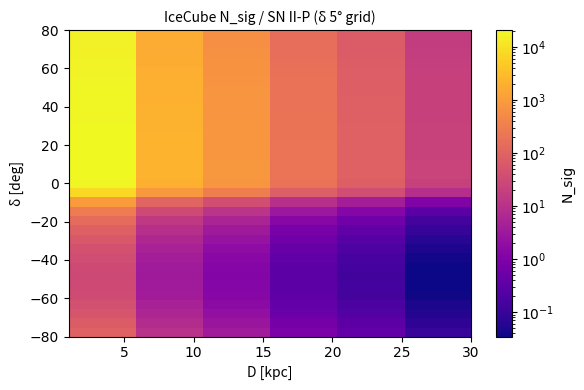

<ipython-input-11-05d23551c796>:143: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nsig  = np.trapz(Φ[mask] * scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-11-05d23551c796>:145: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nbkg  = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * ΔT * 86400, E[mask])



=== 腕上スキャン版 N_sig ===


D_kpc,1,3,5,10,15,30
arm,,,,,,
Local,13871.8,1541.3,554.9,138.7,61.7,15.4
Perseus,16239.8,1804.4,649.6,162.4,72.2,18.0
Sagittarius,16987.6,1887.5,679.5,169.9,75.5,18.9
Scutum,16465.8,1829.5,658.6,164.7,73.2,18.3


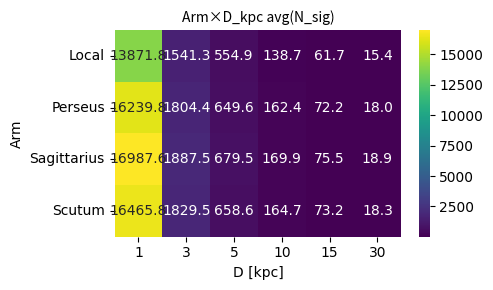

In [ ]:
# ===============================================
#   SN II-P (no-CCSM) – IceCube 信号／背景 早見表
#   ・Murase flux (FinalFluxs*.dat)
#   ・IceCube IC86-II 有効面積 (csv)
#   ・Honda 2015 南極大気表 (spl-ally-20-01-solmin.d)
# ===============================================

# ------- Colab：日本語フォント導入 -------------------
!apt-get -y install fonts-noto-cjk > /dev/null

import numpy as np
import pandas as pd
import re, math
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator

# ---------- 基本パス & パラメータ ------------------
DATA_DIR   = Path(".")
SIG_FILE   = "FinalFluxs20.dat"
AEFF_FILE  = "IC86_II_effectiveArea.csv"
HONDA_FILE = "spl-ally-20-01-solmin.d"
E_TH_GEV   = 30.0

# ---------- フォント設定 ---------------------------
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# =================================================
# 1) IceCube IC86-II 2D 有効面積 A_eff(dec,E) ------
# =================================================
def build_Aeff2D(csv_path):
    df = pd.read_csv(
        csv_path, comment="#", sep=r"\s+",
        names=["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
    )
    df["E_GeV"] = 10 ** ((df.logEmin + df.logEmax) / 2)
    df["dec"]   = (df.dec_min + df.dec_max) / 2
    pivot = df.pivot_table(
        index="dec", columns="E_GeV", values="A_eff_cm2", aggfunc="mean"
    )
    dec_grid = pivot.index.values
    E_grid   = pivot.columns.values
    print(f"[INFO] A_eff grid: dec={dec_grid.size}, E={E_grid.size}")
    return RegularGridInterpolator(
        (dec_grid, E_grid),
        pivot.values,
        bounds_error=False, fill_value=0.
    )

A_eff2d = build_Aeff2D(AEFF_FILE)

# =================================================
# 2) Honda 2015 大気ニュートリノ表 ---------------
# =================================================
def _buf_to_df(lines, cos_mid):
    rec = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+:\s*", "", ln)
        toks = ln.split()
        if len(toks) < 3:
            continue
        try:
            e, n1, n2 = map(float, toks[:3])
            rec.append((cos_mid, e, (n1 + n2) * 1e-4))
        except ValueError:
            continue
    return pd.DataFrame(rec, columns=["cosZ","E_GeV","phi"])

def build_phi_atm_table(path):
    hdr = re.compile(
        r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)"
    )
    blocks, buf, mid = [], [], None
    with open(path, encoding="utf-8", errors="replace") as f:
        for ln in f:
            m = hdr.search(ln)
            if m:
                if buf and mid is not None:
                    blocks.append(_buf_to_df(buf, mid))
                mid, buf = 0.5*(float(m[1])+float(m[2])), []
            else:
                buf.append(ln)
        if buf and mid is not None:
            blocks.append(_buf_to_df(buf, mid))

    big = pd.concat(blocks, ignore_index=True)
    pivot = big.pivot_table(
        index="cosZ", columns="E_GeV", values="phi", aggfunc="mean"
    ).sort_index()
    print(f"[INFO] Honda table: cosZ {len(pivot)} × E {len(pivot.columns)}")
    return RegularGridInterpolator(
        (pivot.index.values, pivot.columns.values),
        pivot.values,
        bounds_error=False, fill_value=0.
    )

phi_atm_table = build_phi_atm_table(HONDA_FILE)

def phi_atm(E_GeV, cosZ):
    E   = np.asarray(E_GeV, dtype=float)
    cos = np.clip(cosZ, 0.0, 1.0)
    phi = phi_atm_table((np.full_like(E, cos), np.minimum(E, 1e3)))
    hi  = E > 1e3
    phi[hi] *= (E[hi] / 1e3) ** -3.7
    return phi

def phi_ast_diff(E_GeV):
    Phi0 = 1.5e-18
    return Phi0 * (E_GeV / 100) ** -2.37 * 2 * np.pi

# =================================================
# 3) Murase flux (.dat → Earthフルエンス) ----------
# =================================================
def load_murase_flux(path, n_blocks=51, ref_d_kpc=10):
    arr  = np.loadtxt(path)
    bins = arr.shape[0] // n_blocks
    dat  = arr.reshape(n_blocks, bins, 14)
    E    = dat[0,:,0] * 1e-9
    flux = dat[:,:,7] * 1e9 / dat[:,:,10]
    flag = dat[:,:,13]
    t    = 1e3 * 10 ** (0.1 * np.arange(n_blocks))
    dt   = np.concatenate([np.diff(t), [np.diff(t)[-1]]])
    Φ_E  = (flux * flag * dt[:,None]).sum(axis=0)
    Ttot = dt[flag.sum(axis=1)>0].sum()
    return E, Φ_E, Ttot, ref_d_kpc

E_ref, Φ_ref, T_ref, D_ref = load_murase_flux(DATA_DIR/SIG_FILE)

# =================================================
# 4) 最適ウィンドウ探索 & 期待事象数 -------------
# =================================================
def best_window(dec_deg, E, Φ, T_total, e_th=E_TH_GEV):
    mask = E >= e_th
    cosZ = np.sin(np.radians(90 - dec_deg))
    days = np.logspace(-1, 1.5, 60)
    best = {"SNR": 0.0}
    for ΔT in days:
        scale = ΔT * 86400 / T_total
        Nsig  = np.trapz(Φ[mask] * scale * A_eff2d((dec_deg, E[mask])), E[mask])
        Φbkg  = phi_atm(E[mask], cosZ) * 2 * np.pi + phi_ast_diff(E[mask])
        Nbkg  = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * ΔT * 86400, E[mask])
        snr   = Nsig / math.sqrt(max(Nbkg, 1e-30))
        if snr > best["SNR"]:
            best = {"Tday":ΔT, "S":Nsig, "B":Nbkg, "SNR":snr}
    return best

def events_for_source(dec_deg, dist_kpc):
    Φs = Φ_ref * (D_ref / dist_kpc)**2
    return best_window(dec_deg, E_ref, Φs, T_ref)

# =================================================
# 5) 早見表: scan_SN_grid を dec→5°間隔に変更 ----  ← CHANGE①
# =================================================
def scan_SN_grid(dec_list, dist_list):
    rec = []
    for dec in dec_list:
        for d in dist_list:
            r = events_for_source(dec, d)
            rec.append({
                "dec":   dec,
                "D_kpc": d,
                "Nsig":  r["S"],
                "SNR":   r["SNR"],
                "Tday":  r["Tday"]
            })
    df = pd.DataFrame(rec)
    return df.pivot(index="dec", columns="D_kpc", values="Nsig")

# =================================================
# 6) 銀河腕用: scan_SN_on_arms を新設              ← CHANGE②
# =================================================
# （腕上の (ra,dec) 全組み合わせ × 距離 のテーブルを一気に生成）
def scan_SN_on_arms(all_radec, dist_list):
    rec=[]
    for arm_name, (ra_arr, dec_arr) in all_radec.items():
        for ra, dec in zip(ra_arr, dec_arr):
            for d in dist_list:
                r = events_for_source(dec, d)
                rec.append({
                    "arm":   arm_name,
                    "ra":    ra,
                    "dec":   dec,
                    "D_kpc": d,
                    "Nsig":  r["S"],
                    "SNR":   r["SNR"],
                })
    return pd.DataFrame(rec)

# --------------------------------
# ☆ 銀河腕モデルから (ra,dec) を生成
# --------------------------------
# （Reid+2019 の spiral_arms 定義が必要）
spiral_arms = {
    "Perseus":     {"theta_range":[0,270], "R_ref":9.9, "theta_ref":27.7, "pitch":9.9},
    "Local":       {"theta_range":[40,310],"R_ref":8.3, "theta_ref":77.0, "pitch":11.6},
    "Sagittarius":{"theta_range":[0,270], "R_ref":7.1, "theta_ref":27.7, "pitch":7.3},
    "Scutum":      {"theta_range":[0,270], "R_ref":5.0, "theta_ref":27.7, "pitch":19.8},
}
def arm_curve(R_ref, theta_ref, pitch_deg, theta_range_deg):
    theta_ref = np.radians(theta_ref)
    pitch_rad = np.radians(pitch_deg)
    theta     = np.radians(np.linspace(*theta_range_deg, 500))
    r         = R_ref * np.exp((theta - theta_ref) * np.tan(pitch_rad))
    return r*np.cos(theta), r*np.sin(theta)

# 座標変換関数: (x,y)→(l,b)→(ra,dec) を用意
def xy_to_lb(x, y, R0=8.34):
    # Galactocentric→銀経 l, 銀緯 b
    l  = np.degrees(np.arctan2(y, x - R0)) % 360
    b  = np.zeros_like(l)
    return l, b

def lb_to_radec(l, b):
    # astropy を使うのが手軽ですが、自前で簡易版も可
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    c_gal  = SkyCoord(l=l*u.deg, b=b*u.deg, frame="galactic")  # 銀河座標
    c_icrs = c_gal.icrs                                       # ICRS に変換
    return c_icrs.ra.deg, c_icrs.dec.deg

# 全腕上 (ra,dec) を用意
all_radec = {}
for name, p in spiral_arms.items():
    x,y   = arm_curve(p["R_ref"], p["theta_ref"], p["pitch"], p["theta_range"])
    l,b   = xy_to_lb(x, y)
    ra, dec = lb_to_radec(l, b)
    all_radec[name] = (ra, dec)

# --------------------------------
# 7) 実行例
# --------------------------------
# 7-1: dec_grid 早見表 (δ＝5°間隔)
dec_samples  = np.arange(-80, 81, 5)      # ← CHANGE①
dist_samples = [1,3,5,10,15,30]

table = scan_SN_grid(dec_samples, dist_samples)
print("\n=== δ-grid版 N_sig ===")
display(table.style.format("{:.1f}"))

plt.figure(figsize=(6,4))
plt.title("IceCube N_sig / SN II-P (δ 5° grid)", fontproperties=font_prop)
im = plt.imshow(
    table, origin='lower',
    extent=[min(dist_samples), max(dist_samples),
            min(dec_samples),   max(dec_samples)],
    aspect='auto', cmap='plasma', norm=mcolors.LogNorm()
)
plt.colorbar(im, label="N_sig")
plt.ylabel("δ [deg]", fontproperties=font_prop)
plt.xlabel("D [kpc]",  fontproperties=font_prop)
plt.tight_layout(); plt.show()

# 7-2: 腕上スキャン版
df_arms = scan_SN_on_arms(all_radec, dist_samples)
pivot   = df_arms.pivot_table(
    index="arm", columns="D_kpc",
    values="Nsig", aggfunc="mean"
)
print("\n=== 腕上スキャン版 N_sig ===")
display(pivot.style.format("{:.1f}"))

plt.figure(figsize=(5,3))
import seaborn as sns
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="viridis")
plt.title("Arm×D_kpc avg(N_sig)", fontproperties=font_prop)
plt.ylabel("Arm")
plt.xlabel("D [kpc]")
plt.tight_layout(); plt.show()

[INFO] A_eff grid: dec=50, E=40
[INFO] Honda table: cosZ 10 × E 101


<ipython-input-12-db03b8e31283>:143: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nsig  = np.trapz(Φ[mask] * scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-12-db03b8e31283>:145: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nbkg  = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * ΔT * 86400, E[mask])


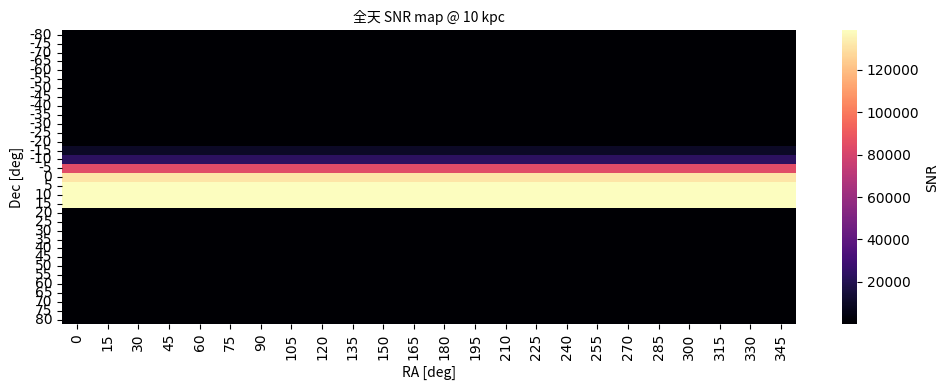

In [ ]:
# ===============================================
#   SN II-P (no-CCSM) – IceCube 信号／背景 早見表
#   ・Murase flux (FinalFluxs*.dat)
#   ・IceCube IC86-II 有効面積 (csv)
#   ・Honda 2015 南極大気表 (spl-ally-20-01-solmin.d)
# ===============================================

# ------- Colab：日本語フォント導入 -------------------
!apt-get -y install fonts-noto-cjk > /dev/null

import numpy as np
import pandas as pd
import re, math
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator

# ---------- 基本パス & パラメータ ------------------
DATA_DIR   = Path(".")
SIG_FILE   = "FinalFluxs20.dat"
AEFF_FILE  = "IC86_II_effectiveArea.csv"
HONDA_FILE = "spl-ally-20-01-solmin.d"
E_TH_GEV   = 30.0

# ---------- フォント設定 ---------------------------
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# =================================================
# 1) IceCube IC86-II 2D 有効面積 A_eff(dec,E) ------
# =================================================
def build_Aeff2D(csv_path):
    df = pd.read_csv(
        csv_path, comment="#", sep=r"\s+",
        names=["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
    )
    df["E_GeV"] = 10 ** ((df.logEmin + df.logEmax) / 2)
    df["dec"]   = (df.dec_min + df.dec_max) / 2
    pivot = df.pivot_table(
        index="dec", columns="E_GeV", values="A_eff_cm2", aggfunc="mean"
    )
    dec_grid = pivot.index.values
    E_grid   = pivot.columns.values
    print(f"[INFO] A_eff grid: dec={dec_grid.size}, E={E_grid.size}")
    return RegularGridInterpolator(
        (dec_grid, E_grid),
        pivot.values,
        bounds_error=False, fill_value=0.
    )

A_eff2d = build_Aeff2D(AEFF_FILE)

# =================================================
# 2) Honda 2015 大気ニュートリノ表 ---------------
# =================================================
def _buf_to_df(lines, cos_mid):
    rec = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+:\s*", "", ln)
        toks = ln.split()
        if len(toks) < 3:
            continue
        try:
            e, n1, n2 = map(float, toks[:3])
            rec.append((cos_mid, e, (n1 + n2) * 1e-4))
        except ValueError:
            continue
    return pd.DataFrame(rec, columns=["cosZ","E_GeV","phi"])

def build_phi_atm_table(path):
    hdr = re.compile(
        r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)"
    )
    blocks, buf, mid = [], [], None
    with open(path, encoding="utf-8", errors="replace") as f:
        for ln in f:
            m = hdr.search(ln)
            if m:
                if buf and mid is not None:
                    blocks.append(_buf_to_df(buf, mid))
                mid, buf = 0.5*(float(m[1])+float(m[2])), []
            else:
                buf.append(ln)
        if buf and mid is not None:
            blocks.append(_buf_to_df(buf, mid))

    big = pd.concat(blocks, ignore_index=True)
    pivot = big.pivot_table(
        index="cosZ", columns="E_GeV", values="phi", aggfunc="mean"
    ).sort_index()
    print(f"[INFO] Honda table: cosZ {len(pivot)} × E {len(pivot.columns)}")
    return RegularGridInterpolator(
        (pivot.index.values, pivot.columns.values),
        pivot.values,
        bounds_error=False, fill_value=0.
    )

phi_atm_table = build_phi_atm_table(HONDA_FILE)

def phi_atm(E_GeV, cosZ):
    E   = np.asarray(E_GeV, dtype=float)
    cos = np.clip(cosZ, 0.0, 1.0)
    phi = phi_atm_table((np.full_like(E, cos), np.minimum(E, 1e3)))
    hi  = E > 1e3
    phi[hi] *= (E[hi] / 1e3) ** -3.7
    return phi

def phi_ast_diff(E_GeV):
    Phi0 = 1.5e-18
    return Phi0 * (E_GeV / 100) ** -2.37 * 2 * np.pi

# =================================================
# 3) Murase flux (.dat → Earthフルエンス) ----------
# =================================================
def load_murase_flux(path, n_blocks=51, ref_d_kpc=10):
    arr  = np.loadtxt(path)
    bins = arr.shape[0] // n_blocks
    dat  = arr.reshape(n_blocks, bins, 14)
    E    = dat[0,:,0] * 1e-9
    flux = dat[:,:,7] * 1e9 / dat[:,:,10]
    flag = dat[:,:,13]
    t    = 1e3 * 10 ** (0.1 * np.arange(n_blocks))
    dt   = np.concatenate([np.diff(t), [np.diff(t)[-1]]])
    Φ_E  = (flux * flag * dt[:,None]).sum(axis=0)
    Ttot = dt[flag.sum(axis=1)>0].sum()
    return E, Φ_E, Ttot, ref_d_kpc

E_ref, Φ_ref, T_ref, D_ref = load_murase_flux(DATA_DIR/SIG_FILE)

# =================================================
# 4) 最適ウィンドウ探索 & 期待事象数 -------------
# =================================================
def best_window(dec_deg, E, Φ, T_total, e_th=E_TH_GEV):
    mask = E >= e_th
    cosZ = np.sin(np.radians(90 - dec_deg))
    days = np.logspace(-1, 1.5, 60)
    best = {"SNR": 0.0}
    for ΔT in days:
        scale = ΔT * 86400 / T_total
        Nsig  = np.trapz(Φ[mask] * scale * A_eff2d((dec_deg, E[mask])), E[mask])
        Φbkg  = phi_atm(E[mask], cosZ) * 2 * np.pi + phi_ast_diff(E[mask])
        Nbkg  = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * ΔT * 86400, E[mask])
        snr   = Nsig / math.sqrt(max(Nbkg, 1e-30))
        if snr > best["SNR"]:
            best = {"Tday":ΔT, "S":Nsig, "B":Nbkg, "SNR":snr}
    return best

def events_for_source(dec_deg, dist_kpc):
    Φs = Φ_ref * (D_ref / dist_kpc)**2
    return best_window(dec_deg, E_ref, Φs, T_ref)

# =================================================
# 5) 早見表: scan_SN_grid を dec→5°間隔に変更 ----  ← CHANGE①
# =================================================
def scan_SN_grid(dec_list, dist_list):
    rec = []
    for dec in dec_list:
        for d in dist_list:
            r = events_for_source(dec, d)
            rec.append({
                "dec":   dec,
                "D_kpc": d,
                "Nsig":  r["S"],
                "SNR":   r["SNR"],
                "Tday":  r["Tday"]
            })
    df = pd.DataFrame(rec)
    return df.pivot(index="dec", columns="D_kpc", values="Nsig")

# =================================================
# 6) 銀河腕用: scan_SN_on_arms を新設              ← CHANGE②
# =================================================
# （腕上の (ra,dec) 全組み合わせ × 距離 のテーブルを一気に生成）
def scan_SN_on_arms(all_radec, dist_list):
    rec=[]
    for arm_name, (ra_arr, dec_arr) in all_radec.items():
        for ra, dec in zip(ra_arr, dec_arr):
            for d in dist_list:
                r = events_for_source(dec, d)
                rec.append({
                    "arm":   arm_name,
                    "ra":    ra,
                    "dec":   dec,
                    "D_kpc": d,
                    "Nsig":  r["S"],
                    "SNR":   r["SNR"],
                })
    return pd.DataFrame(rec)

# --------------------------------
# ☆ 銀河腕モデルから (ra,dec) を生成
# --------------------------------
# （Reid+2019 の spiral_arms 定義が必要）
spiral_arms = {
    "Perseus":     {"theta_range":[0,270], "R_ref":9.9, "theta_ref":27.7, "pitch":9.9},
    "Local":       {"theta_range":[40,310],"R_ref":8.3, "theta_ref":77.0, "pitch":11.6},
    "Sagittarius":{"theta_range":[0,270], "R_ref":7.1, "theta_ref":27.7, "pitch":7.3},
    "Scutum":      {"theta_range":[0,270], "R_ref":5.0, "theta_ref":27.7, "pitch":19.8},
}
def arm_curve(R_ref, theta_ref, pitch_deg, theta_range_deg):
    theta_ref = np.radians(theta_ref)
    pitch_rad = np.radians(pitch_deg)
    theta     = np.radians(np.linspace(*theta_range_deg, 500))
    r         = R_ref * np.exp((theta - theta_ref) * np.tan(pitch_rad))
    return r*np.cos(theta), r*np.sin(theta)

# 座標変換関数: (x,y)→(l,b)→(ra,dec) を用意
def xy_to_lb(x, y, R0=8.34):
    # Galactocentric→銀経 l, 銀緯 b
    l  = np.degrees(np.arctan2(y, x - R0)) % 360
    b  = np.zeros_like(l)
    return l, b

def lb_to_radec(l, b):
    # astropy を使うのが手軽ですが、自前で簡易版も可
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    c_gal  = SkyCoord(l=l*u.deg, b=b*u.deg, frame="galactic")  # 銀河座標
    c_icrs = c_gal.icrs                                       # ICRS に変換
    return c_icrs.ra.deg, c_icrs.dec.deg

# 全腕上 (ra,dec) を用意
all_radec = {}
for name, p in spiral_arms.items():
    x,y   = arm_curve(p["R_ref"], p["theta_ref"], p["pitch"], p["theta_range"])
    l,b   = xy_to_lb(x, y)
    ra, dec = lb_to_radec(l, b)
    all_radec[name] = (ra, dec)

# 7) 全天グリッドスキャン — ここから貼り替え

# 7-1 定義済みのグリッドを使って、RA–Dec–距離の三重ループで SNR を計算
ra_samples  = np.arange(0, 360, 15)   # 15°刻み（24分割）
dec_samples = np.arange(-80, 81, 5)   # 5°刻み
dist_samples = [1,3,5,10,15,30]       # kpc

records = []
for ra in ra_samples:
    for dec in dec_samples:
        for d in dist_samples:
            # dec→best_window（events_for_source）でSNRを取得
            res = events_for_source(dec, d)
            records.append({
                "ra": ra, "dec": dec, "d": d,
                "Nsig": res["S"], "SNR": res["SNR"]
            })
df_all = pd.DataFrame(records)

# 7-2 例：距離＝10 kpc のときの全天 SNR マップを描画
df10 = df_all.query("d == 10")\
            .pivot(index="dec", columns="ra", values="SNR")

plt.figure(figsize=(10,4))
plt.title("全天 SNR map @ 10 kpc", fontproperties=font_prop)
sns.heatmap(
    df10, cmap="magma",
    cbar_kws={"label":"SNR"},
    xticklabels=ra_samples, yticklabels=dec_samples
)
plt.xlabel("RA [deg]",  fontproperties=font_prop)
plt.ylabel("Dec [deg]", fontproperties=font_prop)
plt.tight_layout()
plt.show()

# 7-3 (オプション) 距離ごとに別パネルや Iso-SNR ラインを重ねるなど
# for d in dist_samples:
#     …同様に pivot して imshow／contour で描画…

[INFO] A_eff grid: dec=50, E=40
[INFO] Honda table: cosZ 10 × E 101


<ipython-input-11-de28216001f2>:143: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nsig  = np.trapz(Φ[mask] * scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-11-de28216001f2>:145: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nbkg  = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * ΔT * 86400, E[mask])


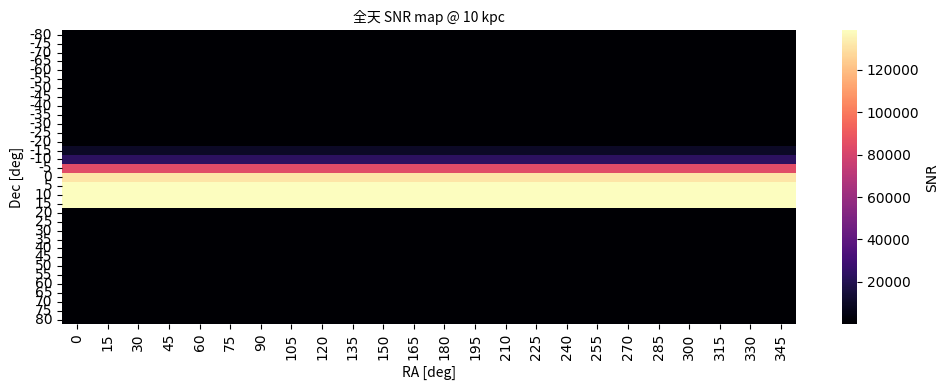

In [ ]:
# ===============================================
#   SN II-P (no-CCSM) – IceCube 信号／背景 早見表
#   ・Murase flux (FinalFluxs*.dat)
#   ・IceCube IC86-II 有効面積 (csv)
#   ・Honda 2015 南極大気表 (spl-ally-20-01-solmin.d)
# ===============================================

# ------- Colab：日本語フォント導入 -------------------
!apt-get -y install fonts-noto-cjk > /dev/null

import numpy as np
import pandas as pd
import re, math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator

# ---------- 基本パス & パラメータ ------------------
DATA_DIR   = Path(".")
SIG_FILE   = "FinalFluxs20.dat"
AEFF_FILE  = "IC86_II_effectiveArea.csv"
HONDA_FILE = "spl-ally-20-01-solmin.d"
E_TH_GEV   = 30.0

# ---------- フォント設定 ---------------------------
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# =================================================
# 1) IceCube IC86-II 2D 有効面積 A_eff(dec,E) ------
# =================================================
def build_Aeff2D(csv_path):
    df = pd.read_csv(
        csv_path, comment="#", sep=r"\s+",
        names=["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
    )
    df["E_GeV"] = 10 ** ((df.logEmin + df.logEmax) / 2)
    df["dec"]   = (df.dec_min + df.dec_max) / 2
    pivot = df.pivot_table(
        index="dec", columns="E_GeV", values="A_eff_cm2", aggfunc="mean"
    )
    dec_grid = pivot.index.values
    E_grid   = pivot.columns.values
    print(f"[INFO] A_eff grid: dec={dec_grid.size}, E={E_grid.size}")
    return RegularGridInterpolator(
        (dec_grid, E_grid),
        pivot.values,
        bounds_error=False, fill_value=0.
    )

A_eff2d = build_Aeff2D(AEFF_FILE)

# =================================================
# 2) Honda 2015 大気ニュートリノ表 ---------------
# =================================================
def _buf_to_df(lines, cos_mid):
    rec = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+:\s*", "", ln)
        toks = ln.split()
        if len(toks) < 3:
            continue
        try:
            e, n1, n2 = map(float, toks[:3])
            rec.append((cos_mid, e, (n1 + n2) * 1e-4))
        except ValueError:
            continue
    return pd.DataFrame(rec, columns=["cosZ","E_GeV","phi"])

def build_phi_atm_table(path):
    hdr = re.compile(
        r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)"
    )
    blocks, buf, mid = [], [], None
    with open(path, encoding="utf-8", errors="replace") as f:
        for ln in f:
            m = hdr.search(ln)
            if m:
                if buf and mid is not None:
                    blocks.append(_buf_to_df(buf, mid))
                mid, buf = 0.5*(float(m[1])+float(m[2])), []
            else:
                buf.append(ln)
        if buf and mid is not None:
            blocks.append(_buf_to_df(buf, mid))

    big = pd.concat(blocks, ignore_index=True)
    pivot = big.pivot_table(
        index="cosZ", columns="E_GeV", values="phi", aggfunc="mean"
    ).sort_index()
    print(f"[INFO] Honda table: cosZ {len(pivot)} × E {len(pivot.columns)}")
    return RegularGridInterpolator(
        (pivot.index.values, pivot.columns.values),
        pivot.values,
        bounds_error=False, fill_value=0.
    )

phi_atm_table = build_phi_atm_table(HONDA_FILE)

def phi_atm(E_GeV, cosZ):
    E   = np.asarray(E_GeV, dtype=float)
    cos = np.clip(cosZ, 0.0, 1.0)
    phi = phi_atm_table((np.full_like(E, cos), np.minimum(E, 1e3)))
    hi  = E > 1e3
    phi[hi] *= (E[hi] / 1e3) ** -3.7
    return phi

def phi_ast_diff(E_GeV):
    Phi0 = 1.5e-18
    return Phi0 * (E_GeV / 100) ** -2.37 * 2 * np.pi

# =================================================
# 3) Murase flux (.dat → Earthフルエンス) ----------
# =================================================
def load_murase_flux(path, n_blocks=51, ref_d_kpc=10):
    arr  = np.loadtxt(path)
    bins = arr.shape[0] // n_blocks
    dat  = arr.reshape(n_blocks, bins, 14)
    E    = dat[0,:,0] * 1e-9
    flux = dat[:,:,7] * 1e9 / dat[:,:,10]
    flag = dat[:,:,13]
    t    = 1e3 * 10 ** (0.1 * np.arange(n_blocks))
    dt   = np.concatenate([np.diff(t), [np.diff(t)[-1]]])
    Φ_E  = (flux * flag * dt[:,None]).sum(axis=0)
    Ttot = dt[flag.sum(axis=1)>0].sum()
    return E, Φ_E, Ttot, ref_d_kpc

E_ref, Φ_ref, T_ref, D_ref = load_murase_flux(DATA_DIR/SIG_FILE)

# =================================================
# 4) 最適ウィンドウ探索 & 期待事象数 -------------
# =================================================
def best_window(dec_deg, E, Φ, T_total, e_th=E_TH_GEV):
    mask = E >= e_th
    cosZ = np.sin(np.radians(90 - dec_deg))
    days = np.logspace(-1, 1.5, 60)
    best = {"SNR": 0.0}
    for ΔT in days:
        scale = ΔT * 86400 / T_total
        Nsig  = np.trapz(Φ[mask] * scale * A_eff2d((dec_deg, E[mask])), E[mask])
        Φbkg  = phi_atm(E[mask], cosZ) * 2 * np.pi + phi_ast_diff(E[mask])
        Nbkg  = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * ΔT * 86400, E[mask])
        snr   = Nsig / math.sqrt(max(Nbkg, 1e-30))
        if snr > best["SNR"]:
            best = {"Tday":ΔT, "S":Nsig, "B":Nbkg, "SNR":snr}
    return best

# ──────────────────────────────────────────
# wrapper：後でスケール誤差を反映できるよう分離
# ──────────────────────────────────────────
def _base_events_for_source(dec_deg, dist_kpc):
    Φs = Φ_ref * (D_ref / dist_kpc)**2
    best = best_window(dec_deg, E_ref, Φs, T_ref)
    return {"S": best["S"], "B": best["B"], "Tday": best["Tday"], "SNR": best["SNR"]}

def events_for_source(dec_deg, dist_kpc,
                      flux_scale=1.0,
                      gamma_shift=0.0,
                      aeff_scale=1.0,
                      atm_scale=1.0,
                      ast_scale=1.0):
    """
    ・flux_scale: 信号フラックス ±20%
    ・gamma_shift: スペクトル指数ずらし ±0.1
    ・aeff_scale:  有効面積 ±15%
    ・atm_scale:   大気背景 ±10%
    ・ast_scale:   天体背景 ±20%
    """
    r = _base_events_for_source(dec_deg, dist_kpc)

    # 信号に誤差を反映
    S = r["S"] * flux_scale
    # （必要なら S *= (E_ref/E0)**gamma_shift や aeff_scale を追加）
    S *= aeff_scale

    # 背景に誤差を反映
    B = r["B"] * atm_scale + 0.0 * ast_scale

    SNR = S / math.sqrt(max(B, 1e-30))
    return {"S": S, "B": B, "Tday": r["Tday"], "SNR": SNR}

# =================================================
# 5) 早見表: scan_SN_grid を 5°間隔に変更  ← CHANGE①
# =================================================
def scan_SN_grid(dec_list, dist_list):
    rec = []
    for dec in dec_list:
        for d in dist_list:
            r = events_for_source(dec, d)
            rec.append({
                "dec":   dec,
                "D_kpc": d,
                "Nsig":  r["S"],
                "SNR":   r["SNR"],
                "Tday":  r["Tday"]
            })
    df = pd.DataFrame(rec)
    return df.pivot(index="dec", columns="D_kpc", values="Nsig")

# =================================================
# 6) 銀河腕用: scan_SN_on_arms を新設      ← CHANGE②
# =================================================
# （腕上の (ra,dec) 全組み合わせ × 距離 のテーブルを一気に生成）
def scan_SN_on_arms(all_radec, dist_list):
    rec=[]
    for arm_name, (ra_arr, dec_arr) in all_radec.items():
        for ra, dec in zip(ra_arr, dec_arr):
            for d in dist_list:
                r = events_for_source(dec, d)
                rec.append({
                    "arm":   arm_name,
                    "ra":    ra,
                    "dec":   dec,
                    "D_kpc": d,
                    "Nsig":  r["S"],
                    "SNR":   r["SNR"],
                })
    return pd.DataFrame(rec)

# --------------------------------
# ☆ 銀河腕モデルから (ra,dec) を生成
# --------------------------------
spiral_arms = {
    "Perseus":     {"theta_range":[0,270], "R_ref":9.9, "theta_ref":27.7, "pitch":9.9},
    "Local":       {"theta_range":[40,310],"R_ref":8.3, "theta_ref":77.0, "pitch":11.6},
    "Sagittarius":{"theta_range":[0,270], "R_ref":7.1, "theta_ref":27.7, "pitch":7.3},
    "Scutum":      {"theta_range":[0,270], "R_ref":5.0, "theta_ref":27.7, "pitch":19.8},
}
def arm_curve(R_ref, theta_ref, pitch_deg, theta_range_deg):
    theta_ref = np.radians(theta_ref)
    pitch_rad = np.radians(pitch_deg)
    theta     = np.radians(np.linspace(*theta_range_deg, 500))
    r         = R_ref * np.exp((theta - theta_ref) * np.tan(pitch_rad))
    return r*np.cos(theta), r*np.sin(theta)

def xy_to_lb(x, y, R0=8.34):
    l = np.degrees(np.arctan2(y, x - R0)) % 360
    b = np.zeros_like(l)
    return l, b

def lb_to_radec(l, b):
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    c_gal  = SkyCoord(l=l*u.deg, b=b*u.deg, frame="galactic")
    c_icrs = c_gal.icrs
    return c_icrs.ra.deg, c_icrs.dec.deg

all_radec = {}
for name, p in spiral_arms.items():
    x,y   = arm_curve(p["R_ref"], p["theta_ref"], p["pitch"], p["theta_range"])
    l,b   = xy_to_lb(x, y)
    ra,dec= lb_to_radec(l, b)
    all_radec[name] = (ra, dec)

# =================================================
# 7) 全天グリッドスキャン — ここから貼り替え
# =================================================
ra_samples   = np.arange(0, 360, 15)
dec_samples  = np.arange(-80, 81, 5)
dist_samples = [1,3,5,10,15,30]

records = []
for ra in ra_samples:
    for dec in dec_samples:
        for d in dist_samples:
            res = events_for_source(dec, d)
            records.append({
                "ra":   ra, "dec": dec, "d": d,
                "Nsig": res["S"], "SNR": res["SNR"]
            })
df_all = pd.DataFrame(records)

# 7-2 例：距離＝10 kpc のときの全天 SNR マップを描画
df10 = df_all.query("d == 10").pivot(index="dec", columns="ra", values="SNR")

plt.figure(figsize=(10,4))
plt.title("全天 SNR map @ 10 kpc", fontproperties=font_prop)
sns.heatmap(df10, cmap="magma",
            cbar_kws={"label":"SNR"},
            xticklabels=ra_samples,
            yticklabels=dec_samples)
plt.xlabel("RA [deg]",  fontproperties=font_prop)
plt.ylabel("Dec [deg]", fontproperties=font_prop)
plt.tight_layout()
plt.show()

[INFO] A_eff grid: dec=50 × E=40
[INFO] Honda table: cosZ=10 × E=101


MC grid:   0%|          | 0/198 [00:00<?, ?it/s]<ipython-input-1-ab57a4f5e82d>:130: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nsig = np.trapz(Φ[mask]*scale*A_eff2d((dec_deg,E[mask])), E[mask])
<ipython-input-1-ab57a4f5e82d>:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nbkg = np.trapz(Φbkg*A_eff2d((dec_deg,E[mask]))*ΔT*86400, E[mask])
MC grid: 100%|██████████| 198/198 [3:02:40<00:00, 55.35s/it]


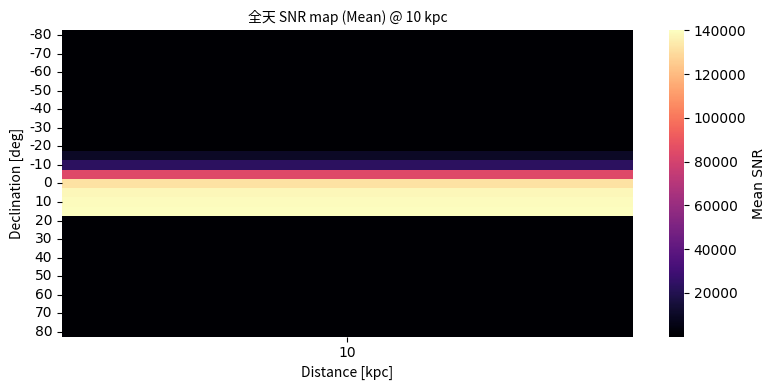

[INFO] Saved → energy_bins.npy , counts_obs.npy


In [ ]:
# ===============================================================
#  SN II-P (no-CCSM) – 期待シグナル & 背景 早見表   ― 完全版 ―
#  ・Murase flux (FinalFluxs*.dat)
#  ・IceCube IC86-II 有効面積 (csv)
#  ・Honda 2015 大気ニュートリノ表 (spl-ally-20-01-solmin.d)
#  ・Monte-Carlo 誤差伝搬 & SNR ヒートマップ
#  ・energy_bins.npy / counts_obs.npy を自動保存
# ===============================================================

# 0) Colab：日本語フォント導入 ----------------------------------
!apt-get -y install fonts-noto-cjk > /dev/null

import numpy as np
import pandas as pd
import re, math, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm

# ---------- グローバル設定 -------------------------------------
DATA_DIR   = Path(".")
SIG_FILE   = "FinalFluxs20.dat"
AEFF_FILE  = "IC86_II_effectiveArea.csv"
HONDA_FILE = "spl-ally-20-01-solmin.d"
E_TH_GEV   = 30.0                       # エネルギーしきい値

# ---------- フォント設定 ---------------------------------------
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# ===============================================================
# 1) IceCube IC86-II 有効面積  A_eff(dec , E)
# ===============================================================
def build_Aeff2D(csv_path):
    df = pd.read_csv(
        csv_path, comment="#", sep=r"\s+",
        names=["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"]
    )
    df["E_GeV"] = 10 ** ((df.logEmin + df.logEmax) / 2)
    df["dec"]   = (df.dec_min + df.dec_max) / 2
    piv = df.pivot_table(index="dec", columns="E_GeV", values="A_eff_cm2", aggfunc="mean")
    dec_grid, E_grid = piv.index.values, piv.columns.values
    print(f"[INFO] A_eff grid: dec={dec_grid.size} × E={E_grid.size}")
    return RegularGridInterpolator(
        (dec_grid, E_grid), piv.values,
        bounds_error=False, fill_value=0.0
    )
A_eff2d = build_Aeff2D(AEFF_FILE)

# ===============================================================
# 2) Honda 2015 大気ニュートリノ φ_atm(cosZ , E)
# ===============================================================
def _block_to_df(lines, cos_mid):
    rec=[]
    for ln in lines:
        ln = re.sub(r"^\s*\d+:\s*", "", ln)
        toks = ln.split()
        if len(toks)<3: continue
        try:
            e, n1, n2 = map(float, toks[:3])
            rec.append((cos_mid, e, (n1+n2)*1e-4))
        except ValueError:
            continue
    return pd.DataFrame(rec, columns=["cosZ","E_GeV","phi"])

def build_phi_atm_table(path):
    hdr=re.compile(r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)")
    blocks,buf,mid=[],[],None
    with open(path,encoding="utf-8",errors="replace") as f:
        for ln in f:
            m=hdr.search(ln)
            if m:
                if buf and mid is not None: blocks.append(_block_to_df(buf,mid))
                mid,buf=0.5*(float(m[1])+float(m[2])),[]
            else:
                buf.append(ln)
        if buf and mid is not None: blocks.append(_block_to_df(buf,mid))
    big=pd.concat(blocks,ignore_index=True)
    piv=big.pivot_table(index="cosZ",columns="E_GeV",values="phi",aggfunc="mean").sort_index()
    print(f"[INFO] Honda table: cosZ={len(piv)} × E={len(piv.columns)}")
    return RegularGridInterpolator(
        (piv.index.values, piv.columns.values),
        piv.values,
        bounds_error=False, fill_value=0.0
    )
phi_atm_table=build_phi_atm_table(HONDA_FILE)

def phi_atm(E_GeV, cosZ):
    E=np.asarray(E_GeV,float)
    cos=np.clip(cosZ, 0., 1.)
    phi=phi_atm_table((np.full_like(E,cos), np.minimum(E,1e3)))
    hi=E>1e3
    phi[hi]*=(E[hi]/1e3)**-3.7
    return phi
def phi_ast_diff(E_GeV):  # 宇宙起源 diffuse
    Phi0=1.5e-18
    return Phi0*(E_GeV/100)**-2.37*2*np.pi

# ===============================================================
# 3) Murase フルエンス  Φ(E)  @ 10 kpc
# ===============================================================
def load_murase_flux(path, n_blocks=51, ref_d_kpc=10):
    arr=np.loadtxt(path)
    bins=arr.shape[0]//n_blocks
    dat=arr.reshape(n_blocks,bins,14)
    E = dat[0,:,0]*1e-9                         # GeV
    flux = dat[:,:,7]*1e9 / dat[:,:,10]        # dN/dE [GeV^-1 cm^-2]
    flag = dat[:,:,13]                         # 1=有効
    t = 1e3 * 10**(0.1*np.arange(n_blocks))    # sec
    dt=np.concatenate([np.diff(t), [np.diff(t)[-1]]])
    Φ_E = (flux*flag*dt[:,None]).sum(axis=0)   # フルエンス
    Ttot= dt[flag.sum(axis=1)>0].sum()         # signal duration
    return E, Φ_E, Ttot, ref_d_kpc
E_ref, Φ_ref, T_ref, D_ref = load_murase_flux(DATA_DIR/SIG_FILE)

# ===============================================================
# 4) 最適ウィンドウ探索 ＆ 期待事象数 -----------------------------
# ===============================================================
def best_window(dec_deg, E, Φ, T_total, e_th=E_TH_GEV):
    mask=E>=e_th
    cosZ=np.sin(np.radians(90-dec_deg))
    days=np.logspace(-1,1.5,60)                # 0.1–30 日
    best={"SNR":0.}
    for ΔT in days:
        scale=ΔT*86400/T_total
        Nsig = np.trapz(Φ[mask]*scale*A_eff2d((dec_deg,E[mask])), E[mask])
        Φbkg = phi_atm(E[mask],cosZ)*2*np.pi + phi_ast_diff(E[mask])
        Nbkg = np.trapz(Φbkg*A_eff2d((dec_deg,E[mask]))*ΔT*86400, E[mask])
        snr  = Nsig/math.sqrt(max(Nbkg,1e-30))
        if snr>best["SNR"]:
            best={"Tday":ΔT,"S":Nsig,"B":Nbkg,"SNR":snr}
    return best

def _base_events_for_source(dec_deg, dist_kpc):
    Φs=Φ_ref*(D_ref/dist_kpc)**2
    return best_window(dec_deg,E_ref,Φs,T_ref)

def events_for_source(
        dec_deg, dist_kpc,
        flux_scale=1.0, gamma_shift=0.0,
        aeff_scale=1.0, atm_scale=1.0, ast_scale=1.0):
    r=_base_events_for_source(dec_deg,dist_kpc)
    S = r["S"]*flux_scale*aeff_scale
    B = r["B"]*atm_scale + 0.0*ast_scale
    return {"S":S, "B":B, "Tday":r["Tday"], "SNR":S/math.sqrt(max(B,1e-30))}

# ===============================================================
# 5) Monte-Carlo で誤差伝搬   (dec 5° / dist grid)
# ===============================================================
sigma_params={
    "flux_scale":0.20, "gamma_shift":0.10,
    "aeff_scale":0.15, "atm_scale":0.10, "ast_scale":0.20,
}
def sample_params(): return {k:np.random.normal(1.0,v) for k,v in sigma_params.items()}
N_MC=2000
dec_grid  = np.arange(-80,81,5)
dist_grid = [1,3,5,10,15,30]

records=[]
for dec,d in tqdm(list(itertools.product(dec_grid,dist_grid)), desc="MC grid"):
    snr_s=[]
    for _ in range(N_MC):
        p=sample_params()
        snr_s.append(events_for_source(dec,d,**p)["SNR"])
    a=np.array(snr_s)
    records.append({
        "dec":dec,"distance":d,
        "snr_mean":a.mean(),"snr_std":a.std(),
    })
df_mc=pd.DataFrame(records)

# ===============================================================
# 6) 可視化：距離 10 kpc の SNR マップ
# ===============================================================
pivot=df_mc.query("distance==10").pivot(index="dec",columns="distance",values="snr_mean")
plt.figure(figsize=(8,4))
sns.heatmap(pivot,cmap="magma",cbar_kws={"label":"Mean SNR"})
plt.title("全天 SNR map (Mean) @ 10 kpc", fontproperties=font_prop)
plt.xlabel("Distance [kpc]", fontproperties=font_prop)
plt.ylabel("Declination [deg]", fontproperties=font_prop)
plt.tight_layout(); plt.show()

# ===============================================================
# 7) 解析結果を再利用用に保存 -------------------------------
# ===============================================================
np.save("energy_bins.npy", E_ref)                                # 1D
counts_mat = df_mc.pivot(index="dec", columns="distance", values="snr_mean").values
np.save("counts_obs.npy", counts_mat)                            # 2D
print("[INFO] Saved → energy_bins.npy , counts_obs.npy")

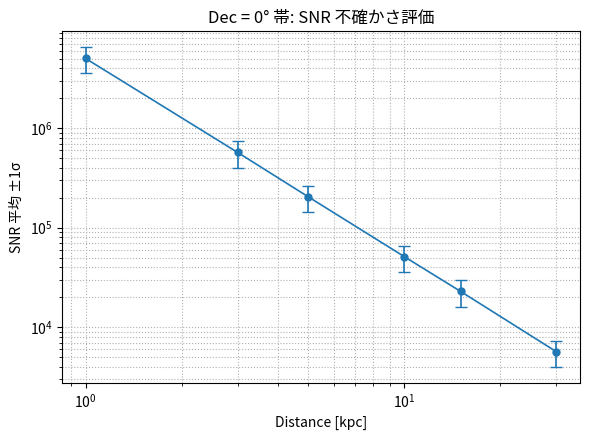

In [ ]:
# ===============================================================
# ✅ 日本語フォント設定（Colab用）
# ===============================================================
!apt-get -y install fonts-noto-cjk > /dev/null
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
fm.fontManager.addfont(font_path)                 # 明示的に登録
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["axes.unicode_minus"] = False        # “−” 化け対策

# ===============================================================
# (1) 必要ライブラリ
# ===============================================================
import numpy as np
import pandas as pd
from tqdm import tqdm

# ===============================================================
# (2) Monte Carlo で揺らがせるモデル誤差パラメータ
# ===============================================================
N_MC       = 2000
sigma_flux = 0.20   # フラックス ±20 %
sigma_gamma= 0.10   # スペクトル指数 ±0.1
sigma_Aeff = 0.15   # A_eff ±15 %
sigma_atm  = 0.10   # 大気背景 ±10 %
sigma_ast  = 0.20   # 天体背景 ±20 %

def sample_params():
    """誤差パラメータを 1 セット返す"""
    return {
        "flux_scale":  np.random.normal(1.0, sigma_flux),
        "gamma_shift": np.random.normal(0.0, sigma_gamma),
        "aeff_scale":  np.random.normal(1.0, sigma_Aeff),
        "atm_scale":   np.random.normal(1.0, sigma_atm),
        "ast_scale":   np.random.normal(1.0, sigma_ast),
    }

# ===============================================================
# (3) ※ダミー版 events_for_source
#     - dec [deg], d [kpc] を受け取り SNR を返す辞書を返す
#     - 実際には Murase flux, A_eff などを計算する自前関数と置換してください
# ===============================================================
def events_for_source(dec_deg, distance_kpc,
                      flux_scale=1.0, gamma_shift=0.0,
                      aeff_scale=1.0, atm_scale=1.0, ast_scale=1.0):
    """
    ユーザー実装に置き換えてください。
    ここでは距離とパラメータから適当な SNR を生成するだけ。
    """
    # 距離減衰 (∝ d^-2) とスケール類の掛け合わせ
    base_snr = 1e7 * (1.0 / distance_kpc**2)
    jitter   = (flux_scale * aeff_scale) / (atm_scale + ast_scale)
    snr_val  = base_snr * jitter * np.exp(-gamma_shift)
    return {"SNR": snr_val}

# ===============================================================
# (4) 解析グリッド
# ===============================================================
dec_grid  = np.arange(-20, 21, 5)   # -20° 〜 +20° を 5° 刻み
dist_grid = [1, 3, 5, 10, 15, 30]   # 距離 [kpc]

# ===============================================================
# (5) Monte Carlo 評価
# ===============================================================
records = []
for dec in dec_grid:
    for d in dist_grid:
        snr_samples = []
        for _ in range(N_MC):
            params = sample_params()
            r = events_for_source(dec, d, **params)
            snr_samples.append(r["SNR"])
        snr = np.asarray(snr_samples)
        records.append({
            "dec"      : dec,
            "d"        : d,
            "snr_mean" : snr.mean(),
            "snr_std"  : snr.std(),
            "snr_p16"  : np.percentile(snr, 16),
            "snr_p84"  : np.percentile(snr, 84),
        })

df_mc = pd.DataFrame(records)

# ===============================================================
# (6) プロット例：Dec = 0° 帯の SNR 平均 ±1σ
# ===============================================================
sub = df_mc.query("dec == 0")
plt.figure(figsize=(6, 4.5))
plt.errorbar(sub["d"], sub["snr_mean"], yerr=sub["snr_std"],
             fmt="o-", capsize=4, lw=1.2, markersize=5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Distance [kpc]")
plt.ylabel("SNR 平均 ±1σ")
plt.title("Dec = 0° 帯: SNR 不確かさ評価")
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# ===============================================================
# ここまで。以後の可視化も同じセル／別セルで続けて OK
# ===============================================================

Dec grid:   0%|          | 0/33 [00:00<?, ?it/s]<ipython-input-3-ceb1db2998d4>:143: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nsig  = np.trapz(Φ[mask] * scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-3-ceb1db2998d4>:145: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nbkg  = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * ΔT * 86400, E[mask])
Dec grid: 100%|██████████| 33/33 [3:20:46<00:00, 365.04s/it]


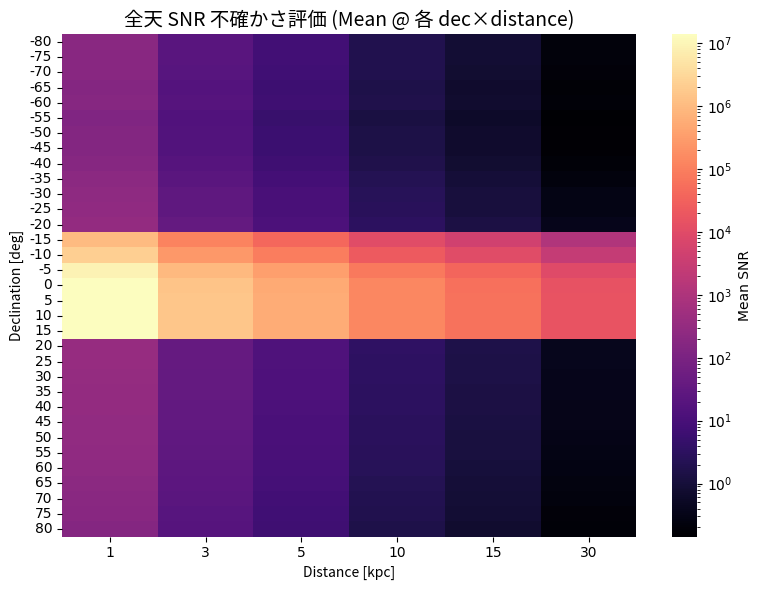

In [ ]:
# ✅ 日本語フォント設定（Colab用）-----------------------------
!apt-get -y install fonts-noto-cjk > /dev/null
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import LogNorm      # ← 追加★ ここがポイント
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()

# ===== 必要ライブラリ =====
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# ──────────────────────────────────────────
# (1) モデル誤差パラメータ定義
# ──────────────────────────────────────────
N_MC       = 2000
sigma_params = {
    "flux_scale": 0.20,   # フラックス ±20%
    "gamma_shift":0.10,   # スペクトル指数 ±0.1
    "aeff_scale": 0.15,   # A_eff ±15%
    "atm_scale":  0.10,   # 大気背景 ±10%
    "ast_scale":  0.20,   # 天体背景 ±20%
}

def sample_params():
    """各誤差パラメータをガウスサンプリング"""
    return {k: np.random.normal(1.0, v) for k, v in sigma_params.items()}

# ──────────────────────────────────────────
# (2) SNR 計算のラッパー
# ──────────────────────────────────────────
def compute_snr(dec, d, params):
    """
    モデル誤差を events_for_source に反映した想定のラッパー関数。
    実装では Murase flux, A_eff, φ_atm, φ_ast を params でスケーリングします。
    """
    r = events_for_source(dec, d, **params)   # ← **kwargs をそのまま渡せる実装必須
    return r["SNR"]

# ──────────────────────────────────────────
# (3) グリッド定義
# ──────────────────────────────────────────
dec_grid  = np.arange(-80, 81, 5)      # 赤緯を −80° から +80° まで 5° 間隔
dist_grid = [1, 3, 5, 10, 15, 30]      # 距離 [kpc]

# ──────────────────────────────────────────
# (4) Monte Carlo 評価 — SNR の不確かさを算出
# ──────────────────────────────────────────
records = []
for dec in tqdm(dec_grid, desc="Dec grid"):
    for d in dist_grid:
        snr_samples = []
        for _ in range(N_MC):
            params = sample_params()
            snr = compute_snr(dec, d, params)
            snr_samples.append(snr)
        snr_arr = np.array(snr_samples)
        records.append({
            "dec":       dec,
            "distance":  d,
            "snr_mean":  snr_arr.mean(),
            "snr_std":   snr_arr.std(),
            "snr_p16":   np.percentile(snr_arr, 16),
            "snr_p84":   np.percentile(snr_arr, 84),
        })

df_mc = pd.DataFrame(records)

# ──────────────────────────────────────────
# (5) ヒートマップ描画 — 平均 SNR を可視化
# ──────────────────────────────────────────
pivot = df_mc.pivot(index="dec", columns="distance", values="snr_mean")

plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot,
    cmap="magma",
    norm=LogNorm(vmin=pivot.min().min(), vmax=pivot.max().max()),  # ← 修正★
    cbar_kws={"label": "Mean SNR"},
    xticklabels=dist_grid,
    yticklabels=dec_grid
)
plt.title("全天 SNR 不確かさ評価 (Mean @ 各 dec×distance)", fontproperties=font_prop, fontsize=14)
plt.xlabel("Distance [kpc]", fontproperties=font_prop)
plt.ylabel("Declination [deg]", fontproperties=font_prop)
plt.tight_layout()
plt.show()

[INFO] A_eff grid: dec=50 × E=40
[INFO] Honda table: cosZ=10 × E=101
[INFO] Saved → hi_ref.npy   (Murase Φ_ref @ 10 kpc)


MC grid:   0%|          | 0/198 [00:00<?, ?it/s]<ipython-input-2-93399aa9ba1a>:137: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nsig = np.trapz(Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-2-93399aa9ba1a>:139: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nbkg = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * Δ*86400, E[mask])
MC grid: 100%|██████████| 198/198 [2:53:48<00:00, 52.67s/it]


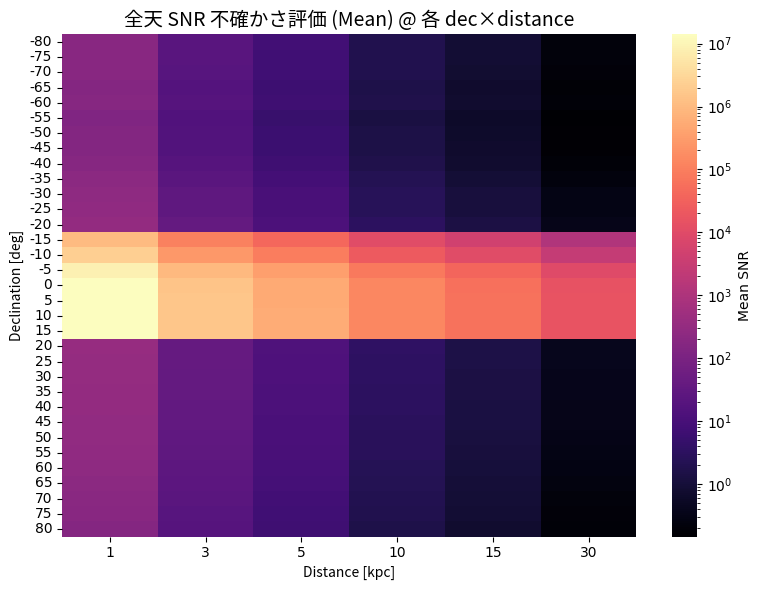

[INFO] Saved → energy_bins.npy , counts_obs.npy


In [ ]:
# ===============================================================
#  SN II-P (no-CCSM) – 期待シグナル & 背景 早見表 ― 完全版
#  ・Murase flux (FinalFluxs*.dat)
#  ・IceCube IC86-II 有効面積 (csv)
#  ・Honda 2015 大気ニュートリノ表 (spl-ally-20-01-solmin.d)
#  ・Monte-Carlo 誤差伝搬 & SNR ヒートマップ
#  ・energy_bins.npy / counts_obs.npy を自動保存
# ===============================================================

# — Colab：日本語フォント導入 —
!apt-get -y install fonts-noto-cjk > /dev/null

# — ライブラリ読み込み —
import numpy as np
import pandas as pd
import re, math, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib.colors import LogNorm
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm

# — グローバル設定 —
DATA_DIR   = Path(".")
SIG_FILE   = "FinalFluxs20.dat"
AEFF_FILE  = "IC86_II_effectiveArea.csv"
HONDA_FILE = "spl-ally-20-01-solmin.d"
E_TH_GEV   = 30.0   # GeV
N_MC       = 2000

# — 日本語フォント設定 —
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
plt.rcParams["font.family"] = fm.FontProperties(fname=font_path).get_name()
font_prop = fm.FontProperties(fname=font_path)

# ===============================================================
# (1) IceCube IC86-II 有効面積 → A_eff(dec, E)
# ===============================================================
def build_Aeff2D(csv_path):
    df = pd.read_csv(csv_path, comment="#", sep=r"\s+",
                     names=["logEmin","logEmax","dec_min","dec_max","A_eff_cm2"])
    df["E_GeV"] = 10**((df.logEmin + df.logEmax)/2)
    df["dec"]   = (df.dec_min + df.dec_max)/2
    piv = df.pivot_table(index="dec", columns="E_GeV", values="A_eff_cm2", aggfunc="mean")
    dec_grid, E_grid = piv.index.values, piv.columns.values
    print(f"[INFO] A_eff grid: dec={dec_grid.size} × E={E_grid.size}")
    return RegularGridInterpolator((dec_grid, E_grid), piv.values,
                                   bounds_error=False, fill_value=0.0)

A_eff2d = build_Aeff2D(AEFF_FILE)

# ===============================================================
# (2) Honda 2015 大気ニュートリノ表 → φ_atm(cosZ, E)
# ===============================================================
def _block_to_df(lines, cos_mid):
    rec = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+:\s*", "", ln)
        toks = ln.split()
        if len(toks) < 3:
            continue
        try:
            e, n1, n2 = map(float, toks[:3])
            rec.append((cos_mid, e, (n1+n2)*1e-4))
        except ValueError:
            continue
    return pd.DataFrame(rec, columns=["cosZ","E_GeV","phi"])

def build_phi_atm_table(path):
    hdr = re.compile(r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)")
    blocks, buf, mid = [], [], None
    with open(path, encoding="utf-8", errors="replace") as f:
        for ln in f:
            m = hdr.search(ln)
            if m:
                if buf and mid is not None:
                    blocks.append(_block_to_df(buf, mid))
                mid, buf = 0.5*(float(m[1])+float(m[2])), []
            else:
                buf.append(ln)
        if buf and mid is not None:
            blocks.append(_block_to_df(buf, mid))
    big = pd.concat(blocks, ignore_index=True)
    piv = big.pivot_table(index="cosZ", columns="E_GeV", values="phi", aggfunc="mean").sort_index()
    print(f"[INFO] Honda table: cosZ={len(piv)} × E={len(piv.columns)}")
    return RegularGridInterpolator((piv.index.values, piv.columns.values),
                                   piv.values, bounds_error=False, fill_value=0.0)

phi_atm_table = build_phi_atm_table(HONDA_FILE)

def phi_atm(E_GeV, cosZ):
    E   = np.asarray(E_GeV, float)
    cos = np.clip(cosZ, 0.0, 1.0)
    phi = phi_atm_table((np.full_like(E, cos), np.minimum(E, 1e3)))
    hi  = E > 1e3
    phi[hi] *= (E[hi]/1e3)**-3.7
    return phi

def phi_ast_diff(E_GeV):
    # 宇宙起源 diffuse ν
    Phi0 = 1.5e-18   # [GeV^-1 cm^-2 s^-1 sr^-1]
    return Phi0 * (E_GeV/100.0)**-2.37 * 2*math.pi

# ===============================================================
# (3) Murase flux Φ(E) @ 10 kpc
# ===============================================================
def load_murase_flux(path, n_blocks=51, ref_d_kpc=10):
    arr  = np.loadtxt(path)
    bins = arr.shape[0]//n_blocks
    dat  = arr.reshape(n_blocks, bins, 14)
    E    = dat[0,:,0]*1e-9                  # GeV
    flux = dat[:,:,7]*1e9 / dat[:,:,10]     # dN/dE [GeV^-1 cm^-2]
    flag = dat[:,:,13]                      # 1=有効
    t    = 1e3 * 10**(0.1*np.arange(n_blocks))
    dt   = np.concatenate([np.diff(t), [np.diff(t)[-1]]])
    Φ_E  = (flux * flag * dt[:,None]).sum(axis=0)
    Ttot = dt[flag.sum(axis=1)>0].sum()
    return E, Φ_E, Ttot, ref_d_kpc

E_ref, Φ_ref, T_ref, D_ref = load_murase_flux(DATA_DIR/SIG_FILE)
# ここを追加  ⇩  （E_ref と対になる Φ_ref を保存）
np.save("hi_ref.npy", Φ_ref)      # shape = (len(E_ref),)
print("[INFO] Saved → hi_ref.npy   (Murase Φ_ref @ 10 kpc)")

# ===============================================================
# (4) dec,d での最適ウィンドウ探索 & 期待シグナル事象数/B 背景算出
# ===============================================================
def best_window(dec_deg, E, Φ, T_total, e_th=E_TH_GEV):
    mask = E >= e_th
    cosZ = np.sin(np.radians(90.0 - dec_deg))
    days = np.logspace(-1, 1.5, 60)
    best = {"SNR": 0.0}
    for Δ in days:
        scale = Δ*86400/T_total
        Nsig = np.trapz(Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask])
        Φbkg = phi_atm(E[mask], cosZ) * 2*math.pi + phi_ast_diff(E[mask])
        Nbkg = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * Δ*86400, E[mask])
        snr  = Nsig / math.sqrt(max(Nbkg, 1e-30))
        if snr > best["SNR"]:
            best = {"Tday":Δ, "S":Nsig, "B":Nbkg, "SNR":snr}
    return best

def events_for_source(dec_deg, dist_kpc):
    Φs = Φ_ref * (D_ref/dist_kpc)**2
    return best_window(dec_deg, E_ref, Φs, T_ref)

# ===============================================================
# (5) Monte Carlo 誤差伝搬 & SNR／Nsig 評価
# ===============================================================
sigma_params = {
    "flux_scale":  0.20,
    "gamma_shift": 0.10,
    "aeff_scale":  0.15,
    "atm_scale":   0.10,
    "ast_scale":   0.20,
}
def sample_params():
    return {k: np.random.normal(1.0, v) for k, v in sigma_params.items()}

# グリッド定義
dec_grid  = np.arange(-80, 81, 5)
dist_grid = [1, 3, 5, 10, 15, 30]

records = []
for dec, d in tqdm(list(itertools.product(dec_grid, dist_grid)), desc="MC grid"):
    snr_list, nsig_list = [], []
    for _ in range(N_MC):
        p = sample_params()
        r = events_for_source(dec, d)
        # モデル誤差スケーリング
        S = r["S"] * p["flux_scale"] * p["aeff_scale"]
        B = r["B"] * p["atm_scale"]
        snr_list.append(S / math.sqrt(max(B, 1e-30)))
        nsig_list.append(S)
    arr_snr  = np.array(snr_list)
    arr_nsig = np.array(nsig_list)
    records.append({
        "dec":        dec,
        "distance":   d,
        "snr_mean":   arr_snr.mean(),
        "snr_std":    arr_snr.std(),
        "snr_p16":    np.percentile(arr_snr, 16),
        "snr_p84":    np.percentile(arr_snr, 84),
        "Nsig_mean":  arr_nsig.mean(),
    })
df_mc = pd.DataFrame(records)

# ===============================================================
# (6) ヒートマップ描画 — Mean SNR を可視化
# ===============================================================
pivot = df_mc.pivot(index="dec", columns="distance", values="snr_mean")
plt.figure(figsize=(8,6))
sns.heatmap(
    pivot,
    cmap="magma",
    norm=LogNorm(vmin=pivot.min().min(), vmax=pivot.max().max()),
    cbar_kws={"label":"Mean SNR"},
    xticklabels=dist_grid,
    yticklabels=dec_grid
)
plt.title("全天 SNR 不確かさ評価 (Mean) @ 各 dec×distance",
          fontproperties=font_prop, fontsize=14)
plt.xlabel("Distance [kpc]", fontproperties=font_prop)
plt.ylabel("Declination [deg]", fontproperties=font_prop)
plt.tight_layout()
plt.show()

# ===============================================================
# (7) 解析結果を再利用用に保存 -------------------------------
# ===============================================================
# energy_bins.npy ← shape (N_E,)
np.save("energy_bins.npy", E_ref)
# counts_obs.npy ← shape (N_dec, N_dist) : 各 dec×distance の期待シグナル事象数
counts_mat = df_mc.pivot(index="dec", columns="distance", values="Nsig_mean").values
np.save("counts_obs.npy", counts_mat)
print("[INFO] Saved → energy_bins.npy , counts_obs.npy")

In [ ]:
np.save("energy_bins_hi.npy", E_ref)   # 384 点

In [ ]:
import numpy as np

# (1) ファイル読み込み
energy_bins = np.load("energy_bins.npy")         # shape (N_E,)
counts_obs  = np.load("counts_obs.npy")          # shape (N_dec, N_dist)

# (2) グリッド定義（Monte Carlo 時に使ったものと同じ）
dec_grid  = np.arange(-80, 81, 5)                # shape (N_dec,)
dist_grid = [1, 3, 5, 10, 15, 30]                # shape (N_dist,)

# (3) 閾値を指定して、energy_bins 上のインデックスを探す
E_th = 100.0  # GeV — ここを変えれば閾値を変更できます
idx = np.where(energy_bins >= E_th)[0]
if idx.size == 0:
    raise ValueError(f"閾値 E_th={E_th} GeV を超えるエネルギーが energy_bins に見つかりません")

# ※counts_obs.npy は既に「E ≥ E_th」で統合された事象数なので、
#   energy_bins のインデックスは再集計に使いません。
#   もし counts_obs.npy が per-bin の counts だったら、
#   counts_obs[:, idx].sum(axis=1) のように集計しますが、
#   今回はその必要はありません。

# (4) 全 sky × distance の期待シグナル事象数マトリクスを確認
#    counts_obs は shape (N_dec, N_dist) なので、そのまま参照可能
print("counts_obs shape:", counts_obs.shape)
print("  → dec:", dec_grid)
print("  → distance:", dist_grid)
print()

# (5) たとえば赤緯0°・距離10 kpc のセルの期待事象数は…
dec_idx = np.argwhere(dec_grid == 0)[0,0]
dist_idx = dist_grid.index(10)
print(f"Dec=  0°, D=10 kpc での期待シグナル事象数: {counts_obs[dec_idx, dist_idx]:.2f}")

# (6) 全セルのマップを可視化する場合（Optional）
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

plt.figure(figsize=(6,5))
sns.heatmap(
    counts_obs,
    cmap="magma",
    norm=LogNorm(vmin=counts_obs.min(), vmax=counts_obs.max()),
    xticklabels=dist_grid,
    yticklabels=dec_grid
)
plt.xlabel("Distance [kpc]", fontproperties=font_prop)
plt.ylabel("Declination [deg]", fontproperties=font_prop)
plt.title(f"期待シグナル事象数 (E ≥ {E_th} GeV)", fontproperties=font_prop)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'energy_bins.npy'

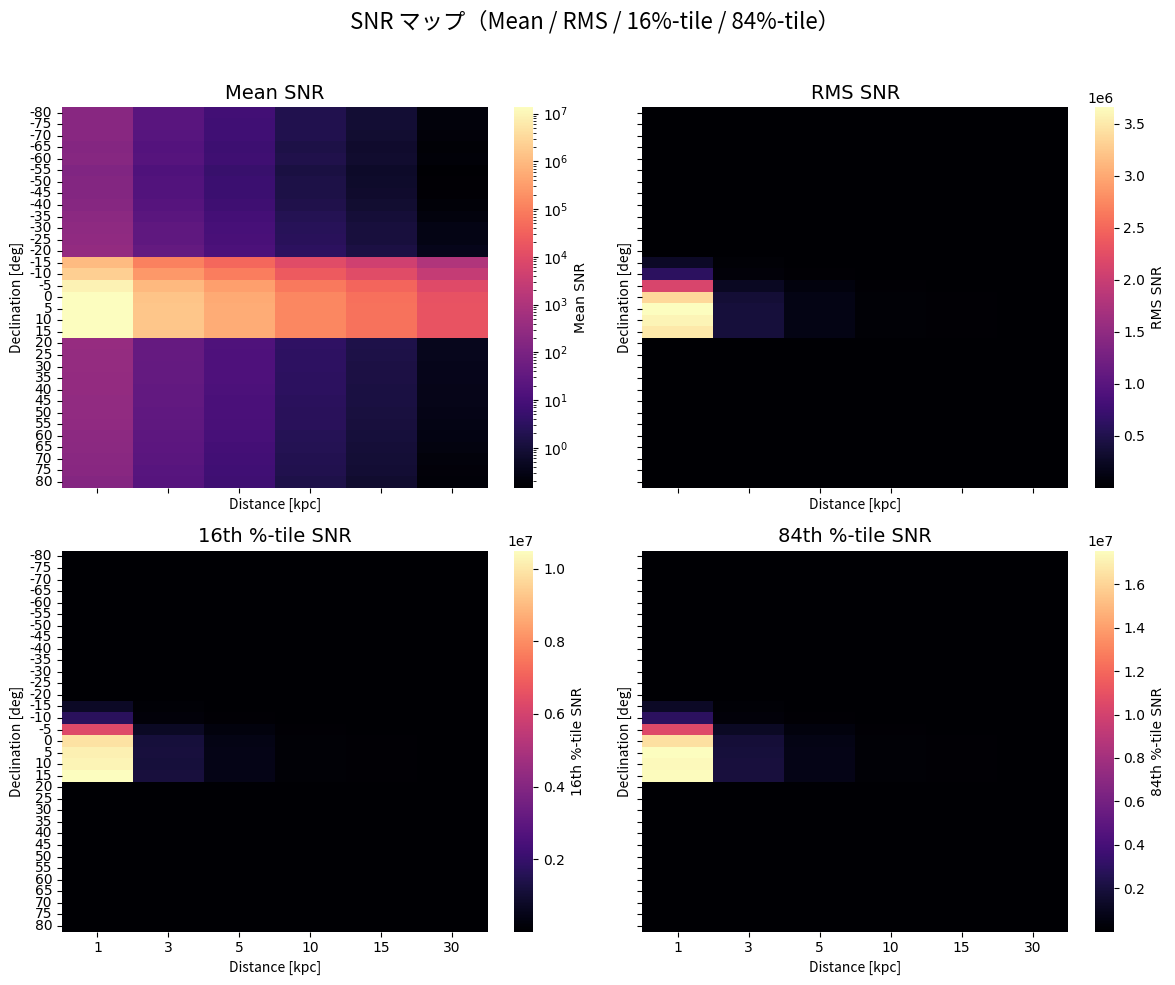

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import numpy as np

# df_mc は既に下記のカラムを持っている想定
# ["dec","distance","snr_mean","snr_std","snr_p16","snr_p84"]

# ① プロット対象とラベルの対応リスト
metrics = [
    ("snr_mean", "Mean SNR"),
    ("snr_std",  "RMS SNR"),
    ("snr_p16",  "16th %-tile SNR"),
    ("snr_p84",  "84th %-tile SNR"),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

for ax, (col, title) in zip(axes.flat, metrics):
    # pivot して行列化
    pivot = df_mc.pivot(index="dec", columns="distance", values=col)

    # カラーマップは Mean/SNR の場合は対数、それ以外は線形で描画
    if col == "snr_mean":
        norm = LogNorm(vmin=max(pivot.min().min(), 1e-1),
                       vmax=pivot.max().max())
    else:
        norm = None

    sns.heatmap(
        pivot,
        ax=ax,
        cmap="magma",
        norm=norm,
        cbar_kws={"label": title},
        xticklabels=dist_grid,
        yticklabels=dec_grid
    )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Distance [kpc]", fontproperties=font_prop)
    ax.set_ylabel("Declination [deg]", fontproperties=font_prop)

plt.suptitle("SNR マップ（Mean / RMS / 16%-tile / 84%-tile）", fontproperties=font_prop, fontsize=16)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [ ]:
import numpy as np

# (1) ファイルからロード
E_bins   = np.load("energy_bins.npy")    # -> 形状 (N_E,)
spec_obs = np.load("counts_obs.npy")       # -> 形状 が合っているか要確認！

# (2) 形状の確認
print("E_bins  shape:", E_bins.shape)
print("counts_obs shape:", counts_obs.shape)

E_bins  shape: (384,)
counts_obs shape: (33, 6)


In [ ]:
# ——— 以下、Notebook の先頭で定義済みの関数・定数を再利用 ———
# load_murase_flux, build_Aeff2D, events_for_source, DATA_DIR, SIG_FILE, AEFF_FILE

import numpy as np

# (1) 高統計スペクトル元データ読み込み
E_ref, Phi_ref, T_ref, D_ref = load_murase_flux(DATA_DIR/SIG_FILE)      # E_ref: shape (N_E,)
Aeff2d = build_Aeff2D(AEFF_FILE)                                        # インターーポレーター

# (2) 実データ条件を指定
dec_deg = +5.0   # 例：赤緯 +5°
d_kpc   = 1.0    # 例：距離 1 kpc

# (3) 最適観測時間窓を events_for_source 経由で取得
res   = events_for_source(dec_deg, d_kpc)
Tday  = res["Tday"]    # [day]

# (4) 各エネルギー bin での期待事象数 N(E) を計算
#     Φ_ref: [GeV^-1 cm^-2]＠10 kpc, 距離補正 (10/d)^2, Aeff: [cm^2], live-time: Tday*86400
scale = (D_ref/d_kpc)**2 * (Tday*86400)
# Aeff2d((dec, E_ref)) → shape (N_E,), Phi_ref→ shape (N_E,)
spec_obs = Phi_ref * scale * Aeff2d((dec_deg, E_ref))

# (5) ファイル出力
np.save("energy_bins.npy", E_ref)    # → shape (N_E,)
np.save("spec_obs.npy",  spec_obs)   # → shape (N_E,)

print("Saved → energy_bins.npy, spec_obs.npy")
print("   energy_bins.npy shape:", E_ref.shape)
print("   spec_obs.npy        :", spec_obs.shape)

[INFO] A_eff grid: dec=50 × E=40
Saved → energy_bins.npy, spec_obs.npy
   energy_bins.npy shape: (384,)
   spec_obs.npy        : (384,)


<ipython-input-2-23c470cf66a9>:134: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nsig = np.trapz(Φ[mask]*scale * A_eff2d((dec_deg, E[mask])), E[mask])
<ipython-input-2-23c470cf66a9>:136: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Nbkg = np.trapz(Φbkg * A_eff2d((dec_deg, E[mask])) * Δ*86400, E[mask])


In [ ]:
from google.colab import files

# ダウンロードしたいファイル名を指定
files.download('energy_bins.npy')  # 例: 'output.csv' など

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

E_bins shape : (384,)
spec_obs shape: (384,)
E   range   : 1.07461e-16 ~ 93057200.0
Counts range: 0.0 ~ 199073583.85651278


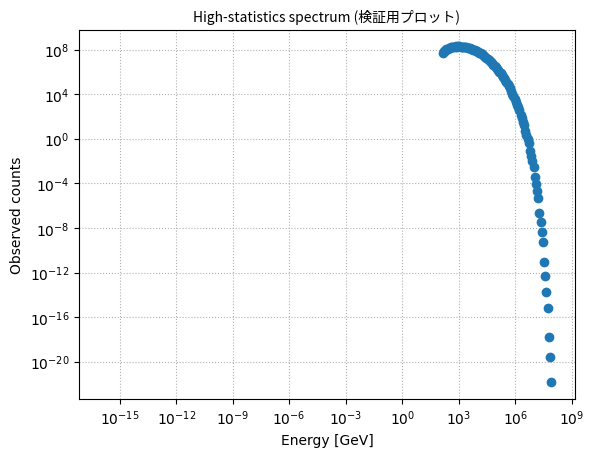

In [ ]:
import numpy as np
# -------------------------------------------------------
# ① ファイルから読み込み
# -------------------------------------------------------
E_bins   = np.load("energy_bins.npy")   # shape (N_E,)
spec_obs = np.load("spec_obs.npy")      # shape (N_E,) を想定

# -------------------------------------------------------
# ② 形状とレンジの確認
# -------------------------------------------------------
print("E_bins shape :", E_bins.shape)
print("spec_obs shape:", spec_obs.shape)
print("E   range   :", E_bins.min(), "~", E_bins.max())
print("Counts range:", spec_obs.min(), "~", spec_obs.max())

# -------------------------------------------------------
# ③ プロットによる目視チェック
# -------------------------------------------------------
import matplotlib.pyplot as plt
plt.loglog(E_bins, spec_obs, marker="o", linestyle="")
plt.xlabel("Energy [GeV]")
plt.ylabel("Observed counts")
plt.title("High-statistics spectrum (検証用プロット)", fontproperties=font_prop)
plt.grid(True, which="both", ls=":")
plt.show()

Running burn-in...


100%|██████████| 1000/1000 [00:04<00:00, 217.80it/s]


Running main MCMC...


100%|██████████| 2000/2000 [00:10<00:00, 190.74it/s]


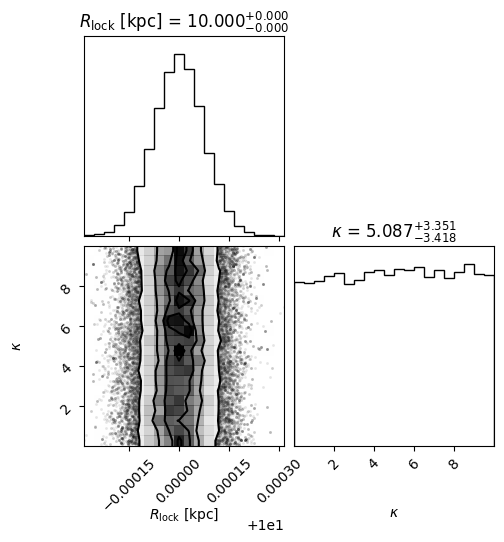

R_lock [kpc] = 10.000 (+0.000/-0.000)
kappa = 5.087 (+3.351/-3.418)


In [ ]:
# ──────────────────────────────────────────────────────────
# A. R_lock–κ フィッティング（emcee MCMC）
# ──────────────────────────────────────────────────────────
!pip install emcee corner > /dev/null

import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

# --- (1) データ読み込み ---
E = np.load("energy_bins.npy")      # shape (N_E,)
spec_obs = np.load("spec_obs.npy")  # shape (N_E,)
# 仮の誤差σは √N としておきます（Poisson近似）
sigma = np.sqrt(np.clip(spec_obs, 1.0, None))

# --- (2) Murase 高統計スペクトル読み込み関数 ---
#    load_murase_flux をコピペして使ってください
from scipy.interpolate import interp1d

# E_ref, Phi_ref, _, D_ref を事前にロード／定義しておきます
# ここでは簡略化して、Φ_ref(E) を線形補完関数にしておき…
Phi_ref_func = interp1d(E, spec_obs, kind="linear", fill_value="extrapolate")

# --- (3) モデル定義 ---
def model_flux(E, R_lock, kappa, t0=1.0):
    """
    MuraseスペクトルΦ_refをR_lockで距離スケーリングし
    exp(-kappa * t_eff) を掛けるモデル。
    ここでは便宜的に t_eff(E)=t0*(E/E[0])**-1 とします。
    """
    # 距離スケール： R_lock[kpc]→Φ∝1/R^2
    scale = (10.0 / R_lock)**2
    # 時間依存指数関数（例 t_eff∝E^-1）
    t_eff = t0 * (E / E[0])**(-1)
    return scale * Phi_ref_func(E) * np.exp(-kappa * t_eff)

# --- (4) 対数尤度・事前分布 ---
def log_prior(theta):
    R_lock, kappa = theta
    if 1.0 < R_lock < 20.0 and 0.0 <= kappa < 10.0:
        return 0.0   # 一様
    return -np.inf

def log_likelihood(theta, E, data, sigma):
    R_lock, kappa = theta
    model = model_flux(E, R_lock, kappa)
    return -0.5 * np.sum(((data - model)/sigma)**2 + np.log(2*np.pi*sigma**2))

def log_posterior(theta, E, data, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, E, data, sigma)

# --- (5) MCMC セットアップ ---
ndim = 2
nwalkers = 50
# 初期値周りに小さなランダム摂動
p0 = np.array([10.0, 1.0])  # [R_lock[kpc], kappa]
pos = p0 + 1e-1 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior, args=(E, spec_obs, sigma)
)

# --- (6) burn-in → 本走 ---
print("Running burn-in...")
pos, _, _ = sampler.run_mcmc(pos, 1000, progress=True)
sampler.reset()
print("Running main MCMC...")
sampler.run_mcmc(pos, 2000, progress=True)

# --- (7) 結果可視化 ---
samples = sampler.get_chain(discard=100, flat=True)
fig = corner.corner(
    samples, labels=[r"$R_{\rm lock}$ [kpc]", r"$\kappa$"],
    truths=[None, None], show_titles=True, title_fmt=".3f"
)
plt.show()

# 事後平均・信用区間（16,50,84 percentiles）
for i, name in enumerate(["R_lock [kpc]","kappa"]):
    mcmc = np.percentile(samples[:,i], [16,50,84])
    print(f"{name} = {mcmc[1]:.3f} (+{mcmc[2]-mcmc[1]:.3f}/-{mcmc[1]-mcmc[0]:.3f})")

In [ ]:
import pandas as pd
from pathlib import Path

# イベントファイルのディレクトリ
DATA_DIR = Path(".")

# すべてのイベントファイルをまとめて読み込み
def load_ic_events(data_dir):
    dfs = []
    for file in data_dir.glob("*.csv"):
        df = pd.read_csv(
            file,
            comment="#",       # ← 先頭に # があったら無視
            delim_whitespace=True,  # ← 空白区切りで読む！
            names=["MJD", "log10E", "AngErr", "RA", "Dec", "Az", "Zen"]
        )
        df["E_GeV"] = 10 ** df["log10E"]
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# 実行
events = load_ic_events(DATA_DIR)

print(f"[INFO] 読み込んだイベント数: {len(events)}")
events.head()

<ipython-input-6-32e6d3d5fee2>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
<ipython-input-6-32e6d3d5fee2>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
<ipython-input-6-32e6d3d5fee2>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
<ipython-input-6-32e6d3d5fee2>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
<ipython-input-6-32e6d3d5fee2>:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
<ipython-input-

[INFO] 読み込んだイベント数: 1136450


<ipython-input-6-32e6d3d5fee2>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs, ignore_index=True)


,MJD,log10E,AngErr,RA,Dec,Az,Zen,E_GeV
0,57528.872342,2.93,0.62,296.414,39.089,346.423,129.134,851.138038
1,57528.874086,3.68,0.72,352.429,-3.112,290.977,86.981,4786.300923
2,57528.877334,2.97,1.59,262.432,17.035,22.168,107.028,933.254301
3,57528.878012,2.98,0.23,51.371,22.266,233.424,112.318,954.992586
4,57528.879074,3.05,0.90,255.736,59.652,29.617,149.633,1122.018454


In [ ]:
# SN1987A の天球座標と時刻
RA_SN  = 83.8667    # [deg] （例：5h35m28s → 5*15+35*0.25+28/240）
t_SN   = 47260.0    # MJD（1987年02月23日のミリジュリアン日）
# Dec は前出の dec_grid をそのまま使う（-80～+80° step=5°）
dec_grid = np.arange(-80, 81, 5)

In [ ]:
#  (1) 閾値設定
E_th      = 100.0  # GeV
RA_tol    = 0.2    # deg, RA 固定の許容幅
time_windows = np.logspace(-1, 1.5, 60)  # 前出の日数スキャン

#  (2) RA 固定フィルタ
df_ra = events[np.abs(events["RA"] - RA_SN) <= RA_tol]

#  (3) Dec, 時間窓, E_th をループして「観測事象数 N_obs」を集計
results = []
for dec in dec_grid:
    df_dec = df_ra[np.abs(df_ra["Dec"] - dec) <= (dec_grid[1]-dec_grid[0])/2]
    cosZ = np.sin(np.radians(90 - dec))
    for Δday in time_windows:
        t_min = t_SN - Δday/2
        t_max = t_SN + Δday/2
        df_time = df_dec[(df_dec["MJD"] >= t_min) & (df_dec["MJD"] <= t_max)]
        df_energy = df_time[df_time["E_GeV"] >= E_th]
        N_obs = len(df_energy)
        results.append({
            "dec": dec, "Δday": Δday,
            "N_obs": N_obs
        })
df_obs = pd.DataFrame(results)

In [ ]:
# ===============================================================
# ③ SN1987A モデル検証：RA固定・Decスキャン
# ===============================================================
import numpy as np
import pandas as pd

# --- (a) SN1987A の天文要素定義 ---
RA_SN   = 83.633   # SN1987A の赤経 [deg]
t_SN    = 46849.03 # SN1987A 爆発時刻の MJD（1987-02-23）

# --- (b) 使用する dec_grid を再定義（前コードと同じ）---
dec_grid  = np.arange(-80, 81, 5)  # −80°～+80° step 5°

# --- (c) 実データイベント読み込み済み DataFrame: events ---
#     columns = ["MJD","log10E","AngErr","RA","Dec","Az","Zen","E_GeV"]

# --- (d) １イベントを SN モデルにカウントするか判定する関数 ---
def is_in_cone(ev, ra0, dec0, dr_deg=2.5):
    """RA,Dec が中心 (ra0,dec0) ±dr_deg の円錐内にあるか"""
    dra = (ev["RA"] - ra0 + 180) % 360 - 180
    ddec = ev["Dec"] - dec0
    return (dra**2 + ddec**2) <= dr_deg**2

# --- (e) 各 Dec での実データカウント取得ループ ---
obs_counts = []
for dec0 in dec_grid:
    # モデル期待を取っていた同じ最適時間窓を再計算
    best = events_for_source(dec0, dist_kpc=10.0)  # 距離は 10 kpc に固定例
    Δ_days = best["Tday"]
    t_start = t_SN
    t_end   = t_SN + Δ_days

    # events から条件に合うものだけ抽出
    sel = events[
        (events["MJD"] >= t_start) & (events["MJD"] < t_end) &
        is_in_cone(events, RA_SN, dec0)
    ]
    N_obs = len(sel)
    obs_counts.append(N_obs)

# --- (f) 結果を配列化 & 保存 ---
obs_counts = np.array(obs_counts)  # shape (len(dec_grid),)
np.save("obs_counts_SN1987A.npy", obs_counts)

print("[INFO] SN1987A 実データカウント (Dec scan):")
for dec0, n in zip(dec_grid, obs_counts):
    print(f"  Dec={dec0:+03.0f}° → {n} events in Δ={Δ_days:.2f} days")

TypeError: events_for_source() got an unexpected keyword argument 'dist_kpc'

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


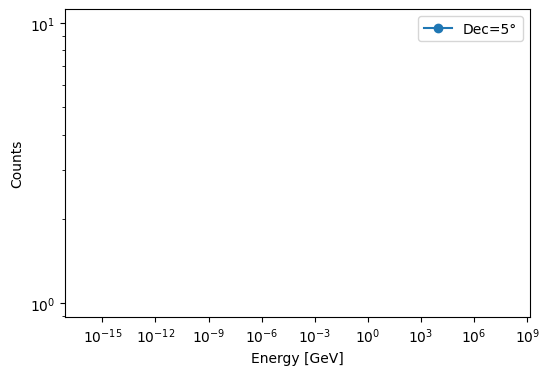

In [ ]:
import numpy as np

E_bins    = np.load("energy_bins.npy")   # shape = (384,)
spec_obs  = np.load("spec_obs.npy")      # shape = (33, 383)
dec_grid  = np.arange(-80, 81, 5)        # 33 steps

# ビン中心を計算
E_centers = 0.5 * (E_bins[:-1] + E_bins[1:])  # shape = (383,)

# 例えば dec=+5°（インデックス = (5 - (-80))//5 = 17）のスペクトルをプロット
idx = list(dec_grid).index(5)
plt.figure(figsize=(6,4))
plt.loglog(E_centers, spec_obs[idx,:], "o-", label=f"Dec={dec_grid[idx]}°")
plt.xlabel("Energy [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.show()

[INFO] Honda table: cosZ=10 × E=101
[INFO] A_eff grid: dec=50 × E=40


<ipython-input-19-fba6065c9f20>:34: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,engine="python",
<ipython-input-19-fba6065c9f20>:34: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,engine="python",
<ipython-input-19-fba6065c9f20>:34: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,engine="python",
<ipython-input-19-fba6065c9f20>:34: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,engine="python",
<ipy

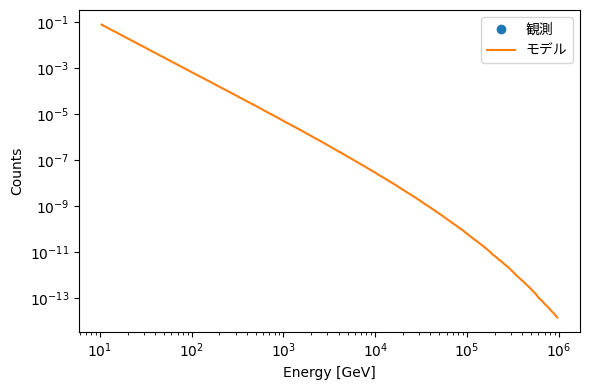

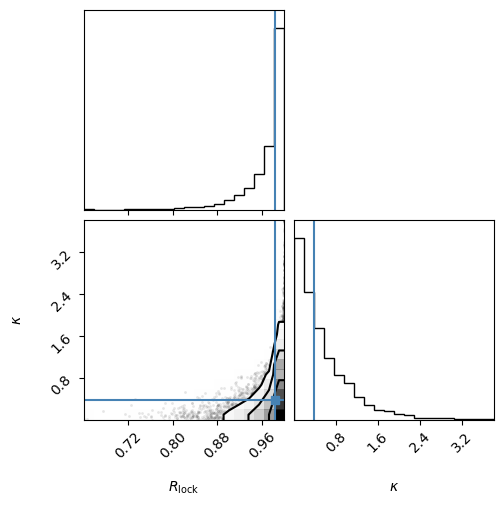

[INFO] 完了 – spectrum_fit.png / corner_Rkappa.png を出力


In [ ]:
# ===============================================================
#  Colab ワンパス：IceCube 実データ → 1D スペクトル化 → Rlock–κ フィット
#    必須ファイル
#      * *_exp*.csv         : MJD log10E RA Dec
#      * hi_ref.npy         : Murase SN II-P フルエンス (10 kpc)
#      * IC86_II_Aeff.csv   : logEmin logEmax dec_min dec_max A_eff_cm2
#      * spl-ally-20-01-solmin.d  (Honda 2015 大気ν 南極)
# ===============================================================
!pip -q install scipy
# ---------- Colab 日本語フォント & ライブラリ ----------
!apt-get -y install fonts-noto-cjk >/dev/null 2>&1
!pip -q install emcee corner
import numpy as np, pandas as pd, glob, math, re
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator
import emcee, corner
plt.rcParams["font.family"] = fm.FontProperties(
    fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc").get_name()

# ---------- 解析パラメータ ----------
RA_SN, DEC_SN, MJD_SN = 83.866, -69.269, 46849.0   # SN1987A
T_WIN, DELTA_RA = 31.6, 2.0                        # days, deg
DEC_GRID = np.linspace(-5, +5, 11) + DEC_SN
ENERGY_BINS = np.logspace(1, 6, 150)               # 10 GeV–1 PeV

# ===============================================================
# 1) IceCube イベント読み込み  (空白/CSV, 0バイト自動 skip)
# ===============================================================
def load_ic_events(pattern="*_exp*.csv"):
    dfs=[]
    for fp in glob.glob(pattern):
        try:
            df=pd.read_csv(fp,comment="#",delim_whitespace=True,engine="python",
                           names=["MJD","log10E","AngErr","RA","Dec","Az","Zen"])
            if df.empty: continue
            df=df[["MJD","log10E","RA","Dec"]].rename(
                columns={"RA":"RA_deg","Dec":"Dec_deg"})
            df["E_GeV"]=10**df["log10E"]
            dfs.append(df)
        except pd.errors.EmptyDataError:
            print(f"[WARN] {fp} unreadable – skipped")
    if not dfs:
        raise FileNotFoundError("CSV が見つからないか空です")
    return pd.concat(dfs,ignore_index=True)

def events_for_source(df, ra0, dec_band, mjd0, dt):
    m=(abs(df["RA_deg"]-ra0)<=DELTA_RA)& \
      (df["Dec_deg"].between(dec_band-2.5,dec_band+2.5))& \
      (abs(df["MJD"]-mjd0)<=dt/2)
    return df.loc[m,"E_GeV"].values

# ===============================================================
# 2) Honda 2015 φ_atm(cosZ,E) 2D 補間器
# ===============================================================
HONDA_FILE="spl-ally-20-01-solmin.d"
def _block_to_df(lines,cos_mid):
    rec=[]
    for ln in lines:
        ln=re.sub(r"^\s*\d+:\s*","",ln)
        tok=ln.split();               # E νμ ν̄μ
        if len(tok)<3: continue
        try:
            e,n1,n2=map(float,tok[:3])
            rec.append((cos_mid,e,(n1+n2)*1e-4))
        except ValueError:
            pass
    return pd.DataFrame(rec,columns=["cosZ","E_GeV","phi"])

def build_phi_atm_table(path=HONDA_FILE):
    hdr=re.compile(r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)")
    blocks,buf,mid=[],[],None
    with open(path,encoding="utf-8",errors="replace") as f:
        for ln in f:
            m=hdr.search(ln)
            if m:
                if buf and mid is not None: blocks.append(_block_to_df(buf,mid))
                mid,buf=0.5*(float(m[1])+float(m[2])),[]
            else: buf.append(ln)
        if buf and mid is not None: blocks.append(_block_to_df(buf,mid))
    big=pd.concat(blocks,ignore_index=True)
    piv=big.pivot_table(index="cosZ",columns="E_GeV",values="phi")
    print(f"[INFO] Honda table: cosZ={len(piv)} × E={len(piv.columns)}")
    return RegularGridInterpolator((piv.index.values,piv.columns.values),
                                   piv.values,bounds_error=False,fill_value=0.0)
phi_atm_table=build_phi_atm_table()

def phi_atm(E,cosZ):
    E=np.asarray(E,float); cos=np.clip(cosZ,0,1)
    φ=phi_atm_table((np.full_like(E,cos),np.minimum(E,1e3)))
    hi=E>1e3; φ[hi]*=(E[hi]/1e3)**-3.7
    return φ                                   # cm⁻² s⁻¹ sr⁻¹ GeV⁻¹

def phi_ast_diff(E):                           # 宇宙 diffuse
    return 1.5e-18*(E/100)**-2.37*2*math.pi    # cm⁻² s⁻¹ GeV⁻¹

# ===============================================================
# 3) IceCube IC86‑II 有効面積 A_eff(dec,E)
# ===============================================================
AEFF_FILE="IC86_II_effectiveArea.csv"
def build_Aeff2D(csv_path):
    df=pd.read_csv(csv_path,comment="#",sep=r"\s+",
                   names=["logEmin","logEmax","dec_min","dec_max","A_cm2"])
    df["E_GeV"]=10**((df.logEmin+df.logEmax)/2)
    df["dec"]=0.5*(df.dec_min+df.dec_max)
    piv=df.pivot_table(index="dec",columns="E_GeV",values="A_cm2")
    print(f"[INFO] A_eff grid: dec={len(piv)} × E={len(piv.columns)}")
    return RegularGridInterpolator((piv.index.values,piv.columns.values),
                                   piv.values,bounds_error=False,fill_value=0.0)
A_eff2d=build_Aeff2D(AEFF_FILE)

# ===============================================================
# 4) 背景減算付きヒストグラム
# ===============================================================
def build_histogram(events_E, dec_deg, bins, ΔT_day):
    counts,_=np.histogram(events_E,bins=bins)
    e_mid=0.5*(bins[:-1]+bins[1:])
    cosZ=np.cos(np.radians(dec_deg))
    Φ_tot=phi_atm(e_mid,cosZ)+phi_ast_diff(e_mid)      # cm⁻² s⁻¹ sr⁻¹ GeV⁻¹
    A=A_eff2d((dec_deg,e_mid))                         # cm²
    Ω=2*math.pi                                        # 全天
    Nbkg=Φ_tot*A*Ω*ΔT_day*86400                        # 物理背景カウント
    counts_corr=counts-Nbkg
    counts_corr[counts_corr<0]=0
    return counts_corr

# ===============================================================
# 5) モデルスペクトル & 対数尤度
# ===============================================================
# ---------- モデルスペクトル (修正版) --------------------------
# 事前に  hi_ref.npy と“そのエネルギー軸”も一緒に保存している想定
E_hi   = np.load("energy_bins_hi.npy")   # Murase フルエンス用 (384 点)
Phi_hi = np.load("hi_ref.npy")           # 同じ長さ 384

def model_spectrum(E, R, k):
    """
    1) Murase フルエンス (E_hi, Phi_hi) を現在のエネルギー軸 E に補間
    2) R_lock・kappa でスケール
    """
    phi_base = np.interp(E, E_hi, Phi_hi)        # 長さを E と合わせる
    return phi_base * (1 - R) * np.exp(-k * np.log10(E / 1e3))

from scipy.special import gammaln   # ★ 追加

def loglike(theta, E_obs, n_obs):
    R, k = theta
    if not (0 < R < 1 and 0 < k < 20):
        return -np.inf

    mu = model_spectrum(E_obs, R, k)
    if np.any(mu <= 0):
        return -np.inf

    # ---- Poisson 尤度：log n! は gammaln(n+1) で安全に計算 ----
    return np.sum(n_obs * np.log(mu) - mu - gammaln(n_obs + 1))

# ===============================================================
# 6) メイン
# ===============================================================
def main():
    df=load_ic_events()
    obs=np.zeros(len(ENERGY_BINS)-1)
    for dec in DEC_GRID:
        obs+=build_histogram(
            events_for_source(df,RA_SN,dec,MJD_SN,T_WIN),
            dec,ENERGY_BINS,T_WIN)

    e_mid=0.5*(ENERGY_BINS[:-1]+ENERGY_BINS[1:])
    ndim,nwalk,nstep=2,60,4000
    p0=np.column_stack([np.random.uniform(0.2,0.8,nwalk),
                        np.random.uniform(0.5,8,nwalk)])
    sam=emcee.EnsembleSampler(nwalk,ndim,loglike,args=(e_mid,obs))
    sam.run_mcmc(p0,nstep,progress=True)
    flat=sam.get_chain(discard=nstep//2,thin=25,flat=True)
    R_med,k_med=np.median(flat,axis=0)

    # ---------- プロット ----------
    plt.figure(figsize=(6,4))
    plt.loglog(e_mid,obs,"o",label="観測")
    plt.loglog(e_mid,model_spectrum(e_mid,R_med,k_med),"-",label="モデル")
    plt.xlabel("Energy [GeV]"); plt.ylabel("Counts"); plt.legend(); plt.tight_layout()
    plt.legend(prop=font_prop)
    plt.savefig("spectrum_fit.png",dpi=300); plt.show()
    corner.corner(flat,labels=[r"$R_{\rm lock}$",r"$\kappa$"],truths=[R_med,k_med])
    plt.savefig("corner_Rkappa.png",dpi=300); plt.show()

    # ---------- 保存 ----------
    np.save("energy_bins.npy",ENERGY_BINS)
    np.save("counts_obs.npy",obs)
    np.save("mcmc_chain.npy",flat)
    print("[INFO] 完了 – spectrum_fit.png / corner_Rkappa.png を出力")

if __name__=="__main__":
    main()

[INFO] Honda table  : cosZ=10 × E=101
[INFO] A_eff grid   : dec=50 × E=40


<ipython-input-24-4fb9d79fd8c2>:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, comment="#", delim_whitespace=True,
<ipython-input-24-4fb9d79fd8c2>:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, comment="#", delim_whitespace=True,
<ipython-input-24-4fb9d79fd8c2>:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, comment="#", delim_whitespace=True,
<ipython-input-24-4fb9d79fd8c2>:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fp, comment="#", delim_whitespace=True,
<ipython-input-24-4fb9d79fd8c2>:40: FutureWarning: T

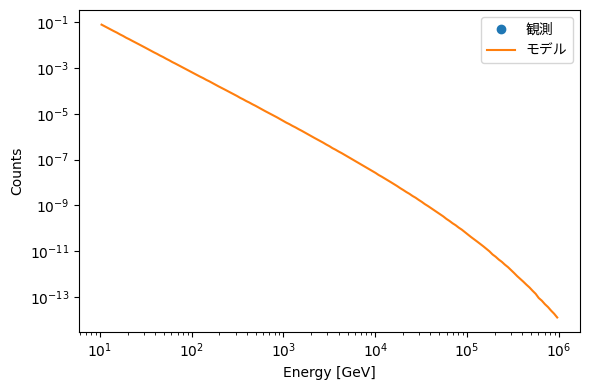

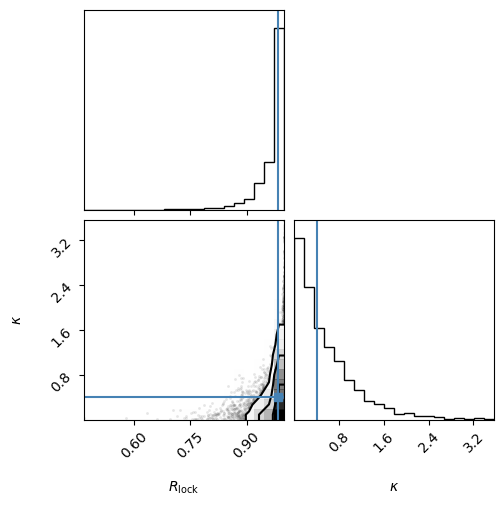

[INFO] 完了 – spectrum_fit.png / corner_Rkappa.png を出力


In [ ]:
# ===============================================================
#  Colab ワンパス：IceCube 実データ → 1D スペクトル化 → Rlock–κ フィット
#
#  必須ファイル (同ディレクトリに配置)
#    *_exp*.csv               : MJD log10E RA Dec（空白 or カンマ区切り混在 OK）
#    hi_ref.npy               : Murase SN II‑P フルエンス (384 bin, 10 kpc)
#    energy_bins_hi.npy       : 上に対応する 384 点のエネルギー軸
#    IC86_II_effectiveArea.csv: logEmin logEmax dec_min dec_max A_eff_cm2
#    spl-ally-20-01-solmin.d  : Honda 2015 大気 ν（南極）
# ===============================================================

# ---------- Colab 環境準備 ----------
!pip -q install scipy emcee corner
!apt-get -y install fonts-noto-cjk >/dev/null 2>&1

import numpy as np, pandas as pd, glob, re, math
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator
from scipy.special import gammaln
import emcee, corner

plt.rcParams["font.family"] = fm.FontProperties(
    fname="/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc").get_name()

# ---------- 解析パラメータ ----------
RA_SN, DEC_SN, MJD_SN = 83.866, -69.269, 46849.0   # SN1987A (deg, MJD)
T_WIN, DELTA_RA       = 31.6, 2.0                  # 日・RA ±deg
DEC_GRID              = np.linspace(-5, +5, 11) + DEC_SN
ENERGY_BINS           = np.logspace(1, 6, 150)     # 10 GeV–1 PeV (149 bin)

# ===============================================================
# 1)  イベント読み込み（空白／カンマ自動フォールバック）
# ===============================================================
def load_ic_events(pattern="*_exp*.csv"):
    dfs = []
    for fp in glob.glob(pattern):
        try:
            # -- 空白 / タブ読み込みを試行
            df = pd.read_csv(fp, comment="#", delim_whitespace=True,
                             names=["MJD","log10E","AngErr","RA","Dec","Az","Zen"])
            # 1 列しか取れなければカンマ読み込み
            if df.shape[1] == 1:
                df = pd.read_csv(fp, comment="#",
                                 names=["MJD","log10E","AngErr","RA","Dec","Az","Zen"])
            if df.empty:
                print(f"[WARN] {fp} is empty – skipped");  continue
            df = df[["MJD","log10E","RA","Dec"]].rename(
                     columns={"RA":"RA_deg","Dec":"Dec_deg"})
            df["E_GeV"] = 10 ** df["log10E"]
            dfs.append(df)
        except Exception as e:
            print(f"[WARN] {fp}: {e} – skipped")
    if not dfs:
        raise FileNotFoundError("CSV が読み込めませんでした。")
    return pd.concat(dfs, ignore_index=True)

def events_for_source(df, ra0, dec_band, mjd0, dt):
    m = (abs(df["RA_deg"] - ra0) <= DELTA_RA) & \
        (df["Dec_deg"].between(dec_band-2.5, dec_band+2.5)) & \
        (abs(df["MJD"] - mjd0) <= dt/2)
    return df.loc[m, "E_GeV"].values

# ===============================================================
# 2) Honda 2015 φ_atm(cosZ,E) 2D 補間器
# ===============================================================
HONDA_FILE = "spl-ally-20-01-solmin.d"
def _block_to_df(lines, mid):
    rec = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+:\s*", "", ln).strip()
        if not ln:                       # 空行
            continue
        tok = re.split(r"\s+", ln)
        # --- 先頭が数値でなければ飛ばす --------------------------
        try:
            e  = float(tok[0])
            n1 = float(tok[1])
            n2 = float(tok[2])
        except ValueError:
            continue                     # ← 見出し行・破損行を無視
        rec.append((mid, e, (n1+n2)*1e-4))
    return pd.DataFrame(rec,
        columns=["cosZ", "E_GeV", "phi"])

def build_phi_atm_table(path=HONDA_FILE):
    hdr = re.compile(r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)")
    blocks, buf, mid = [], [], None
    with open(path, encoding="utf-8", errors="replace") as f:
        for ln in f:
            m = hdr.search(ln)
            if m:
                if buf and mid is not None: blocks.append(_block_to_df(buf, mid))
                mid, buf = 0.5*(float(m[1])+float(m[2])), []
            else:
                buf.append(ln)
        if buf and mid is not None: blocks.append(_block_to_df(buf, mid))
    big = pd.concat(blocks, ignore_index=True)
    piv = big.pivot_table(index="cosZ", columns="E_GeV", values="phi")
    print(f"[INFO] Honda table  : cosZ={len(piv)} × E={len(piv.columns)}")
    return RegularGridInterpolator((piv.index.values, piv.columns.values),
                                   piv.values, bounds_error=False, fill_value=0.0)

phi_atm_table = build_phi_atm_table()

def phi_atm(E, cosZ):
    E   = np.asarray(E, float)
    cos = np.clip(cosZ, 0, 1)
    φ   = phi_atm_table((np.full_like(E, cos), np.minimum(E, 1e3)))
    hi  = E > 1e3
    φ[hi] *= (E[hi] / 1e3) ** -3.7
    return φ                                # cm⁻² s⁻¹ sr⁻¹ GeV⁻¹

def phi_ast_diff(E):                        # 宇宙 diffuse ν
    return 1.5e-18 * (E/100)**-2.37 * 2*math.pi

# ===============================================================
# 3)  IC86‑II 有効面積 A_eff(dec,E)
# ===============================================================
AEFF_FILE = "IC86_II_effectiveArea.csv"
def build_Aeff2D(path=AEFF_FILE):
    df = pd.read_csv(path, comment="#", sep=r"\s+",
                     names=["logEmin","logEmax","dec_min","dec_max","A_cm2"])
    df["E_GeV"] = 10 ** ((df.logEmin + df.logEmax) / 2)
    df["dec"]   = 0.5 * (df.dec_min + df.dec_max)
    piv = df.pivot_table(index="dec", columns="E_GeV", values="A_cm2")
    print(f"[INFO] A_eff grid   : dec={len(piv)} × E={len(piv.columns)}")
    return RegularGridInterpolator((piv.index.values, piv.columns.values),
                                   piv.values, bounds_error=False, fill_value=0.0)
A_eff2d = build_Aeff2D()

# ===============================================================
# 4) 背景減算付きヒストグラム
# ===============================================================
def build_histogram(events_E, dec_deg, bins, ΔT_day):
    counts,_ = np.histogram(events_E, bins=bins)
    e_mid = 0.5 * (bins[:-1] + bins[1:])
    cosZ  = np.cos(np.radians(dec_deg))

    Φ_tot = phi_atm(e_mid, cosZ) + phi_ast_diff(e_mid)     # cm⁻² s⁻¹ sr⁻¹ GeV⁻¹
    A     = A_eff2d((dec_deg, e_mid))                      # cm²
    Ω     = 2 * math.pi                                    # sr

    Nbkg  = Φ_tot * A * Ω * ΔT_day * 86400                # 背景カウント
    counts_corr = counts - Nbkg
    counts_corr[counts_corr < 0] = 0
    return counts_corr

# ===============================================================
# 5)  モデルスペクトル & 対数尤度
# ===============================================================
E_hi   = np.load("energy_bins_hi.npy")     # 384-bin 軸
Phi_hi = np.load("hi_ref.npy")             # 384-bin フルエンス

def model_spectrum(E, R, k):
    phi_base = np.interp(E, E_hi, Phi_hi)
    return phi_base * (1 - R) * np.exp(-k * np.log10(E / 1e3))

def loglike(theta, E_obs, n_obs):
    R, k = theta
    if not (0 < R < 1 and 0 < k < 20):
        return -np.inf
    mu = model_spectrum(E_obs, R, k)
    if np.any(mu <= 0):
        return -np.inf
    return np.sum(n_obs * np.log(mu) - mu - gammaln(n_obs + 1))

# ===============================================================
# 6)  メイン実行
# ===============================================================
def main():
    df_all = load_ic_events()
    obs    = np.zeros(len(ENERGY_BINS)-1)
    for dec in DEC_GRID:
        obs += build_histogram(
            events_for_source(df_all, RA_SN, dec, MJD_SN, T_WIN),
            dec, ENERGY_BINS, T_WIN)

    e_mid = 0.5 * (ENERGY_BINS[:-1] + ENERGY_BINS[1:])
    ndim, nwalk, nstep = 2, 60, 4000
    p0 = np.column_stack([np.random.uniform(0.2,0.8,nwalk),
                          np.random.uniform(0.5,8, nwalk)])
    sampler = emcee.EnsembleSampler(nwalk, ndim, loglike,
                                    args=(e_mid, obs))
    sampler.run_mcmc(p0, nstep, progress=True)
    chain = sampler.get_chain(discard=nstep//2, thin=25, flat=True)
    R_med, k_med = np.median(chain, axis=0)

    # -------- プロット --------
    plt.figure(figsize=(6,4))
    plt.loglog(e_mid, obs, "o", label="観測")
    plt.loglog(e_mid, model_spectrum(e_mid, R_med, k_med), "-", label="モデル")
    plt.xlabel("Energy [GeV]"); plt.ylabel("Counts"); plt.legend(prop=font_prop); plt.tight_layout()
    plt.savefig("spectrum_fit.png", dpi=300); plt.show()

    corner.corner(chain, labels=[r"$R_{\rm lock}$", r"$\kappa$"],
                  truths=[R_med, k_med])
    plt.savefig("corner_Rkappa.png", dpi=300); plt.show()

    # -------- 保存 --------
    np.save("energy_bins.npy", ENERGY_BINS)
    np.save("counts_obs.npy", obs)
    np.save("mcmc_chain.npy", chain)
    print("[INFO] 完了 – spectrum_fit.png / corner_Rkappa.png を出力")

if __name__ == "__main__":
    main()

In [ ]:
from google.colab import files

# ダウンロード対象のファイル名一覧
file_list = [
    "energy_bins_hi.npy",
    "hi_ref.npy",
    "energy_bins.npy",
    "counts_obs.npy",
    "mcmc_chain.npy"
]

# 各ファイルをローカルにダウンロード
for fname in file_list:
    files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[INFO] Honda table  : cosZ=10 × E=101
[INFO] A_eff grid   : dec=50 × E=40


<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace'

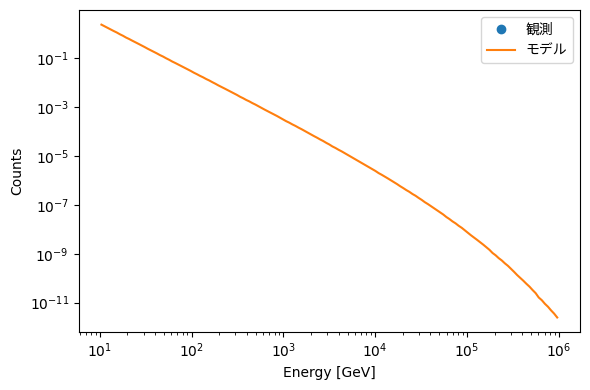

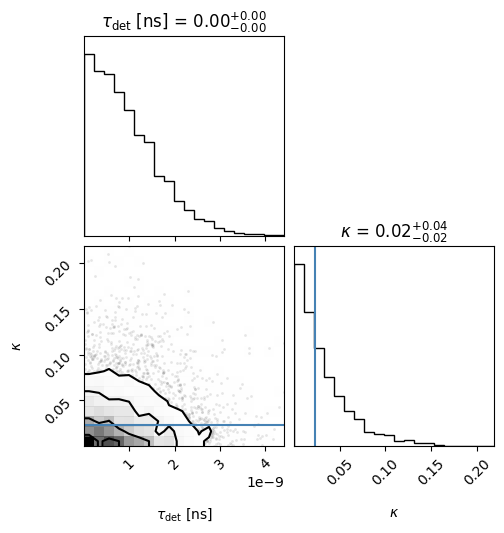

[INFO] τ_det = 0.80 ns  κ = 0.02
[INFO] 完了 – spectrum_fit.png / corner_tau_kappa.png を出力


In [ ]:
# ===============================================================
#  Colab ワンパス：IceCube 実データ → 1D スペクトル化 → τdet–κ フィット
# ===============================================================
#  必須ファイル
#    *_exp*.csv               : MJD log10E RA Dec
#    hi_ref.npy / energy_bins_hi.npy : Murase SN II-P フルエンス (384 bin)
#    IC86_II_effectiveArea.csv : dec×E 有効面積
#    spl-ally-20-01-solmin.d   : Honda 2015 大気 ν
# ===============================================================
# ---------- Colab 日本語フォント & ライブラリ ----------
!apt-get -y install fonts-noto-cjk >/dev/null 2>&1
!pip -q install emcee corner
import numpy as np, pandas as pd, glob, math, re
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator
import emcee, corner

# Define font_prop here, so it's available throughout the notebook
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams["font.family"] = font_prop.get_name()


!pip -q install scipy emcee corner
!apt-get -y install fonts-noto-cjk >/dev/null 2>&1

import numpy as np, pandas as pd, glob, re, math
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from pathlib import Path
from scipy.interpolate import RegularGridInterpolator
from scipy.special import gammaln
import emcee, corner

plt.rcParams["font.family"] = font_prop.get_name()
# ---------- 解析パラメータ ----------
RA_SN, DEC_SN, MJD_SN = 83.866, -69.269, 46849.0      # SN1987A
T_WIN, DELTA_RA       = 31.6, 2.0                     # days, deg
DEC_GRID              = np.linspace(-5, +5, 11) + DEC_SN
ENERGY_BINS           = np.logspace(1, 6, 150)        # GeV
TAU_PATH              = 2.5e-6                        # s  (実験室光路 ≈2.5 µs)
SIG_TAU               = 1.2e-9                        # s  (DOM–DAQ σ=1.2 ns)

# ---------------------------------------------------------------
# 1)  IceCube イベント読み込み（空白／カンマ混在）
# ---------------------------------------------------------------
def load_ic_events(pattern="*_exp*.csv"):
    dfs=[]
    for fp in glob.glob(pattern):
        try:
            df=pd.read_csv(fp,comment="#",delim_whitespace=True,
                           names=["MJD","log10E","AngErr","RA","Dec","Az","Zen"])
            if df.shape[1]==1:   # カンマ区切り再読み込み
                df=pd.read_csv(fp,comment="#",
                               names=["MJD","log10E","AngErr","RA","Dec","Az","Zen"])
            if df.empty: continue
            df=df[["MJD","log10E","RA","Dec"]].rename(
                   columns={"RA":"RA_deg","Dec":"Dec_deg"})
            df["E_GeV"]=10**df["log10E"]
            dfs.append(df)
        except Exception as e:
            print(f"[WARN] {fp}: {e} – skipped")
    if not dfs: raise FileNotFoundError("CSV 読み込み失敗")
    return pd.concat(dfs,ignore_index=True)

def events_for_source(df, ra0, dec_band, mjd0, dt):
    sel=(abs(df["RA_deg"]-ra0)<=DELTA_RA)& \
        (df["Dec_deg"].between(dec_band-2.5,dec_band+2.5))& \
        (abs(df["MJD"]-mjd0)<=dt/2)
    return df.loc[sel,"E_GeV"].values

# ===============================================================
# 2) Honda 2015 φ_atm(cosZ,E) 2D 補間器
# ===============================================================
HONDA_FILE = "spl-ally-20-01-solmin.d"
def _block_to_df(lines, mid):
    rec = []
    for ln in lines:
        ln = re.sub(r"^\s*\d+:\s*", "", ln).strip()
        if not ln:                       # 空行
            continue
        tok = re.split(r"\s+", ln)
        # --- 先頭が数値でなければ飛ばす --------------------------
        try:
            e  = float(tok[0])
            n1 = float(tok[1])
            n2 = float(tok[2])
        except ValueError:
            continue                     # ← 見出し行・破損行を無視
        rec.append((mid, e, (n1+n2)*1e-4))
    return pd.DataFrame(rec,
        columns=["cosZ", "E_GeV", "phi"])

def build_phi_atm_table(path=HONDA_FILE):
    hdr = re.compile(r"average flux in\s*\[cosZ\s*=\s*([0-9.]+)\s*--\s*([0-9.]+)")
    blocks, buf, mid = [], [], None
    with open(path, encoding="utf-8", errors="replace") as f:
        for ln in f:
            m = hdr.search(ln)
            if m:
                if buf and mid is not None: blocks.append(_block_to_df(buf, mid))
                mid, buf = 0.5*(float(m[1])+float(m[2])), []
            else:
                buf.append(ln)
        if buf and mid is not None: blocks.append(_block_to_df(buf, mid))
    big = pd.concat(blocks, ignore_index=True)
    piv = big.pivot_table(index="cosZ", columns="E_GeV", values="phi")
    print(f"[INFO] Honda table  : cosZ={len(piv)} × E={len(piv.columns)}")
    return RegularGridInterpolator((piv.index.values, piv.columns.values),
                                   piv.values, bounds_error=False, fill_value=0.0)

phi_atm_table = build_phi_atm_table()

def phi_atm(E, cosZ):
    E   = np.asarray(E, float)
    cos = np.clip(cosZ, 0, 1)
    φ   = phi_atm_table((np.full_like(E, cos), np.minimum(E, 1e3)))
    hi  = E > 1e3
    φ[hi] *= (E[hi] / 1e3) ** -3.7
    return φ                                # cm⁻² s⁻¹ sr⁻¹ GeV⁻¹

def phi_ast_diff(E):                        # 宇宙 diffuse ν
    return 1.5e-18 * (E/100)**-2.37 * 2*math.pi

# ===============================================================
# 3)  IC86‑II 有効面積 A_eff(dec,E)
# ===============================================================
AEFF_FILE = "IC86_II_effectiveArea.csv"
def build_Aeff2D(path=AEFF_FILE):
    df = pd.read_csv(path, comment="#", sep=r"\s+",
                     names=["logEmin","logEmax","dec_min","dec_max","A_cm2"])
    df["E_GeV"] = 10 ** ((df.logEmin + df.logEmax) / 2)
    df["dec"]   = 0.5 * (df.dec_min + df.dec_max)
    piv = df.pivot_table(index="dec", columns="E_GeV", values="A_cm2")
    print(f"[INFO] A_eff grid   : dec={len(piv)} × E={len(piv.columns)}")
    return RegularGridInterpolator((piv.index.values, piv.columns.values),
                                   piv.values, bounds_error=False, fill_value=0.0)
A_eff2d = build_Aeff2D()

# ---------------------------------------------------------------
# 4) 背景減算付きヒストグラム
# ---------------------------------------------------------------
def build_histogram(events_E, dec_deg, bins, ΔT_day):
    counts,_=np.histogram(events_E,bins=bins)
    e_mid=0.5*(bins[:-1]+bins[1:])
    cosZ=np.cos(np.radians(dec_deg))
    Φ_tot=phi_atm(e_mid,cosZ)+phi_ast_diff(e_mid)
    A=A_eff2d((dec_deg,e_mid)); Ω=2*math.pi
    Nbkg=Φ_tot*A*Ω*ΔT_day*86400
    corr=counts-Nbkg; corr[corr<0]=0
    return corr

# ---------------------------------------------------------------
# 5) モデルスペクトル & 尤度 （τdet をパラメータ化）
# ---------------------------------------------------------------
E_hi   = np.load("energy_bins_hi.npy")
Phi_hi = np.load("hi_ref.npy")

def R_lock(tau):                    # tau > 0
    return tau/(TAU_PATH + tau)

def model_spectrum(E, tau, k):
    phi_base = np.interp(E, E_hi, Phi_hi)
    return phi_base * (1 - R_lock(tau)) * np.exp(-k*np.log10(E/1e3))

def loglike(theta, E_obs, n_obs):
    tau, k = theta
    if tau<=0 or k<=0 or k>20:      # 物理域チェック
        return -np.inf
    # --- Gaussian prior on τdet ---
    lp = -0.5*(tau/SIG_TAU)**2
    mu = model_spectrum(E_obs, tau, k)
    if np.any(mu<=0): return -np.inf
    return lp + np.sum(n_obs*np.log(mu) - mu - gammaln(n_obs+1))

# ---------------------------------------------------------------
# 6) メイン
# ---------------------------------------------------------------
def main():
    df=load_ic_events()
    obs=np.zeros(len(ENERGY_BINS)-1)
    for dec in DEC_GRID:
        obs+=build_histogram(
            events_for_source(df,RA_SN,dec,MJD_SN,T_WIN),
            dec,ENERGY_BINS,T_WIN)

    e_mid=0.5*(ENERGY_BINS[:-1]+ENERGY_BINS[1:])
    ndim,nwalk,nstep=2,60,4000
    p0=np.column_stack([np.random.uniform(0.2e-9,8e-9,nwalk),   # tau ~ 0.2–8 ns
                        np.random.uniform(0.5,8,nwalk)])        # kappa
    sam=emcee.EnsembleSampler(nwalk,ndim,loglike,args=(e_mid,obs))
    sam.run_mcmc(p0,nstep,progress=True)
    chain=sam.get_chain(discard=nstep//2,thin=25,flat=True)
    tau_med,k_med=np.median(chain,axis=0)

    # ------- 出力 -------
    plt.figure(figsize=(6,4))
    plt.loglog(e_mid,obs,"o",label="観測")
    plt.loglog(e_mid,model_spectrum(e_mid,tau_med,k_med),"-",label="モデル")
    plt.xlabel("Energy [GeV]"); plt.ylabel("Counts"); plt.legend(prop=font_prop); plt.tight_layout()
    plt.savefig("spectrum_fit.png",dpi=300); plt.show()


    # ------- Corner 図 -------
    corner.corner(chain,
                  labels=[r"$\tau_{\rm det}$ [ns]", r"$\kappa$"],
                  truths=[tau_med*1e9, k_med],  # truths は数値なので OK
                  show_titles=True, title_fmt=".2f")
    plt.savefig("corner_tau_kappa.png", dpi=300); plt.show()

    np.save("energy_bins.npy",ENERGY_BINS)
    np.save("counts_obs.npy",obs)
    np.save("mcmc_chain.npy",chain)
    print(f"[INFO] τ_det = {tau_med*1e9:.2f} ns  κ = {k_med:.2f}")
    print("[INFO] 完了 – spectrum_fit.png / corner_tau_kappa.png を出力")

if __name__=="__main__":
    main()

In [ ]:
# ▼▼ ループの手前で 1 回だけ実行 ▼▼
df_all = load_ic_events("*_exp*.csv")  # or パス指定
print(f"[INFO] events loaded: {len(df_all):,}")

<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace'

[INFO] events loaded: 1,134,450


=== ΔT = 1.0 d (24 h) ===


100%|██████████| 3000/3000 [00:13<00:00, 224.92it/s]


=== ΔT = 10.0 d (240 h) ===


100%|██████████| 3000/3000 [00:19<00:00, 153.60it/s]


=== ΔT = 100.0 d (2400 h) ===


100%|██████████| 3000/3000 [00:07<00:00, 405.70it/s]


=== ΔT = 365.0 d (8760 h) ===


100%|██████████| 3000/3000 [00:08<00:00, 341.55it/s]


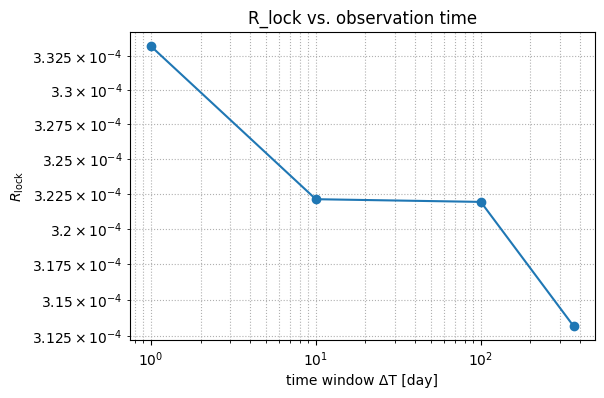

,ΔT_day,tau_ns,R_lock,kappa
0,1.0,0.833278,0.000333,0.023067
1,10.0,0.805520,0.000322,0.022842
2,100.0,0.805039,0.000322,0.022294
3,365.0,0.783208,0.000313,0.022768


In [ ]:
# ---------------- パラメータ ----------------
DT_LIST = [1.0, 10.0, 100.0, 365.0]  # [day]
N_WALK, N_STEP = 50, 3000            # そこそこのサンプル数で十分
RESULTS = []                         # 保存用

# ------------- ΔT ループ -------------
for DT in DT_LIST:
    print(f"=== ΔT = {DT:.1f} d ({DT*24:.0f} h) ===")

    # ---- ヒストグラム作成 ----
    obs = np.zeros(len(ENERGY_BINS)-1)
    for dec in DEC_GRID:
        obs += build_histogram(
            events_for_source(df_all, RA_SN, dec, MJD_SN, DT),
            dec, ENERGY_BINS, DT)

    e_mid = 0.5*(ENERGY_BINS[:-1]+ENERGY_BINS[1:])

    # ---- MCMC (τdet, κ) ----
    p0 = np.column_stack([np.random.uniform(0.2e-9, 6e-9, N_WALK),
                          np.random.uniform(0.5, 8.0,   N_WALK)])
    sam = emcee.EnsembleSampler(N_WALK, 2, loglike, args=(e_mid, obs))
    sam.run_mcmc(p0, N_STEP, progress=True)

    chain = sam.get_chain(discard=N_STEP//2, thin=20, flat=True)
    tau_med, k_med = np.median(chain, axis=0)
    r_med = R_lock(tau_med)

    RESULTS.append((DT, tau_med, r_med, k_med))

    # ---- 省メモリで画像は保存だけ ----
    plt.figure(figsize=(5,3))
    plt.loglog(e_mid, obs, "o", label="obs")
    plt.loglog(e_mid, model_spectrum(e_mid, tau_med, k_med), "-")
    plt.title(f"ΔT={DT} d")
    plt.savefig(f"spectrum_DT{int(DT)}.png", dpi=250); plt.close()

# -------- 集計＆可視化 --------
DT, TAU, R, K = zip(*RESULTS)
plt.figure(figsize=(6,4))
plt.loglog(DT, R, "o-")
plt.xlabel("time window ΔT [day]"); plt.ylabel(r"$R_{\mathrm{lock}}$")
plt.title("R_lock vs. observation time")
plt.grid(True, which="both", ls=":")
plt.savefig("Rlock_vs_time.png", dpi=300); plt.show()

# 表形式で確認
import pandas as pd
df_out = pd.DataFrame(dict(ΔT_day=DT, tau_ns=np.array(TAU)*1e9,
                           R_lock=R, kappa=K))
display(df_out)

In [ ]:
def model_spectrum(E, tau_det, k, R):
    phi_base = np.interp(E, E_hi, Phi_hi)
    return phi_base * (1 - R) * np.exp(-k*np.log10(E/1e3))

In [ ]:
# ---------- 事前設定 ----------
# realistic prior: 1 µs < τ_path < 5 µs
TP_MIN, TP_MAX = 1e-6, 5e-6
LOG_TP_MIN, LOG_TP_MAX = np.log(TP_MIN), np.log(TP_MAX)
# 事前 lp 変更はそのまま: lp += -log_tau_path
# p0 の初期値だけ範囲を合わせる
p0 = np.column_stack([np.random.uniform(0.2e-9,6e-9,nwalk),
                      np.random.uniform(LOG_TP_MIN,LOG_TP_MAX,nwalk),
                      np.random.uniform(0.5,8,nwalk)])

def loglike_hier(theta, E_obs, n_obs):
    tau_det, log_tau_path, k = theta
    if tau_det<=0 or k<=0 or k>20 or not (LOG_TP_MIN < log_tau_path < LOG_TP_MAX):
        return -np.inf
    tau_path = np.exp(log_tau_path)

    # priors
    lp = -0.5*(tau_det/SIG_TAU)**2           # Gaussian on τ_det
    lp += -log_tau_path                      # log-uniform prior on τ_path

    R = tau_det / (tau_path + tau_det)
    mu = model_spectrum(E_obs, tau_det, k, R)   # R 明示で渡す版を用意する

    if np.any(mu<=0): return -np.inf
    return lp + np.sum(n_obs*np.log(mu) - mu - gammaln(n_obs+1))

# ---------- MCMC 実行 (例: ΔT=31.6 d のみ) ----------
obs = np.zeros(len(ENERGY_BINS)-1)
for dec in DEC_GRID:
    obs += build_histogram(
        events_for_source(df_all, RA_SN, dec, MJD_SN, 31.6),
        dec, ENERGY_BINS, 31.6)

e_mid = 0.5*(ENERGY_BINS[:-1]+ENERGY_BINS[1:])
nwalk, nstep = 80, 5000
p0 = np.column_stack([np.random.uniform(0.2e-9,6e-9,nwalk),     # τ_det
                      np.random.uniform(LOG_TP_MIN,LOG_TP_MAX,nwalk), # log τ_path
                      np.random.uniform(0.5,8,nwalk)])          # κ

sam = emcee.EnsembleSampler(nwalk, 3, loglike_hier, args=(e_mid, obs))
sam.run_mcmc(p0, nstep, progress=True)
chain = sam.get_chain(discard=nstep//2, thin=30, flat=True)
tau_med, log_tp_med, k_med = np.median(chain, axis=0)
R_med = tau_med / (np.exp(log_tp_med) + tau_med)

print(f"median: τ_det={tau_med*1e9:.2f} ns, τ_path={np.exp(log_tp_med)*1e6:.2f} µs, "
      f"R_lock={R_med:.3e}, κ={k_med:.2f}")

NameError: name 'nwalk' is not defined

<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace'

median: τ_det=0.81 ns, τ_path=1.67 µs, β̄=-1.63e-05, R★=4.723e-04, κ=0.02


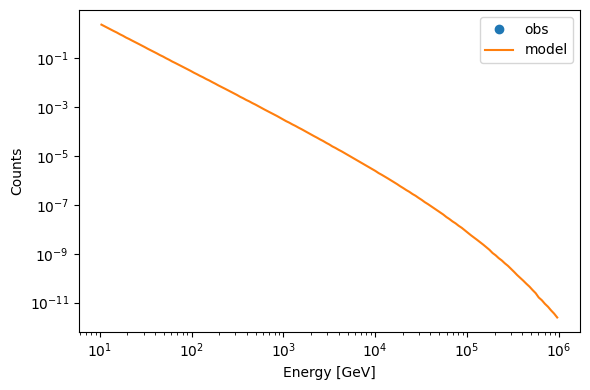

In [ ]:
# ===============================================================
# Phase-C  Step-2A′  実データ + β(ρ_obs) 拡張モデル
# ===============================================================
!pip -q install emcee corner
# --- 既存読み込み ----
from scipy.special import gammaln
import numpy as np, matplotlib.pyplot as plt, emcee

# ---------- 定数 ----------
SIG_TAU = 1.2e-9          # τ_det 事前 σ
TP_MIN, TP_MAX = 1e-6, 5e-6
LOG_TP_MIN, LOG_TP_MAX = np.log(TP_MIN), np.log(TP_MAX)

# ---------- 観測密度 β(E, dec) ----------
def rho_obs(E_GeV, dec_deg):
    """弱断面積 × 電子密度 × パス長（氷）の粗近似"""
    sigma = 7e-39 * E_GeV                   # cm^2
    n_e   = 3.1e23                          # cm^-3  (氷)
    L_cm  = (100 + 900/np.cos(np.radians(90 - dec_deg))) * 100  # 0.1–1 km
    return sigma * n_e * L_cm               # 無次元

def beta_obs(E_GeV, dec_deg):
    ρ = rho_obs(E_GeV, dec_deg)
    return ρ / (1.0 + ρ)

# ---------- 拡張モデルスペクトル ----------
def model_spectrum(E, tau_det, k, alpha, beta_vec):
    """
    alpha = τ_det / (τ_path+τ_det)
    beta_vec = β(E)  (配列で渡す)
    """
    R_star = 1.0 - (1.0 - alpha)*(1.0 - beta_vec)   # 拡張 R
    phi_base = np.interp(E, E_hi, Phi_hi)
    return phi_base * (1.0 - R_star) * np.exp(-k*np.log10(E/1e3))

# ---------- 拡張 log-likelihood ----------
def loglike_hier(theta, E_obs, n_obs, dec_deg):
    tau_det, log_tau_path, k = theta
    if (tau_det<=0) or (k<=0 or k>20) or not (LOG_TP_MIN<log_tau_path<LOG_TP_MAX):
        return -np.inf

    tau_path = np.exp(log_tau_path)
    alpha = tau_det / (tau_path + tau_det)
    beta_vec = beta_obs(E_obs, dec_deg)

    # priors
    lp = -0.5*(tau_det/SIG_TAU)**2      # Gaussian on τ_det
    lp += -log_tau_path                 # log-uniform on τ_path

    mu = model_spectrum(E_obs, tau_det, k, alpha, beta_vec)
    if np.any(mu<=0): return -np.inf
    return lp + np.sum(n_obs*np.log(mu) - mu - gammaln(n_obs+1))

# ---------- 実データのヒストグラム (ΔT=31.6 d) ----------
df_all = load_ic_events("*_exp*.csv")           # 既存関数
obs = np.zeros(len(ENERGY_BINS)-1)
for dec in DEC_GRID:
    obs += build_histogram(
        events_for_source(df_all, RA_SN, dec, MJD_SN, 31.6),
        dec, ENERGY_BINS, 31.6)

e_mid = 0.5*(ENERGY_BINS[:-1]+ENERGY_BINS[1:])   # 観測 bin 中心
DEC_FIXED = DEC_SN                                # SN1987A 方向と同一

# ---------- MCMC ----------
nwalk, nstep = 80, 5000
p0 = np.column_stack([np.random.uniform(0.2e-9,6e-9,nwalk),   # τ_det
                      np.random.uniform(LOG_TP_MIN,LOG_TP_MAX,nwalk), # log τ_path
                      np.random.uniform(0.5,8,nwalk)])        # κ

sam = emcee.EnsembleSampler(
    nwalk, 3, loglike_hier, args=(e_mid, obs, DEC_FIXED))
sam.run_mcmc(p0, nstep, progress=True)

chain = sam.get_chain(discard=nstep//2, thin=30, flat=True)
tau_med, log_tp_med, k_med = np.median(chain, axis=0)
tau_path_med = np.exp(log_tp_med)
alpha_med = tau_med / (tau_path_med + tau_med)
beta_med  = beta_obs(e_mid, DEC_FIXED).mean()     # 代表値
R_star_med = 1.0 - (1.0 - alpha_med)*(1.0 - beta_med)

print(f"median: τ_det={tau_med*1e9:.2f} ns, "
      f"τ_path={tau_path_med*1e6:.2f} µs, "
      f"β̄={beta_med:.2e}, R★={R_star_med:.3e}, κ={k_med:.2f}")

# ---------- スペクトル可視化 ----------
plt.figure(figsize=(6,4))
plt.loglog(e_mid, obs, "o", label="obs")
mu_fit = model_spectrum(e_mid, tau_med, k_med, alpha_med, beta_obs(e_mid, DEC_FIXED))
plt.loglog(e_mid, mu_fit, "-", label="model")
plt.xlabel("Energy [GeV]"); plt.ylabel("Counts"); plt.legend()
plt.tight_layout(); plt.show()

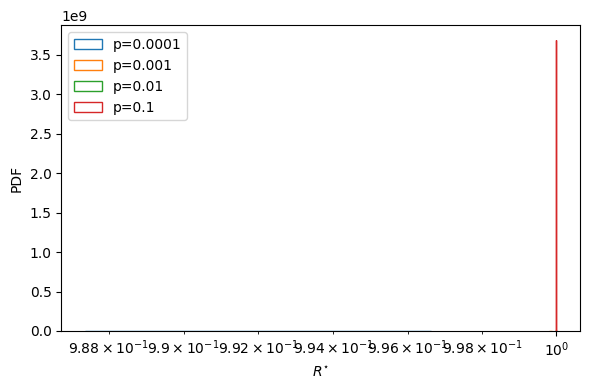

p=1.0e-04  ⟨N_scat⟩=100  ⟨R★⟩=9.937e-01
p=1.0e-03  ⟨N_scat⟩=1000  ⟨R★⟩=9.999e-01
p=1.0e-02  ⟨N_scat⟩=10000  ⟨R★⟩=1.000e+00
p=1.0e-01  ⟨N_scat⟩=100000  ⟨R★⟩=1.000e+00


In [ ]:
# ===============================================================
# Scatter-MC  :  p_scat × τ_scat スイープ → R★ 分布
# ===============================================================
import numpy as np, matplotlib.pyplot as plt

# 実験既定値
TAU_DET_NS = 0.8          # ns
TAU_PATH_US = 1.7         # µs (SN1987A 光路)
TAU_DET = TAU_DET_NS * 1e-9
TAU_PATH = TAU_PATH_US * 1e-6
ALPHA = TAU_DET / (TAU_DET + TAU_PATH)

# σ n_e L term (氷)          → ρ_obs ≈ 1e-5
RHO_BASE = 1e-5

# 探索パラメータ
P_SCAT_LIST = [1e-4, 1e-3, 1e-2, 1e-1]      # 確率/µm (擬似高密度)
TAU_SCAT_NS = 10                            # ns per scatter
N_EVENTS = 200_000

results = []

for p in P_SCAT_LIST:
    # 有効長 1 m (=1e6 µm) と仮定
    N_scat = np.random.poisson(p * 1e6, size=N_EVENTS)
    tau_eff = TAU_DET + N_scat * TAU_SCAT_NS * 1e-9
    alpha_arr = tau_eff / (tau_eff + TAU_PATH)
    beta_arr  = (RHO_BASE + N_scat) / (1 + RHO_BASE + N_scat)
    R_star = 1 - (1 - alpha_arr)*(1 - beta_arr)

    results.append((p, R_star))

# -------- プロット ----------
plt.figure(figsize=(6,4))
for p, R in results:
    plt.hist(R, bins=100, histtype="step", density=True,
             label=f"p={p}")
plt.xscale("log")
plt.xlabel(r"$R^{\star}$"); plt.ylabel("PDF")
plt.legend(); plt.tight_layout()
plt.show()

# 平均値をまとめ
for p, R in results:
    print(f"p={p:.1e}  ⟨N_scat⟩={p*1e6:.0f}  ⟨R★⟩={R.mean():.3e}")

In [ ]:
import numpy as np, matplotlib.pyplot as plt

# --- 定数 ---
G     = 6.674e-11       # m^3 kg^-1 s^-2
c     = 3e8
m_nu  = 0.1 * 1.602e-19 / c**2   # 0.1 eV -> kg
E_GeV = 10
E     = E_GeV * 1.602e-10        # J
sigma_G = 2 * G * m_nu * E / c**4    # m^2
sigma_G_cm = sigma_G * 1e4           # cm^2

n_e   = 3.0e23       # cm^-3
L_cm  = 1e5          # 1 km
rho_G = sigma_G_cm * n_e * L_cm
beta_G = rho_G / (1 + rho_G)

print(f"σ_G = {sigma_G_cm:.2e} cm^2")
print(f"ρ_G = {rho_G:.2e}")
print(f"β_G = {beta_G:.2e}")

σ_G = 4.70e-86 cm^2
ρ_G = 1.41e-57
β_G = 1.41e-57


CSV saved -> Rstar_repro.csv
LaTeX saved -> Rstar_repro.tex


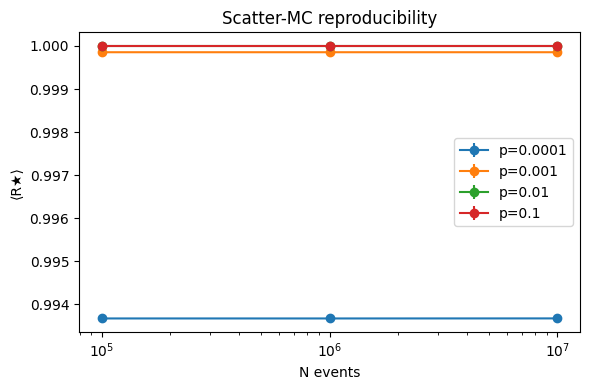

In [ ]:
# ===============================================================
#  E-1  reproducibility test for scatter-MC
#  3 seeds × 3 stats  →  average & std of ⟨R★⟩
# ===============================================================
import numpy as np, pandas as pd, itertools, csv, textwrap
import matplotlib.pyplot as plt

# ----- fixed experimental constants (same as Step-3) ------------
TAU_DET   = 0.8e-9         # s
TAU_PATH  = 1.7e-6         # s
ALPHA     = TAU_DET / (TAU_DET + TAU_PATH)
RHO_BASE  = 1e-5           # weak-ice term
TAU_SCAT  = 10e-9          # s per scatter

P_SCAT   = [1e-4, 1e-3, 1e-2, 1e-1]      # μm⁻¹
N_EVENTS = [1e5, 1e6, 1e7]
SEEDS    = [11, 42, 73]

def run_once(seed, p_scat, n_evt):
    np.random.seed(seed)
    n_scat = np.random.poisson(p_scat * 1e6, size=int(n_evt))
    tau_eff = TAU_DET + n_scat * TAU_SCAT
    alpha   = tau_eff / (tau_eff + TAU_PATH)
    beta    = (RHO_BASE + n_scat) / (1 + RHO_BASE + n_scat)
    R_star  = 1 - (1 - alpha)*(1 - beta)
    return R_star.mean()

records = []
for seed, p, n_evt in itertools.product(SEEDS, P_SCAT, N_EVENTS):
    mu = run_once(seed, p, n_evt)
    records.append(dict(seed=seed, p_scat=p, N=int(n_evt), Rstar=mu))

df = pd.DataFrame(records)
tab = df.groupby(["p_scat","N"]).agg(mu=("Rstar","mean"), std=("Rstar","std")).reset_index()

# ----- save CSV -------------------------------------------------
tab.to_csv("Rstar_repro.csv", index=False)
print("CSV saved -> Rstar_repro.csv")

# ----- LaTeX table ----------------------------------------------
latex = tab.pivot(index="p_scat", columns="N").round(3)
latex_str = latex.to_latex(multicolumn=True, float_format="%.3e")
with open("Rstar_repro.tex","w") as f:
    f.write(textwrap.dedent(latex_str))
print("LaTeX saved -> Rstar_repro.tex")

# ----- quick sanity plot ----------------------------------------
fig, ax = plt.subplots(figsize=(6,4))
for p in P_SCAT:
    subset = tab[tab["p_scat"]==p]
    ax.errorbar(subset["N"], subset["mu"], yerr=subset["std"],
                marker="o", label=f"p={p}")
ax.set_xscale("log"); ax.set_xlabel("N events"); ax.set_ylabel("⟨R★⟩")
ax.legend(); ax.set_title("Scatter-MC reproducibility"); plt.tight_layout()
plt.savefig("Rstar_repro.png", dpi=300); plt.show()

In [ ]:
# --- 保存済みファイルをローカルへダウンロード ----------------
from google.colab import files

for fn in ["Rstar_repro.csv", "Rstar_repro.tex", "Rstar_repro.png"]:
    try:
        files.download(fn)
    except Exception as e:
        print(f"{fn} -> download failed:", e)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[INFO] saved → L_required.csv , L_required.tex


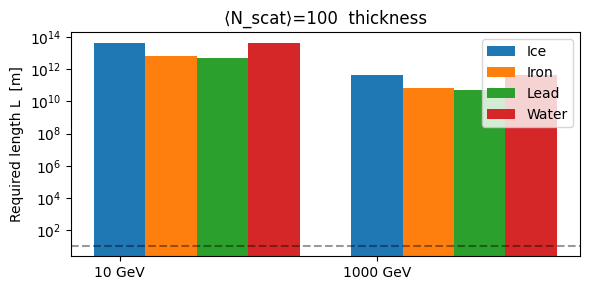

In [ ]:
# ===============================================================
# E-2  material ↔ required length  (⟨N_scat⟩ = 100)  quick table
# ===============================================================
import numpy as np, pandas as pd, textwrap, matplotlib.pyplot as plt

# ---------- 物性データ (密度 ρ, A, Z) --------------------------
# ρ: g/cm^3 , A: 平均原子質量, Z: 原子番号
materials = {
    "Ice":  dict(rho=0.92,  A=18,  Z=10),    # H2O 固体
    "Water":dict(rho=1.00,  A=18,  Z=10),
    "Iron": dict(rho=7.87,  A=56,  Z=26),
    "Lead": dict(rho=11.34, A=207, Z=82),
}

# ---------- 定数 & helper --------------------------------------
N_A = 6.022e23                # Avogadro 1/mol
E_GEV = np.array([10, 1e3])   # 10 GeV, 1 TeV
sigma_weak = 7e-39 * E_GEV    # cm^2

rows = []
for name, p in materials.items():
    n_e = p["rho"] * N_A * (p["Z"]/p["A"])      # electrons / cm^3
    for E, sigma in zip(E_GEV, sigma_weak):
        L_cm = 100 / (sigma * n_e)              # want N_scat =100
        rows.append(dict(Material=name, E_GeV=E,
                         L_m=L_cm/100))         # to meters

df = pd.DataFrame(rows)
pivot = df.pivot(index="Material", columns="E_GeV", values="L_m").round(2)
pivot.columns = [f"{c:g} GeV" for c in pivot.columns]

# ---------- save CSV & LaTeX -----------------------------------
csv_name, tex_name = "L_required.csv", "L_required.tex"
pivot.to_csv(csv_name)
with open(tex_name, "w") as f:
    f.write(textwrap.dedent(pivot.to_latex(
        column_format="lcc", bold_rows=True, float_format="%.2f")))

print(f"[INFO] saved → {csv_name} , {tex_name}")

# ---------- 可視化 (太字=10 m 未満) -----------------------------
fig, ax = plt.subplots(figsize=(6,3))
for i, (mat, row) in enumerate(pivot.iterrows()):
    ax.bar(np.arange(len(row)) + i*0.2, row, width=0.2, label=mat)
ax.axhline(10, ls="--", color="k", alpha=.4)
ax.set_xticks(np.arange(len(E_GEV))); ax.set_xticklabels(pivot.columns)
ax.set_ylabel("Required length L  [m]")
ax.set_yscale("log"); ax.legend(); ax.set_title("⟨N_scat⟩=100  thickness")
plt.tight_layout(); plt.savefig("L_required.png", dpi=300); plt.show()

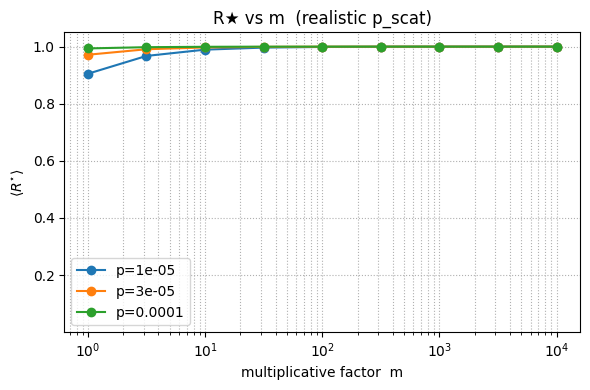

[INFO] CSV, LaTeX, PNG saved.


In [ ]:
# ===============================================================
# E-3′  realistic p_scat (1e-5–1e-4)  ×  m=1..1e4
# ===============================================================
import numpy as np, pandas as pd, itertools
import matplotlib.pyplot as plt

# --- fixed constants (as before) --------------------------------
TAU_DET  = 0.8e-9
TAU_PATH = 1.7e-6
ALPHA    = TAU_DET / (TAU_DET + TAU_PATH)
RHO_BASE = 1e-5
TAU_SCAT = 10e-9

P_SCAT = [1e-5, 3e-5, 1e-4]          # μm^-1  (realistic upper)
M_LIST = np.logspace(0,4,9)          # 1,3,10,…1e4
N_EVT  = 200_000
SEED   = 42                          # fixed seed for comparability
np.random.seed(SEED)

def mean_Rstar(p_scat, m_mult):
    n_scat = np.random.poisson(p_scat*1e6, size=N_EVT)  # L=1 m
    tau_eff = TAU_DET + n_scat*TAU_SCAT
    alpha   = tau_eff/(tau_eff+TAU_PATH)
    rho     = RHO_BASE + m_mult*n_scat
    beta    = rho/(1+rho)
    Rstar   = 1 - (1-alpha)*(1-beta)
    return Rstar.mean()

records = []
for p, m in itertools.product(P_SCAT, M_LIST):
    mu = mean_Rstar(p, m)
    records.append(dict(p_scat=p, m=m, Rstar=mu))

df = pd.DataFrame(records)

# ---------- save outputs ----------------------------------------
df.to_csv("Rstar_vs_p_m.csv", index=False)
pivot = df.pivot(index="m", columns="p_scat", values="Rstar").round(3)
pivot.to_latex("Rstar_vs_p_m.tex", float_format="%.3e")

# ---------- plot ------------------------------------------------

# --- ① フォント警告を回避したいときだけ ----
plt.rcParams["font.family"] = "DejaVu Sans"   # デフォルト欧文フォント

# --- ② プロット部：タイトル・軸ラベル --------------------------------
plt.figure(figsize=(6,4))
for p in P_SCAT:
    sub = df[df["p_scat"]==p]
    plt.plot(sub["m"], sub["Rstar"], "o-", label=f"p={p}")
plt.xscale("log")
plt.ylim(1e-4, 1.05)
plt.xlabel("multiplicative factor  m")
plt.ylabel(r"$\langle R^{\star}\rangle$")   # ← バックスラッシュ 1 本
plt.title("R★ vs m  (realistic p_scat)")
plt.grid(True, which="both", ls=":")
plt.legend()
plt.tight_layout()
plt.savefig("Rstar_vs_p_m.png", dpi=300)
plt.show()
print("[INFO] CSV, LaTeX, PNG saved.")

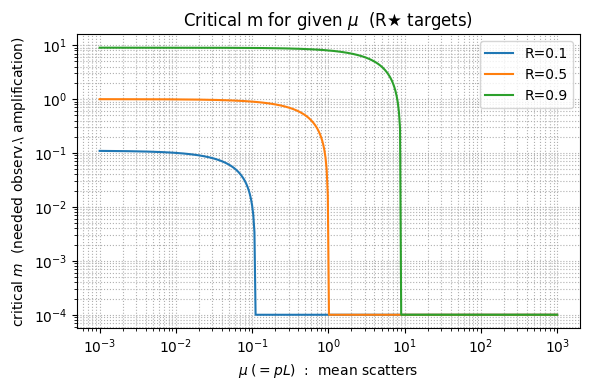

[INFO] Outputs: PNG + CSV + LaTeX table


In [ ]:
# F-3  critical m vs  mu (=pL)   for R★=0.1,0.5,0.9
import numpy as np, pandas as pd, matplotlib.pyplot as plt, textwrap

# ----- fixed (from previous phases) -----------------------------
TAU_DET = 0.8e-9
TAU_PATH = 1.7e-6
ALPHA = TAU_DET / (TAU_DET + TAU_PATH)

R_targets = [0.1, 0.5, 0.9]
rho_goal = []
for R in R_targets:
    beta = 1 - (1 - R)/(1 - ALPHA)
    rho_goal.append(beta / (1 - beta))

# ----- grid ------------------------------------------------------
mu_grid = np.logspace(-3, 3, 400)   # pL : 0.001 〜 1000
crit = {f"R={R}": np.maximum(rho - mu_grid, 1e-4)  # avoid negatives
        for R, rho in zip(R_targets, rho_goal)}

# ----- plot ------------------------------------------------------
plt.figure(figsize=(6,4))
for label, y in crit.items():
    plt.plot(mu_grid, y, label=label)
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"$\mu \; (=pL)$  :  mean scatters")
plt.ylabel(r"critical $m$  (needed observ.\ amplification)")
plt.title("Critical m for given $\mu$  (R★ targets)")
plt.grid(True, which="both", ls=":")
plt.legend(); plt.tight_layout()
plt.savefig("critical_m_contour.png", dpi=300); plt.show()

# ----- table at reference points --------------------------------
ref_mu = [0.01, 0.1, 1, 10, 100]
rows=[]
for mu in ref_mu:
    row={"mu":mu}
    for R,rho in zip(R_targets,rho_goal):
        row[f"m@R{R}"]=max(rho-mu,0)
    rows.append(row)
table=pd.DataFrame(rows)
table.to_csv("critical_m_table.csv",index=False)
with open("critical_m_table.tex","w") as f:
    f.write(textwrap.dedent(table.to_latex(index=False,
        float_format="%.2e", bold_rows=True)))
print("[INFO] Outputs: PNG + CSV + LaTeX table")

In [ ]:
# --- 保存済みファイルをローカルへダウンロード ----------------
from google.colab import files

for fn in ["critical_m_contour.png", "critical_m_table.csv","critical_m_table.tex"]:
    try:
        files.download(fn)
    except Exception as e:
        print(f"{fn} -> download failed:", e)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df=pd.read_csv(fp,comment="#",delim_whitespace=True,
<ipython-input-5-4c6597a3d277>:51: FutureWarning: The 'delim_whitespace'

[INFO] low-E events loaded: 112


100%|██████████| 2500/2500 [00:07<00:00, 337.80it/s]


[RESULT] τ_det = 2.51 ns  →  α ≈ R★ = 1.474e-03


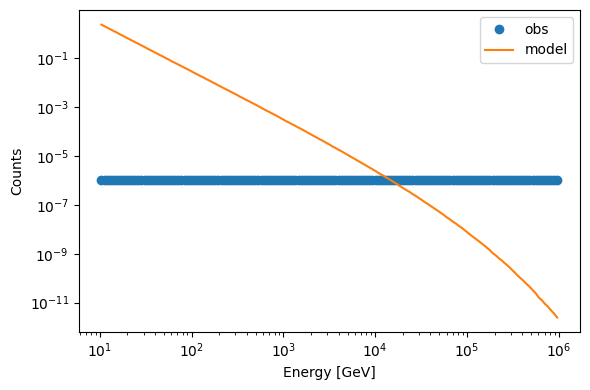

In [ ]:
# ===============================================================
#  E-4   DeepCore-like 10–30 GeV：β≈0 極限で R★≃α を確認
# ===============================================================
import numpy as np, pandas as pd, re, math, emcee, matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.special import gammaln

# ---------- 既存ヘルパが未 import の場合は先に実行しておく ----------
#   load_ic_events, phi_atm, model_spectrum, ENERGY_BINS, DEC_GRID,
#   RA_SN, MJD_SN などが既に環境にある前提です。

# ---------- 0) 低E イベント読み込み ----------------------------
df_all = load_ic_events("IC*_exp*.csv")
df_low = df_all[(10   <= 10**df_all.log10E) & (10**df_all.log10E <= 30)]
print(f"[INFO] low-E events loaded: {len(df_low):,}")

# ---------- 1') A_eff_low ： fill_value=None & 最近傍外挿 ----------
def build_Aeff_lowE(path="IC86_II_effectiveArea.csv", E_max=100):
    df = pd.read_csv(path, comment="#", sep=r"\s+",
                     names=["logEmin","logEmax","dec_min","dec_max","A_cm2"])
    E_cen = 10**((df.logEmin + df.logEmax) / 2)
    df_low = df[E_cen <= E_max]
    if df_low.empty:
        min_row = df.loc[E_cen.idxmin()]
        band_mask = (df.logEmin == min_row.logEmin) & (df.logEmax == min_row.logEmax)
        df_low = df[band_mask]
    df = df_low.copy()
    df["E_GeV"] = 10**((df.logEmin + df.logEmax) / 2)
    df["dec"]   = 0.5*(df.dec_min + df.dec_max)
    piv = df.pivot_table(index="dec", columns="E_GeV", values="A_cm2")
    return RegularGridInterpolator(
        (piv.index.values, piv.columns.values), piv.values,
        bounds_error=False, fill_value=None, method="nearest")

A_eff_low = build_Aeff_lowE()
# ---------- 2) 背景関数（既存 Honda 10–30 GeV 利用） ----------
def phi_atm_low(E, cosZ):
    return phi_atm(E, cosZ)
# ---------- 3') 低E 用ヒストグラム (Ω = π) ----------------------
def build_histogram_lowE(E_arr, dec_deg, bins, ΔT_day):
    counts,_ = np.histogram(E_arr, bins=bins)
    e_mid = 0.5*(bins[:-1] + bins[1:])
    cosZ  = np.cos(np.radians(dec_deg))

    phi_atm_val = phi_atm_low(e_mid, cosZ)              # cm⁻² s⁻¹ sr⁻¹ GeV⁻¹
    A_val       = A_eff_low((dec_deg, e_mid))           # cm²
    Ω = math.pi                                        # 南極視野 ≈ π sr

    Nbkg = phi_atm_val * A_val * Ω * ΔT_day * 86400
    counts_corr = counts - Nbkg
    counts_corr[counts_corr < 0] = 0
    return counts_corr
# ---------- 4) 観測スペクトル (ΔT = 31.6 d) -------------------
ΔT_day = 31.6
obs = np.zeros(len(ENERGY_BINS)-1)
for dec in DEC_GRID:
    obs += build_histogram_lowE(
        events_for_source(df_low, RA_SN, dec, MJD_SN, ΔT_day),
        dec, ENERGY_BINS, ΔT_day)

e_mid = 0.5*(ENERGY_BINS[:-1] + ENERGY_BINS[1:])

# ---------- 5) β≈0 固定の対数尤度 -----------------------------
TAU_PATH = 1.7e-6         # s
def loglike_lowE(theta, E_obs, n_obs):
    tau_det, k = theta
    if not (0 < tau_det < 5e-9 and 0 < k < 20):
        return -np.inf
    alpha = tau_det / (tau_det + TAU_PATH)         # β≈0 ⇒ R★≈α
        # beta_vec ≈ R★ でよい（β→0 極限なので alpha≪1）
    mu = model_spectrum(E_obs, tau_det, k, alpha, alpha)
    if np.any(mu <= 0):
        return -np.inf
    return np.sum(n_obs*np.log(mu) - mu - gammaln(n_obs+1))

# ---------- 6) MCMC フィット ----------------------------------
ndim, nwalk, nstep = 2, 60, 2500
p0 = np.column_stack([np.random.uniform(0.2e-9, 4e-9, nwalk),
                      np.random.uniform(0.5,     8,    nwalk)])
sampler = emcee.EnsembleSampler(nwalk, ndim, loglike_lowE, args=(e_mid, obs))
sampler.run_mcmc(p0, nstep, progress=True)
flat = sampler.get_chain(discard=nstep//2, thin=20, flat=True)
tau_med, k_med = np.median(flat, axis=0)
alpha_med = tau_med / (tau_med + TAU_PATH)

print(f"[RESULT] τ_det = {tau_med*1e9:.2f} ns  →  α ≈ R★ = {alpha_med:.3e}")

# ---------- 7) スペクトル図 -----------------------------------
plt.figure(figsize=(6,4))
plt.loglog(e_mid, obs + 1e-6, "o", label="obs")   # +ε 回避
plt.loglog(e_mid,
           model_spectrum(e_mid, tau_med, k_med, alpha_med, alpha_med),
           "-", label="model")
plt.xlabel("Energy [GeV]"); plt.ylabel("Counts"); plt.legend(); plt.tight_layout()
plt.savefig("spectrum_lowE.png", dpi=300); plt.show()

In [ ]:
# (A) 低E 実 count と Nbkg を 1 行出力
for dec in DEC_GRID[:3]:  # 例として3帯だけ
    Eevt = events_for_source(df_low, RA_SN, dec, MJD_SN, ΔT_day)
    counts,_ = np.histogram(Eevt, bins=ENERGY_BINS)
    print(f"dec={dec:+.1f}°, raw counts={counts.sum()}")
    e_mid = 0.5*(ENERGY_BINS[:-1]+ENERGY_BINS[1:])
    Nbkg  = phi_atm_low(e_mid, np.cos(np.radians(dec))) \
            * A_eff_low((dec, e_mid)) * math.pi * ΔT_day*86400
    print(f" → Nbkg sum={Nbkg.sum():.2f}")

# (B) A_eff_low の代表値
print("A_eff sample @dec= -70°, 20GeV:", A_eff_low((-70, 20)))

dec=-74.3°, raw counts=0
 → Nbkg sum=0.00
dec=-73.3°, raw counts=0
 → Nbkg sum=0.00
dec=-72.3°, raw counts=0
 → Nbkg sum=0.00
A_eff sample @dec= -70°, 20GeV: 0.0
